# Sentiment analysis on tweets

The goal of this project is to test the hypothesized advantages of using and fine-tuning pre-trained language models of BERT (Bidirectional Encoder Representations from Transformers), which is a 2018 paper published by researchers at Google AI Language, for financial domain. For that, sentiment of a sentence from a financial news article towards the financial actor depicted in the sentence will be tried to be predicted, using the Financial PhraseBank created by Malo et al. from Cornell University. (2014)

<table><tr><td>
<img src="./docs/bert_context.png" width="400">
</td><td>
<img src="./docs/bert_structure2.png" width="600">
</td></tr></table>

<br />
<br />

The models tested in this projects are as follows:
<br />
 * A. Lexicon-based approach (Loughran and McDonald Dictionary)
 * B. Tfidf
 * C1. LSTM (RNN)
 * C2. LSTM with GloVe word embedding
 * D1. Bert (pre-trained, hugging-face impementation)
 * D2. Albert
<br />
<br />
<br />

![All Models](./docs/all_models.png)

## Import and configurations

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [2]:
# Check the module versions
# !pip list

In [3]:
# Note: After the following pip install, you may need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    !pip install scikit-plot transformers

     |████████████████████████████████| 1.1MB 5.3MB/s 
     |████████████████████████████████| 3.0MB 13.3MB/s 
     |████████████████████████████████| 890kB 32.9MB/s 
     |████████████████████████████████| 1.1MB 40.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=5cc28b7ff59ca80a850a769fd006d86a887560e19afd393fc63d2fba4f4db43c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
import json
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
import torch
# Check GPU Device
if IN_COLAB:
    print(torch.cuda.get_device_name(0))

RuntimeError: ignored

In [ ]:
# Set logger
def set_logger(level):
    logger = logging.getLogger('mylogger')
    logger.setLevel(level)

    timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
    formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

    fh = logging.FileHandler('log_model.txt')
    fh.setLevel(logging.DEBUG)
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    # ch = logging.StreamHandler()
    # ch.setLevel(level)
    # ch.setFormatter(formatter)
    # logger.addHandler(ch)

    return logger

logger = set_logger(logging.INFO)

In [ ]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
rand_seed = 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [ ]:
# Mount Google Drive
# Enter the oauth code from the link
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
# Specify file locations
if IN_COLAB:
    finphrase_dir = 'drive/My Drive/Colab Data/'
    tweet_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
    lmdict_dir = 'drive/My Drive/Colab Data/'
    glove_dir = 'drive/My Drive/Colab Data/'
else:
    finphrase_dir = './data/FinancialPhraseBank-v1.0/'
    tweet_dir = './data/tweet/'
    output_dir = './data/result/'
    lmdict_dir = './data/LoughranMcDonald/'
    glove_dir = './data/GloVe/'

## Evaluation Config

In [12]:
result_df = pd.DataFrame(columns=['Accuracy', 'F1'], index=['A: Lexicon', 'B: Tfidf', 'C1: LSTM', 'C2: LSTM+GloVe', 'D1: BERT', 'D2: ALBERT'])
result_df

Accuracy   F1
A: Lexicon          NaN  NaN
B: Tfidf            NaN  NaN
C1: LSTM            NaN  NaN
C2: LSTM+GloVe      NaN  NaN
D1: BERT            NaN  NaN
D2: ALBERT          NaN  NaN

### Metrics
As the data are imbalanced, use F1 score (micro) in addition to Accuracy. For cross validation, refit to F1 score.

In [13]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

### Cross validation
Use Stratified KFold because the input data is imbalanced and better to retain the same ratio for cross validation.

In [14]:
kfold = StratifiedKFold(n_splits=5)
kfold

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

## Load Input Data
Tweet data from Stocktwit

In [15]:
def load_tweet(filename):
    ''' Clean FinancialPhrasebank data
        Input:
            - filename
        Output:
            - a dataframe for the loaded financial phase bank data
    '''
    with open(tweet_dir + filename, 'r') as f:
        twits = json.load(f)

    print(twits['data'][:10])
    print("The number of twits is: ", len(twits['data']))
    messages = [twit['message_body'] for twit in twits['data']]
    # Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in the network
    sentiments = [twit['sentiment'] + 2 for twit in twits['data']]
    
    print('Sample Messages: \n', messages[:10])
    return messages, sentiments

In [16]:
# Load data
filename = 'twits.json'
messages, sentiments = load_tweet(filename)

[{'message_body': '$FITB great buy at 26.00...ill wait', 'sentiment': 2, 'timestamp': '2018-07-01T00:00:09Z'}, {'message_body': '@StockTwits $MSFT', 'sentiment': 1, 'timestamp': '2018-07-01T00:00:42Z'}, {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating', 'sentiment': 2, 'timestamp': '2018-07-01T00:01:24Z'}, {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.', 'sentiment': 1, 'timestamp': '2018-07-01T00:01:47Z'}, {'message_body': '$AMD reveal yourself!', 'sentiment': 0, 'timestamp': '2018-07-01T00:02:13Z'}, {'message_body': '$AAPL Why the drop? I warren Buffet taking out his position?', 'sentiment': 1, 'timestamp': '2018-07-01T00:03:10Z'}, {'message_body': '$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA', 'sentiment': -2, 'timestamp': '2018-07-01T

## Process Input text

In [17]:
def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)

    # Replace everything not a letter with a space
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    return text

In [18]:
# Check
test_message = 'RT @google Our annual looked at the year in Google blogging (and beyond) http://t.co/sptHOAh8 $GOOG'
print(preprocess(test_message))

rt   our annual looked at the year in google blogging  and beyond     


In [19]:
# Process for all messages
preprocessed = [preprocess(message) for message in tqdm(messages)]

## Explore the text

In [20]:
all_words = [word for message in preprocessed for word in message.split()]
print('The number of all words: ', len(all_words))

counts = Counter(all_words)
print('The number of unique words: ', len(counts))

bow = sorted(counts, key=counts.get, reverse=True)
print('Top 40 frequent words: ', bow[:40])

The number of all words:  16553561
The number of unique words:  105899
Top 40 frequent words:  ['the', 'to', 'is', 'a', 'for', 'on', 'of', 'and', 'in', 'this', 's', 'i', 'it', 'at', 'will', 'up', 'are', 'you', 'that', 'be', 'q', 'what', 'today', 't', 'here', 'just', 'buy', 'down', 'with', 'short', 'not', 'we', 'from', 'all', 'if', 'now', 'out', 'they', 'more', 'was']


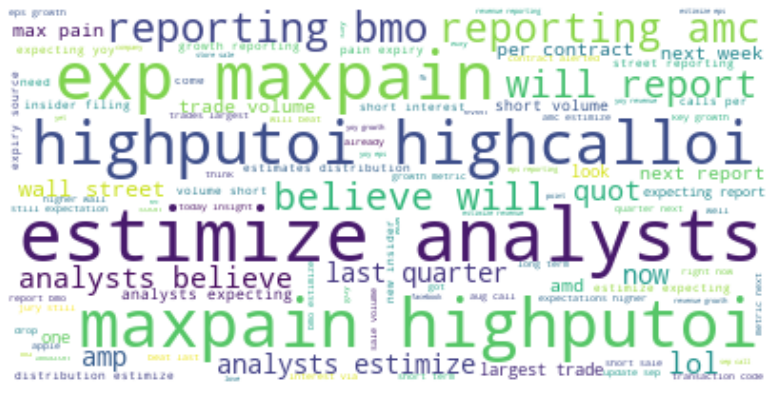

In [21]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(all_words)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=None, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [22]:
preprocessed[:2]

['  great buy at         ill wait', '   ']

In [23]:
tmp_dict = {'org message': messages, 'sentence': preprocessed, 'label': sentiments}
tmp_df = pd.DataFrame(tmp_dict)

# Ignore tweets having less than 10 words
tmp_df = tmp_df.loc[tmp_df['sentence'].apply(lambda x: len(x.split())) >= 10]
tmp_df.reset_index(drop=True, inplace=True)

# Samples
pd.set_option('display.max_colwidth', -1)
tmp_df.sample(n=20, random_state=42)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':


org message  ... label
396330  In terms of positives for $DVN, there are 2 bullish indicators as of 08-31 https://dividendbot.com?s=DVN                                                                                                                                                                                          ...  3   
340727  $INTU   to give the new management team a chance to beat expectations.                                                                                                                                                                                                                            ...  3   
108510  EARNING UPDATE $AXP American Express Company for quarter ending q_Jun18  - Revenue rose but Margins contracted http://abrcap.com/earning-up                                                                                                                                                       ...  3   
67195   $AMZN sick! they’re running a prime flash sale on shares too!                                                                                                                                                                                                                                     ...  4   
135982  $GM Now that some news about EU, will this go higher or still in the dog house?                                                                                                                                                                                                                   ...  4   
62392   #FANG stocks relative to $NDX $QQQ since mid-2014. $NFLX and $AMZN don&#39;t look sustainable.                                                                                                                                                                                                    ...  2   
503461  good thing they turned on all the buy programs I thought all $FANG stocks were about to crater yesterday $FB $AAPL $NFLX $GOOG $BABA $AMZN                                                                                                                                                        ...  4   
318002  $BTU $SO Trump Eases Coal-Pollution Curbs in Unwinding More Obama Rules via http://www.hvper.com/?ref=stw                                                                                                                                                                                         ...  2   
172641  $AAPL has a good Piotroski-F score of 7.00. This indicates a good health and profitability. https://www.chartmill.com/analyze.php?utm_source=stocktwits&amp;utm_medium=FA&amp;utm_content=PROFITABILITY&amp;utm_campaign=social_tracking#/AAPL?r=fa&amp;key=bb853040-a4ac-41c6-b549-d218d2f21b32  ...  2   
280427  $MCD Trump Appointees Urged to Bow Out of McDonald&#39;s Franchisee Fight https://wallmine.com/news/16ghok/trump-appointees-urged-to-bow-out-of-mcdonald-s-franchisee-fight?utm_source=stocktwits                                                                                                 ...  2   
53318   $AAPL $SPY $SPX $FB -- $AIR $ANGO $FAST Earnings season officially kicks off tomorrow! Already off to a good start ;) Msg for a free trial:D                                                                                                                                                      ...  2   
384319  $CLF THEY are almost back from lunch.  Snorted a couple of lines.  Now THEY are ready for round 3 off the a$$$ whooping.                                                                                                                                                                          ...  2   
327969  $FB got rid of this trash today, i admit that bears were right                                                                                                                                                                                                                   

In [24]:
# Change the table display config back
pd.set_option('display.max_colwidth', 50)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


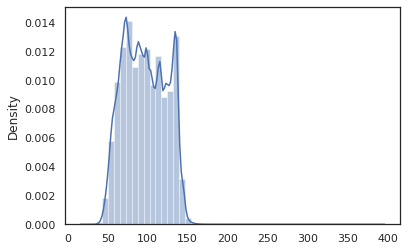

In [25]:
sns.distplot([len(x) for x in tmp_df['sentence']])

## Data Selection

The total number of data:  1548010


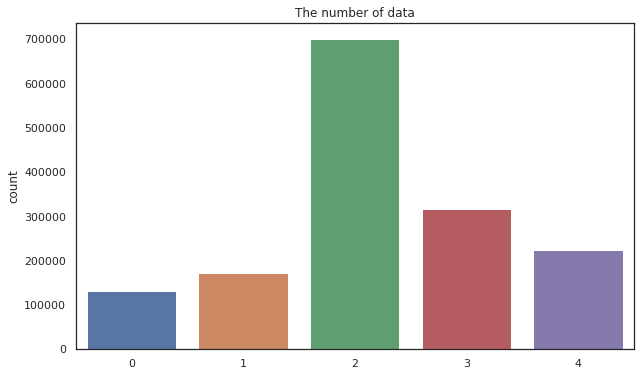

In [26]:
print("The total number of data: ", len(sentiments))
plt.figure(figsize=(10,6))
sns.countplot(x=sentiments)
plt.title('The number of data')
plt.show()

More than 60% of the data are labeled as "neutral". Sometimes imbalanced data are balanced using methods like resampling (oversampling, undersampling) as models tend to predict the majority class more. SMOTE or the Synthetic Minority Over-sampling Technique is a popular technique for oversampling but it is a statistical method for numerical data.

Here, take label = 0, 2, 4 and balance the data using random down sampling method.

In [27]:
# Take 0, 2, 4 and update them to 0, 1, 2
train_df = tmp_df.loc[(tmp_df['label']==int(0))|(tmp_df['label']==int(2))|(tmp_df['label']==int(4))]
def update_label(x):
    if x == int(2):
        return int(1)
    elif x == int(4):
        return int(2)
    else:
        return int(0)
train_df['label'] = train_df['label'].apply(lambda x: update_label(x))

# Balancing the data
n_negative = sum(1 for each in train_df['label'] if each == 0)
n_neutral = sum(1 for each in train_df['label'] if each == 1)
n_positive = sum(1 for each in train_df['label'] if each == 2)
N_examples = train_df.shape[0]

print('Negative:', n_negative/N_examples)
print('Neutral: ', n_neutral/N_examples)
print('Positive:', n_positive/N_examples)
print('Total records: ', N_examples)

balanced = {'org message': [], 'sentence': [], 'label': []}

# Keep probability
# As the negative has the least number of data, trim neutral and positive
keep_prob_neutral = n_negative/n_neutral
keep_prob_positive = n_negative/n_positive
#keep_prob = 1

for i, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    if row['sentence'].strip() == "":
        continue
    elif (row['label'] == 0) or ((row['label'] == 1) and (random.random() < keep_prob_neutral)) or ((row['label'] == 2) and (random.random() < keep_prob_positive)):
        balanced['org message'].append(row['org message'])
        balanced['sentence'].append(row['sentence'])
        balanced['label'].append(row['label'])

train_df = pd.DataFrame(balanced)
n_negative = sum(1 for each in train_df['label'] if each == 0)
n_neutral = sum(1 for each in train_df['label'] if each == 1)
n_positive = sum(1 for each in train_df['label'] if each == 2)
N_examples = len(train_df)

print('Negative:', n_negative/N_examples)
print('Neutral: ', n_neutral/N_examples)
print('Positive:', n_positive/N_examples)
print('Total records: ', N_examples)


Negative: 0.14340164994682228
Neutral:  0.6166585223298552
Positive: 0.2399398277233225
Total records:  521835


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.



Negative: 0.33367518928415363
Neutral:  0.33296620976875674
Positive: 0.33335860094708963
Total records:  224266


The total number of data:  224266


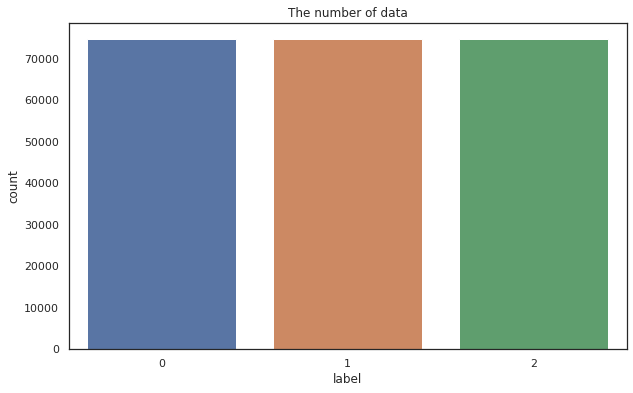

In [28]:
print("The total number of data: ", len(train_df))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,8))
sns.countplot(x='label', data=train_df, ax=ax1)
ax1.title('The number of data')
sns.distplot([len(x) for x in train_df['sentence']], ax=ax2)

plt.show()

# A. Lexicon-based Approach

## Add sentiment based on Loughran and McDonald Sentiment Word Lists

Use [Loughran and McDonald Sentiment Word Lists](https://sraf.nd.edu/textual-analysis/resources/) for sentiment analysis. Use the master word list, combined in two columns (sentiment and word).
<BR /> Note: This data requires the license to use for commercial application. Please check their website.

Download the list and save it under `lmdict_dir` as csv.

In [30]:
# Load sentiment data
sentiment_df = pd.read_csv(lmdict_dir + 'LoughranMcDonald_SentimentWordLists_2018.csv')

print(sentiment_df.shape)
sentiment_df

(4140, 2)


sentiment            word
0         Negative         ABANDON
1         Negative       ABANDONED
2         Negative      ABANDONING
3         Negative     ABANDONMENT
4         Negative    ABANDONMENTS
...            ...             ...
4135  Constraining        STRICTER
4136  Constraining       STRICTEST
4137  Constraining        STRICTLY
4138  Constraining  UNAVAILABILITY
4139  Constraining     UNAVAILABLE

[4140 rows x 2 columns]

In [31]:
# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

word
sentiment         
Constraining   184
Litigious      904
Negative      2355
Positive       354
StrongModal     19
Uncertainty    297
WeakModal       27

In [32]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

## Analyze the tone with negation without lemmatization

In [33]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [34]:

# Analyze tone for original text dataframe
print(train_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x.lower()) for x in tqdm(train_df['sentence'], total=train_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
train_tone_df = pd.concat([train_df, tone_lmdict_df.reindex(train_df.index)], axis=1)
train_tone_df.head()


(224266, 3)


org message  ... neg_words
0  $GME 3% drop per week after spike... if no new...  ...        []
1  $SNPS short ratio is 2.17 at 2018-06-15 and sh...  ...        []
2  $NFLX price squeezing,perfect place for an opt...  ...        []
3  @DEEPAKM2013 @Nytunes Start of new Q on Monday...  ...        []
4  $AMZN 3 catalysts 4 Continuing this new uptren...  ...   [break]

[5 rows x 9 columns]

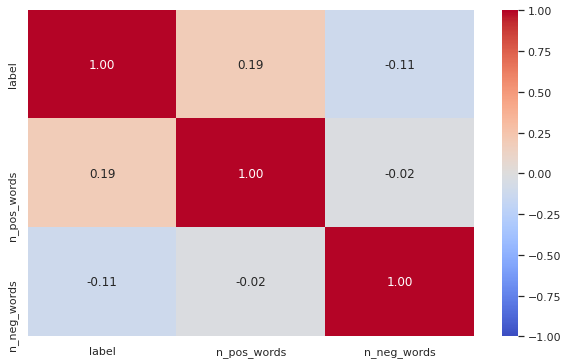

In [35]:
# Show corelations to next_decision
plt.figure(figsize=(10,6))
#corr_columns = ['label', 'tone_score', 'word_count', 'n_pos_words', 'n_neg_words']
corr_columns = ['label', 'n_pos_words', 'n_neg_words']
sns.heatmap(train_tone_df[corr_columns].astype(float).corr(), cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.show()

## Input Data

In [36]:
train_tone_df.columns

Index(['org message', 'sentence', 'label', 'tone_score', 'word_count',
       'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words'],
      dtype='object')

In [37]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = train_tone_df[['tone_score', 'n_pos_words', 'n_neg_words']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

## Train with different classifier

In [38]:
# Roughly check base classifiers without hyperparameter setting

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC

random_state = 2
classifiers = []
classifiers.append(("SVC", SVC(random_state=random_state)))
classifiers.append(("DecisionTree", DecisionTreeClassifier(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state, n_estimators=100)))
classifiers.append(("ExtraTrees", ExtraTreesClassifier(random_state=random_state)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("MultipleLayerPerceptron", MLPClassifier(random_state=random_state)))
classifiers.append(("KNeighboors", KNeighborsClassifier(n_neighbors=3)))
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))
classifiers.append(("GaussianNB", GaussianNB()))
classifiers.append(("Perceptron", Perceptron()))
classifiers.append(("LinearSVC", LinearSVC()))
classifiers.append(("SGD", SGDClassifier()))

classifiers

[('SVC',
  SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, probability=False, random_state=2, shrinking=True, tol=0.001,
      verbose=False)),
 ('DecisionTree',
  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=2, splitter='best')),
 ('AdaBoost', AdaBoostClassifier(algorithm='SAMME.R',
                     base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                           class_weight=None,
                                                           criterion='gi

In [39]:
pd.DataFrame([rec[0] for rec in classifiers])

0
0                          SVC
1                 DecisionTree
2                     AdaBoost
3                 RandomForest
4                   ExtraTrees
5             GradientBoosting
6      MultipleLayerPerceptron
7                  KNeighboors
8           LogisticRegression
9   LinearDiscriminantAnalysis
10                  GaussianNB
11                  Perceptron
12                   LinearSVC
13                         SGD

In [41]:
# cv_results = []
# classifier_name = []
# for classifier in tqdm(classifiers, desc='classifiers'):
#     cv_results.append(cross_validate(classifier[1], X_train, y = Y_train, scoring = ["accuracy", "f1_macro"], cv = kfold, n_jobs=4))
#     classifier_name.append(classifier[0])

# cv_acc_means = []
# cv_acc_std = []
# cv_f1_means = []
# cv_f1_std = []
# for cv_result in cv_results:
#     cv_acc_means.append(cv_result['test_accuracy'].mean())
#     cv_acc_std.append(cv_result['test_accuracy'].std())
#     cv_f1_means.append(cv_result['test_f1_macro'].mean())
#     cv_f1_std.append(cv_result['test_f1_macro'].std())

# cv_res = pd.DataFrame({"Algorithm": classifier_name,
#                        "CVAccMeans":cv_acc_means,
#                        "CVAccErrors": cv_acc_std,
#                        "CVf1Means":cv_f1_means,
#                        "CVf1Errors": cv_f1_std})

# cv_res.sort_values(by='CVAccMeans', ascending=False)

KeyboardInterrupt: ignored

In [ ]:
# # Accuracy Score Graph
# plt.figure(figsize=(18,10))
# ax = sns.barplot("CVAccMeans","Algorithm",data=cv_res.sort_values(by='CVAccMeans', ascending=False), palette="Set3", orient="h", **{'xerr':cv_acc_std})
# ax.set_xlabel("Mean Accuracy", size=16)
# ax.set_title("Cross validation scores", size=20)

In [ ]:
# # F1 Score Graph
# plt.figure(figsize=(18,10))
# ax = sns.barplot("CVf1Means","Algorithm",data=cv_res.sort_values(by='CVf1Means', ascending=False), palette="Set3", orient="h", **{'xerr':cv_f1_std})
# ax.set_xlabel("Mean f1 score (f1 macro)", size=16)
# ax.set_title("Cross validation scores", size=20)

## Train with Grid Search Cross Validation

In [42]:
# Train and visualisation Function

def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Negative', 'Neutral', 'Positive']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


Fitting 7 folds for each of 480 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 966 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1472 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 2102 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 2818 tasks      | elapsed: 36.5min
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed: 44.5min finished


Best Score:  0.3876367159565431
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 1}


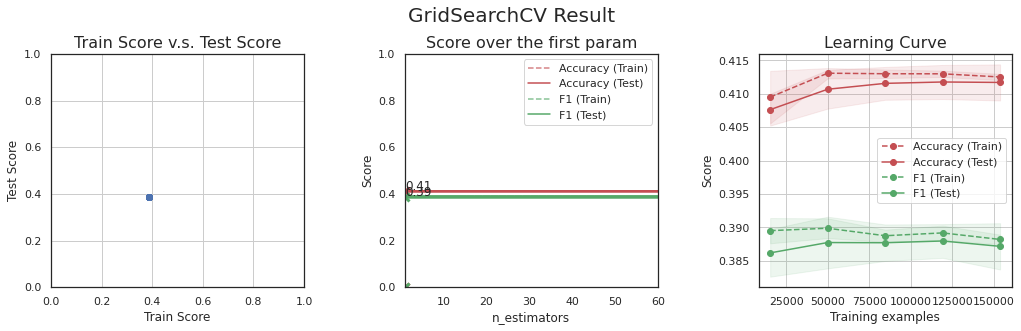

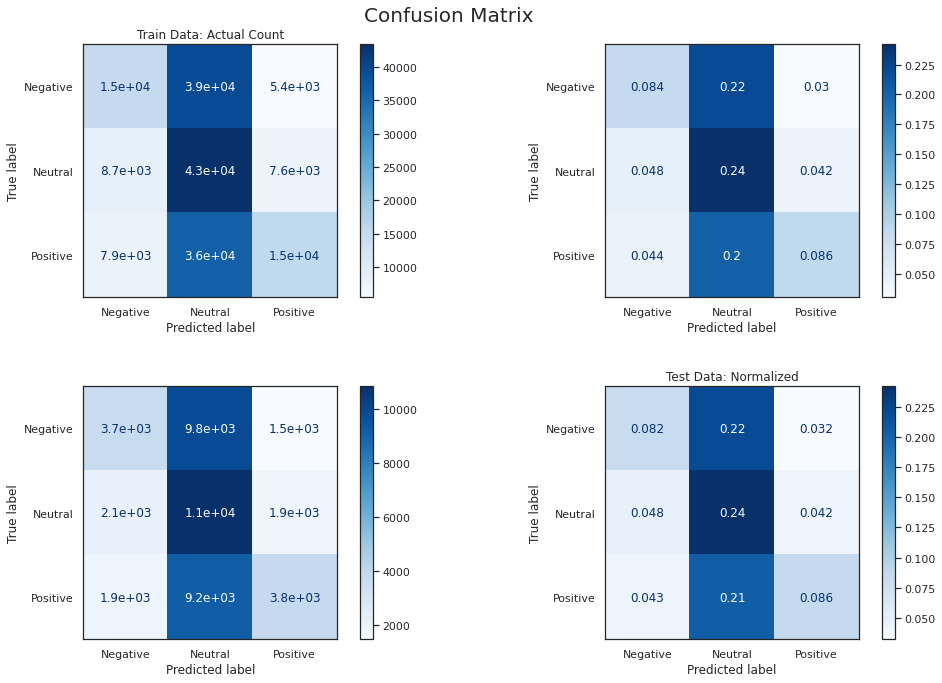

In [43]:
# Use Random Forest Classifier
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [1, 3, 5, 10],
              'min_samples_leaf': [1, 2, 3, 5],
              'max_features': [1, 2, 3],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

## Result
The prediction is not good at all. Hyper parameter tuning of Random Forest could not beat the simple model of Linear Discriminant Analysis. 
Confusion matrix shows almost all the data have been labeled as "neutral", the majority class.

In [44]:
pred_test = rf_best.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['A: Lexicon'] = (round(acc,4), round(f1,4))
result_df

Accuracy      F1
A: Lexicon       0.4101  0.3854
B: Tfidf            NaN     NaN
C1: LSTM            NaN     NaN
C2: LSTM+GloVe      NaN     NaN
D1: BERT            NaN     NaN
D2: ALBERT          NaN     NaN

Text(0.5, 1.0, 'Feature importance')

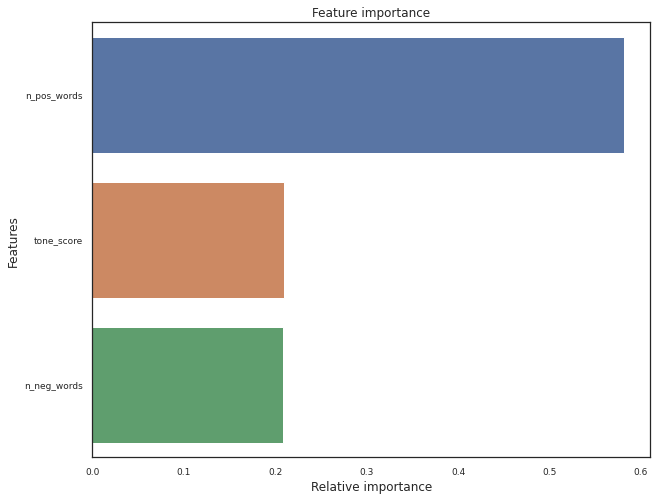

In [45]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")


# B. Tfidf

### Tokenizer

In [46]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    Mode:
        1: NLTK word_tokenize(), Stop words removal, Alphabet only, Lemmetize
        2: NLTK word_tokenize(), Stop words removal, Alphabet only, Do not lemmetize
        3: NLTK word_tokenize(), Do not remove stop words, Alphabet only, Do not lemmetize
        4: (alphabet + "'s" + "'t")

    '''
    tokenized = []
    for text in tqdm(df[col]):
        # Filter alphabet words only , make it loser case
        if tokenizer=='NLTK':
            words = [word.lower() for word in word_tokenize(text) if (word.isalpha()==1)]
        else:
            words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())

        # Remove stop words
        if stopwords:
             words = [word for word in words if (word not in stop)]
        # Lemmatize words
        if lemma:
            tokens = [lemmatize_word(word) for word in words]
            tokenized.append(tokens)
        else:
            tokenized.append(words)

    # Concat the list to create docs
    tokenized_text = [" ".join(words) for words in tokenized]

    # Create a list of all the words in the dataframe
    all_words = [word for text in tokenized for word in text]

    # Counter object of all the words
    counts = Counter(all_words)

    # Create a Bag of Word, sorted by the count of words
    bow = sorted(counts, key=counts.get, reverse=True)

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    # Create token id list
    token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

    return tokenized, tokenized_text, bow, vocab, id2vocab, token_ids


In [47]:
# Lemmatize sentiment (not used)

# # pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
# # sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# # Lemmertize sentiment words as well
# lemma_sentiment_df = sentiment_df.copy(deep=True)
# lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# # Drop duplicates
# lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# # Sentiment list
# lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

# lemma_sentiment_df.groupby(by=['sentiment']).count()

## Tokenise input texts

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


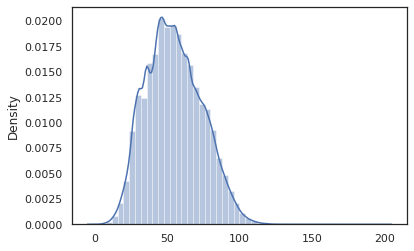

In [48]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_tone_df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK')
sns.distplot([len(x) for x in tokenized_text])


In [49]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = tokenized_text

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data, Y_data.values, test_size=0.2, shuffle=True)

## Model and Train (Logistic Regression)


In [50]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', LogisticRegression())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Model and Train (Random Forest)

In [51]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

In [52]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

# Perform Grid Search
param_grid = {'clf__n_estimators': [10, 50, 100, 150, 200],
              'clf__min_samples_leaf': [1, 2],
              'clf__min_samples_split': [4, 6],
              'clf__max_features': ['auto']
             }

tfidf_model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
tfidf_best = tfidf_model.best_estimator_

Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: ignored

## Result
Much better than lexicon approach. Apparently it overfitting to the training set.

In [ ]:
pred_test = tfidf_best.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['B: Tfidf'] = (round(acc,4), round(f1,4))
result_df

# C1. LSTM (RNN)
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

<table><tr><td><img src="./docs/lstm_4.png" width=450></td><td><img src="./docs/lstm_1.png" width=300></td></tr></table>


In [53]:
# Import Pytorch modules
# import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, AdamW

### Tokenise input texts

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


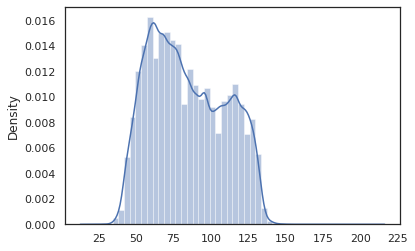

In [54]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_tone_df, col='sentence', lemma=False, stopwords=False, tokenizer='Own')
sns.distplot([len(x) for x in tokenized_text])


In [55]:
# # Split data into training and validation datasets. Use an appropriate split size.

# split_frac = 0.8

# split_idx = int(len(token_ids)*split_frac)

# train_features = token_ids[:split_idx]
# valid_features = token_ids[split_idx:]
# train_labels = Y_data[:split_idx]
# valid_labels = Y_data[split_idx:]

# print("len(token_ids): ", len(token_ids))
# print("len(train_features): ", len(train_features))
# print("len(valid_features): ", len(valid_features))
# print("len(train_labels): ", len(train_labels))
# print("len(valid_labels): ", len(valid_labels))

# X and Y data used
y_data = train_tone_df['label']
X_data = token_ids

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, y_train, y_test = \
model_selection.train_test_split(X_data, y_data.values, test_size=0.2, shuffle=True)

### Define Model
#### Embed -> RNN -> Dense -> Softmax

In [56]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, output_size, lstm_layers=2, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.dense_size = dense_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(dropout)

        if dense_size == 0:
            self.fc = nn.Linear(lstm_size, output_size)
        else:
            self.fc1 = nn.Linear(lstm_size, dense_size)
            self.fc2 = nn.Linear(dense_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        if self.dense_size == 0:
            out = self.fc(lstm_out)
        else:
            dense_out = self.fc1(lstm_out)
            out = self.fc2(dense_out)
        # Softmax
        logps = self.softmax(out)

        return logps, hidden_state

### DataLoaders and Batching

Here, I used own dataloader. It's also fine to use tensorflow/keras or pytorch implementation.

In [57]:
def dataloader(messages, labels, sequence_length=200, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

In [58]:
# Test the model
text_batch, labels = next(iter(dataloader(X_train, y_train)))
lstm_model = TextClassifier(len(vocab), 512, 128, 8, 3)
hidden = lstm_model.init_hidden(16)
logps, hidden = lstm_model.forward(text_batch, hidden)
print(logps)

tensor([[-1.1420, -1.0240, -1.1342],
        [-1.1475, -1.0048, -1.1505],
        [-1.1235, -1.0267, -1.1499],
        [-1.1236, -1.0270, -1.1495],
        [-1.1594, -1.0065, -1.1369],
        [-1.1097, -1.0200, -1.1720],
        [-1.1196, -1.0269, -1.1536],
        [-1.1314, -1.0440, -1.1228],
        [-1.1291, -1.0117, -1.1613],
        [-1.1153, -1.0113, -1.1763],
        [-1.1141, -1.0339, -1.1515],
        [-1.1317, -1.0095, -1.1613],
        [-1.1479, -1.0174, -1.1358],
        [-1.1210, -1.0175, -1.1630],
        [-1.1338, -1.0215, -1.1452],
        [-1.1403, -1.0227, -1.1374]], grad_fn=<LogSoftmaxBackward>)


### Configure the model and train!

In [59]:
# Define the training process

def train_lstm_model(lstm_model, X_train, y_train, X_valid, y_valid, epochs, batch_size, learning_rate, sequence_length, patience, clip, print_every, print_epoch):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize Model
    lstm_model.embedding.weight.data.uniform_(-1, 1)
    lstm_model.to(device)

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    lstm_model.train()

    # Initialise
    accuracy = []
    f1_score = []
    best_f1, early_stop = 0, 0
    
    class_names = ['Negative', 'Neutral', 'Positive']


    # Validation steup
    def do_vadalition(valid_hidden):
        lstm_model.eval()
        valid_losses = []
        y_predicted = []
        y_truth = []
        # valid_hidden = lstm_model.init_hidden(batch_size)

        for text_batch, labels in dataloader(
                X_valid, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):

            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Initialize within the loop to use label shape if batch_size did not work
            # valid_hidden = lstm_model.init_hidden(labels.shape[0])

            # Creating new variables for the hidden state
            valid_hidden = tuple([each.data for each in valid_hidden])

            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in valid_hidden:
                each.to(device)

            # Get output and hidden state from the model
            valid_output, _ = lstm_model(text_batch, valid_hidden)

            # Calculate the loss     
            valid_loss = criterion(valid_output.squeeze(), labels)
            valid_losses.append(valid_loss.item())

            # Prediction
            ps = torch.exp(valid_output)
            top_p, top_class = ps.topk(1, dim=1)
            # equals = top_class == labels.view(*top_class.shape)
            # accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

            y_predicted.extend(top_class.squeeze().cpu().numpy())
            y_truth.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

        lstm_model.train()

        return y_truth, y_predicted, valid_losses

    # Training cycle
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # print('Starting epoch {}'.format(epoch + 1))
        hidden = lstm_model.init_hidden(batch_size)
        steps = 0

        for text_batch, labels in dataloader(
                X_train, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
            steps += 1
            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state to avoid backprop entire training history
            hidden = tuple([each.data for each in hidden])
        
            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)
        
            # optimizer.zero_grad()
            lstm_model.zero_grad()
        
            # Get output and hidden state from the model
            output, hidden = lstm_model(text_batch, hidden)

            # Calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(lstm_model.parameters(), clip)

            # Optimize
            optimizer.step()

            if steps % print_every == 0:
                y_truth, y_predicted, valid_losses = do_vadalition(hidden)
                acc, f1 = metric(y_truth, y_predicted)
                print("Epoch: {}/{}".format(epoch+1, epochs),
                      "Step: {}...".format(steps),
                      "Loss: {:.6f}".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                      "Accuracy: {:.6f}".format(acc),
                      "F1 Score: {:.6f}".format(f1))

        # End of epoch evaluation
        y_truth, y_predicted, valid_losses = do_vadalition(hidden)
        acc, f1 = metric(y_truth, y_predicted)
        
        if print_epoch:
            print("Completed {} steps in epoch {}".format(steps, epoch+1))
            

            # Plot Confusion Matrix
            y_truth_class = [class_names[int(idx)] for idx in y_truth]
            y_predicted_class = [class_names[int(idx)] for idx in y_predicted]
            
            titles_options = [("Actual Count", None), ("Normalised", 'true')]
            for title, normalize in titles_options:
                disp = skplt.metrics.plot_confusion_matrix(y_truth_class, y_predicted_class, normalize=normalize, title=title)
            plt.show()

            print("\nEpoch: %d, Accuracy: %.8f, F1: %.8f\n" % (epoch+1, acc, f1))

        # If not improving, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
        else:
            early_stop += 1
                
        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

    # Post process
    y_truth, y_predicted, valid_losses = do_vadalition(hidden)
    acc, f1 = metric(y_truth, y_predicted)
    print("Completed all epochs")
    print("Accuracy: %.8f, F1: %.8f" % (acc, f1))

    return acc, f1

In [60]:
# Set Hyperparameters

# for Training
epochs=5
batch_size=64
learning_rate=3e-4
sequence_length=48
dropout=0.1
patience=3
clip=5
print_every=1000
print_epoch=True

# Model parameters
embed_size=512
lstm_size=128
dense_size=0
lstm_layers=2

########## STARTING FOLD 1 ##########


Epoch: 1/15 Step: 1000... Loss: 0.374902 Val Loss: 0.462983 Accuracy: 0.826842 F1 Score: 0.826312
Epoch: 1/15 Step: 2000... Loss: 0.288091 Val Loss: 0.380507 Accuracy: 0.859877 F1 Score: 0.859446
Completed 2243 steps in epoch 1


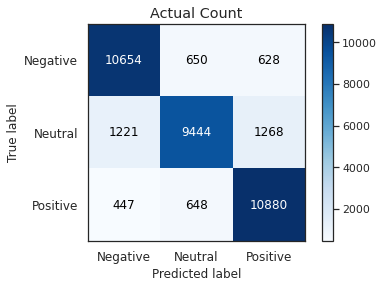

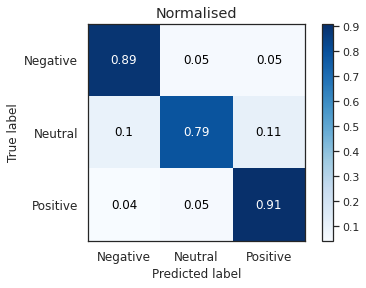


Epoch: 1, Accuracy: 0.86434152, F1: 0.86355992

Epoch: 2/15 Step: 1000... Loss: 0.297773 Val Loss: 0.345872 Accuracy: 0.874581 F1 Score: 0.873918
Epoch: 2/15 Step: 2000... Loss: 0.223320 Val Loss: 0.331701 Accuracy: 0.880748 F1 Score: 0.880337
Completed 2243 steps in epoch 2


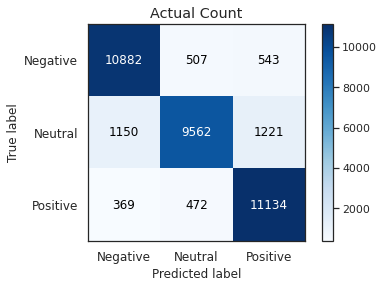

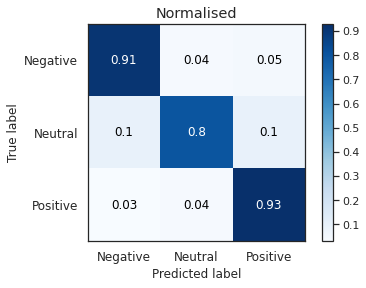


Epoch: 2, Accuracy: 0.88108259, F1: 0.88021001

Epoch: 3/15 Step: 1000... Loss: 0.224660 Val Loss: 0.315757 Accuracy: 0.886049 F1 Score: 0.885433
Epoch: 3/15 Step: 2000... Loss: 0.200134 Val Loss: 0.327598 Accuracy: 0.887081 F1 Score: 0.886784
Completed 2243 steps in epoch 3


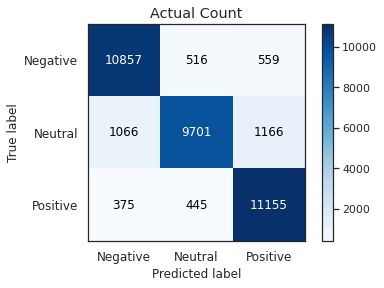

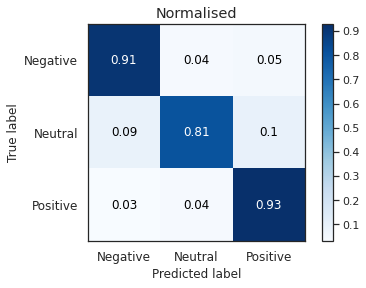


Epoch: 3, Accuracy: 0.88484933, F1: 0.88415115

Epoch: 4/15 Step: 1000... Loss: 0.146072 Val Loss: 0.313106 Accuracy: 0.891127 F1 Score: 0.890608
Epoch: 4/15 Step: 2000... Loss: 0.146492 Val Loss: 0.345168 Accuracy: 0.886384 F1 Score: 0.886139
Completed 2243 steps in epoch 4


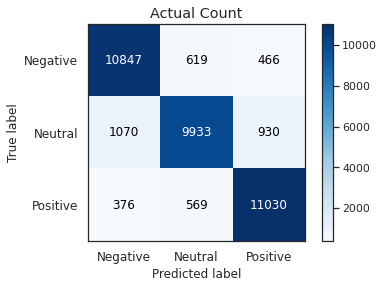

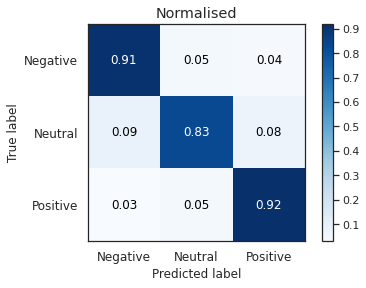


Epoch: 4, Accuracy: 0.88755580, F1: 0.88709948

Epoch: 5/15 Step: 1000... Loss: 0.103491 Val Loss: 0.331909 Accuracy: 0.889676 F1 Score: 0.889253
Epoch: 5/15 Step: 2000... Loss: 0.150770 Val Loss: 0.354613 Accuracy: 0.888086 F1 Score: 0.887783
Completed 2243 steps in epoch 5


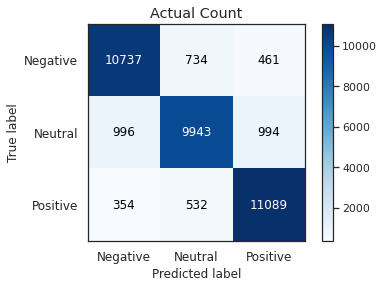

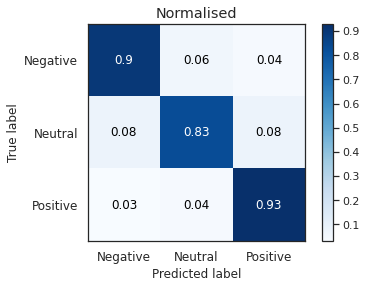


Epoch: 5, Accuracy: 0.88641183, F1: 0.88595622

Epoch: 6/15 Step: 1000... Loss: 0.061265 Val Loss: 0.369000 Accuracy: 0.887137 F1 Score: 0.886501
Epoch: 6/15 Step: 2000... Loss: 0.157363 Val Loss: 0.386019 Accuracy: 0.886272 F1 Score: 0.885706
Completed 2243 steps in epoch 6


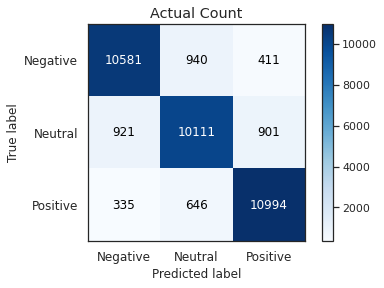

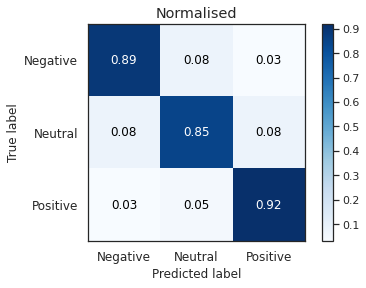


Epoch: 6, Accuracy: 0.88409598, F1: 0.88388663

Epoch: 7/15 Step: 1000... Loss: 0.052794 Val Loss: 0.405871 Accuracy: 0.885212 F1 Score: 0.884803
Epoch: 7/15 Step: 2000... Loss: 0.117557 Val Loss: 0.418003 Accuracy: 0.885910 F1 Score: 0.885769
Completed 2243 steps in epoch 7


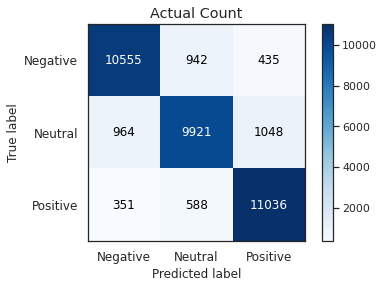

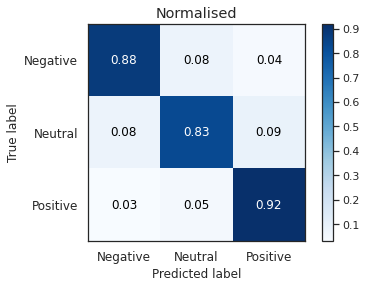


Epoch: 7, Accuracy: 0.87924107, F1: 0.87884927

Epoch: 8/15 Step: 1000... Loss: 0.044889 Val Loss: 0.439829 Accuracy: 0.884905 F1 Score: 0.884434
Epoch: 8/15 Step: 2000... Loss: 0.092159 Val Loss: 0.464093 Accuracy: 0.885240 F1 Score: 0.885018
Completed 2243 steps in epoch 8


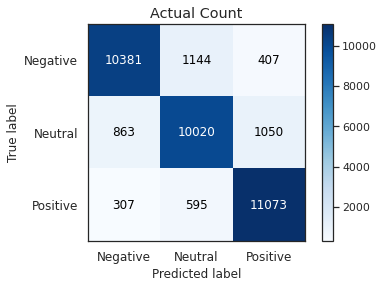

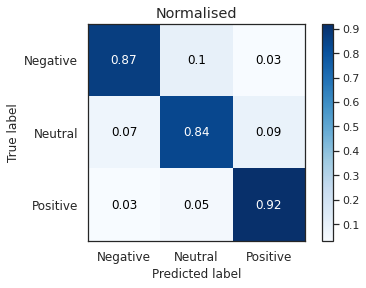


Epoch: 8, Accuracy: 0.87818080, F1: 0.87790601

Epoch: 9/15 Step: 1000... Loss: 0.019572 Val Loss: 0.499595 Accuracy: 0.882394 F1 Score: 0.882283
Epoch: 9/15 Step: 2000... Loss: 0.054638 Val Loss: 0.503612 Accuracy: 0.881278 F1 Score: 0.881158
Completed 2243 steps in epoch 9


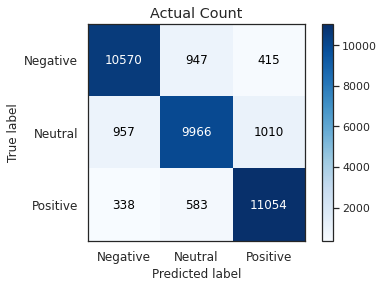

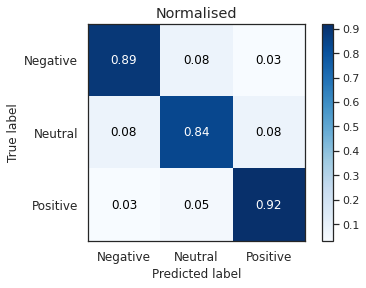


Epoch: 9, Accuracy: 0.88141741, F1: 0.88105086

Completed all epochs
Accuracy: 0.88141741, F1: 0.88105086
########## STARTING FOLD 2 ##########


Epoch: 1/15 Step: 1000... Loss: 0.505035 Val Loss: 0.453835 Accuracy: 0.829967 F1 Score: 0.829681
Epoch: 1/15 Step: 2000... Loss: 0.347049 Val Loss: 0.372571 Accuracy: 0.863756 F1 Score: 0.863298
Completed 2243 steps in epoch 1


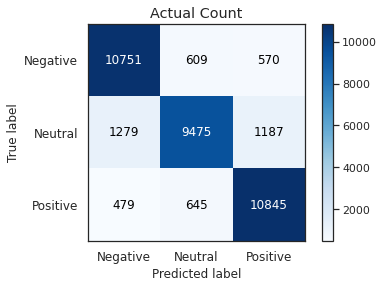

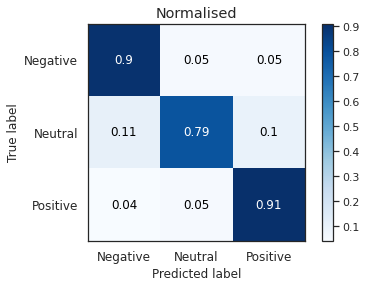


Epoch: 1, Accuracy: 0.86693638, F1: 0.86615922

Epoch: 2/15 Step: 1000... Loss: 0.289312 Val Loss: 0.342729 Accuracy: 0.874442 F1 Score: 0.873674
Epoch: 2/15 Step: 2000... Loss: 0.224168 Val Loss: 0.322520 Accuracy: 0.880831 F1 Score: 0.880377
Completed 2243 steps in epoch 2


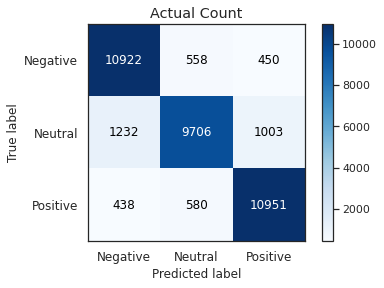

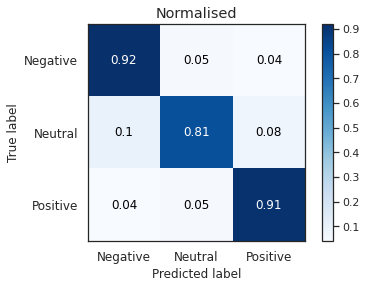


Epoch: 2, Accuracy: 0.88111049, F1: 0.88045776

Epoch: 3/15 Step: 1000... Loss: 0.233408 Val Loss: 0.320230 Accuracy: 0.883705 F1 Score: 0.883143
Epoch: 3/15 Step: 2000... Loss: 0.210492 Val Loss: 0.320495 Accuracy: 0.885938 F1 Score: 0.885580
Completed 2243 steps in epoch 3


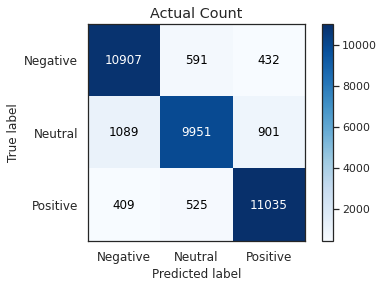

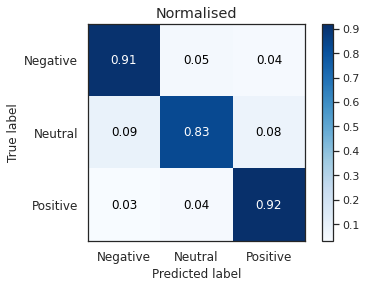


Epoch: 3, Accuracy: 0.88987165, F1: 0.88941916

Epoch: 4/15 Step: 1000... Loss: 0.181470 Val Loss: 0.322440 Accuracy: 0.888560 F1 Score: 0.888132
Epoch: 4/15 Step: 2000... Loss: 0.246203 Val Loss: 0.329329 Accuracy: 0.891016 F1 Score: 0.890528
Completed 2243 steps in epoch 4


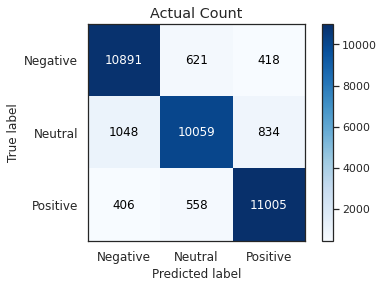

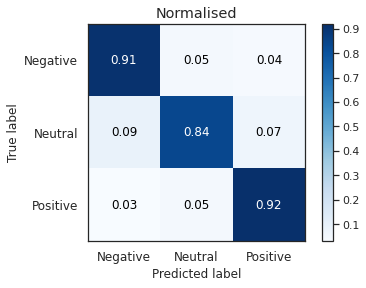


Epoch: 4, Accuracy: 0.89160156, F1: 0.89125686

Epoch: 5/15 Step: 1000... Loss: 0.152913 Val Loss: 0.343568 Accuracy: 0.889397 F1 Score: 0.888894
Epoch: 5/15 Step: 2000... Loss: 0.156714 Val Loss: 0.350490 Accuracy: 0.891657 F1 Score: 0.891269
Completed 2243 steps in epoch 5


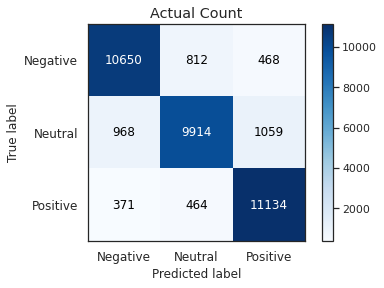

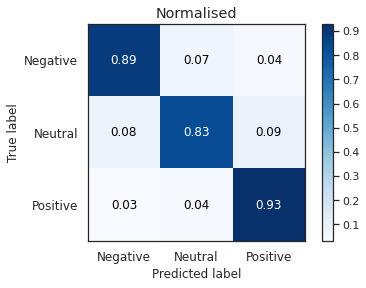


Epoch: 5, Accuracy: 0.88443080, F1: 0.88393692

Epoch: 6/15 Step: 1000... Loss: 0.131581 Val Loss: 0.361677 Accuracy: 0.888002 F1 Score: 0.887586
Epoch: 6/15 Step: 2000... Loss: 0.217555 Val Loss: 0.395718 Accuracy: 0.887723 F1 Score: 0.887665
Completed 2243 steps in epoch 6


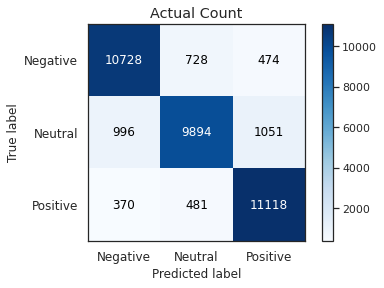

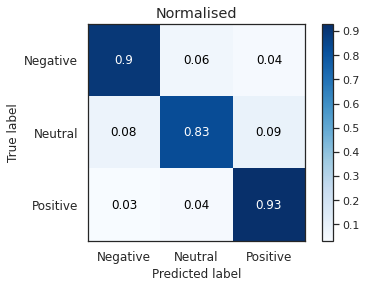


Epoch: 6, Accuracy: 0.88560268, F1: 0.88509124

Epoch: 7/15 Step: 1000... Loss: 0.088846 Val Loss: 0.401914 Accuracy: 0.886970 F1 Score: 0.886495
Epoch: 7/15 Step: 2000... Loss: 0.130870 Val Loss: 0.412601 Accuracy: 0.887640 F1 Score: 0.887393
Completed 2243 steps in epoch 7


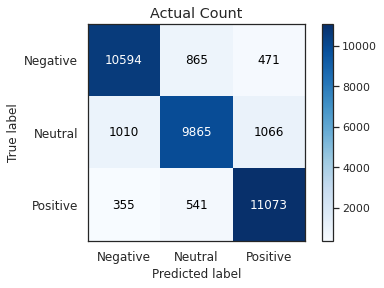

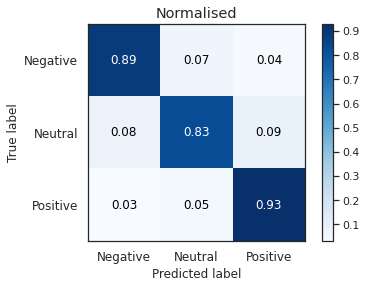


Epoch: 7, Accuracy: 0.87979911, F1: 0.87931328

Epoch: 8/15 Step: 1000... Loss: 0.056544 Val Loss: 0.439092 Accuracy: 0.881362 F1 Score: 0.880823
Epoch: 8/15 Step: 2000... Loss: 0.105990 Val Loss: 0.468336 Accuracy: 0.886942 F1 Score: 0.886820
Completed 2243 steps in epoch 8


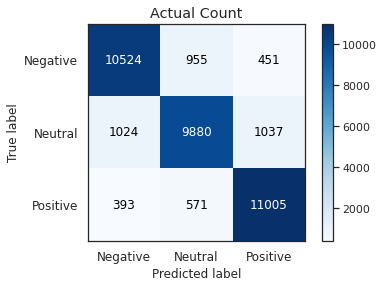

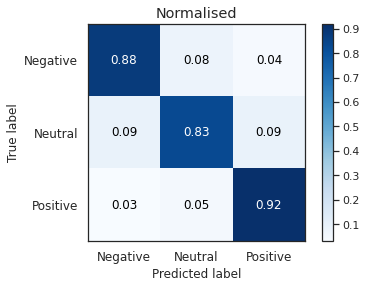


Epoch: 8, Accuracy: 0.87636719, F1: 0.87595455

Epoch: 9/15 Step: 1000... Loss: 0.049530 Val Loss: 0.491811 Accuracy: 0.884291 F1 Score: 0.883949
Epoch: 9/15 Step: 2000... Loss: 0.070577 Val Loss: 0.505500 Accuracy: 0.884431 F1 Score: 0.884264
Completed 2243 steps in epoch 9


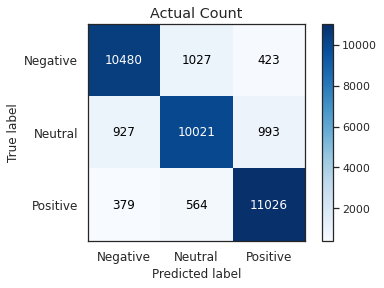

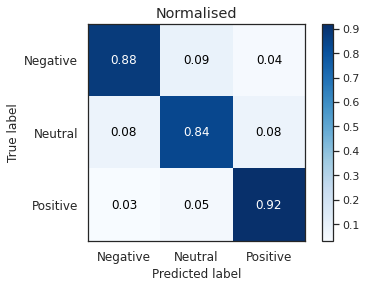


Epoch: 9, Accuracy: 0.87965960, F1: 0.87936224

Completed all epochs
Accuracy: 0.87965960, F1: 0.87936224
########## STARTING FOLD 3 ##########


Epoch: 1/15 Step: 1000... Loss: 0.482097 Val Loss: 0.445678 Accuracy: 0.834515 F1 Score: 0.834406
Epoch: 1/15 Step: 2000... Loss: 0.348073 Val Loss: 0.375257 Accuracy: 0.864007 F1 Score: 0.863674
Completed 2243 steps in epoch 1


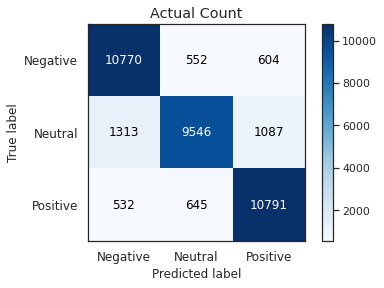

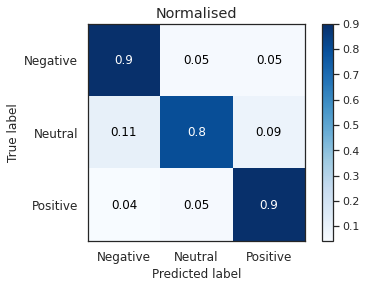


Epoch: 1, Accuracy: 0.86794085, F1: 0.86729309

Epoch: 2/15 Step: 1000... Loss: 0.301111 Val Loss: 0.336527 Accuracy: 0.877037 F1 Score: 0.876583
Epoch: 2/15 Step: 2000... Loss: 0.259368 Val Loss: 0.322839 Accuracy: 0.884542 F1 Score: 0.884244
Completed 2243 steps in epoch 2


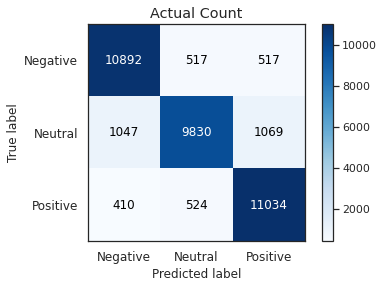

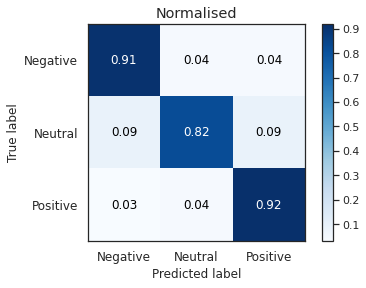


Epoch: 2, Accuracy: 0.88604911, F1: 0.88551112

Epoch: 3/15 Step: 1000... Loss: 0.266886 Val Loss: 0.315119 Accuracy: 0.887054 F1 Score: 0.886756
Epoch: 3/15 Step: 2000... Loss: 0.181827 Val Loss: 0.310219 Accuracy: 0.889760 F1 Score: 0.889388
Completed 2243 steps in epoch 3


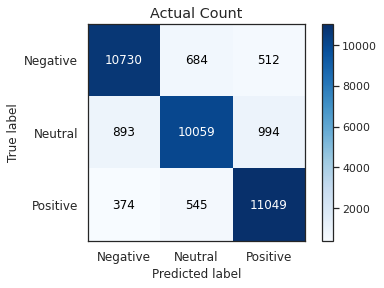

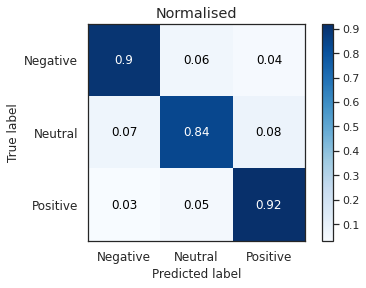


Epoch: 3, Accuracy: 0.88833705, F1: 0.88801471

Epoch: 4/15 Step: 1000... Loss: 0.247918 Val Loss: 0.320319 Accuracy: 0.889732 F1 Score: 0.889535
Epoch: 4/15 Step: 2000... Loss: 0.117467 Val Loss: 0.319422 Accuracy: 0.890513 F1 Score: 0.890102
Completed 2243 steps in epoch 4


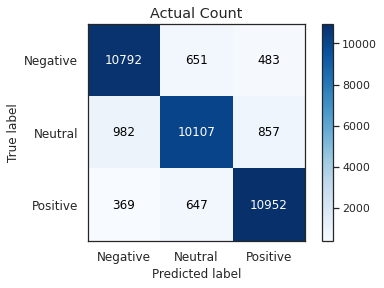

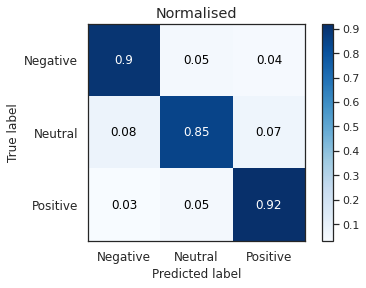


Epoch: 4, Accuracy: 0.88869978, F1: 0.88843314

Epoch: 5/15 Step: 1000... Loss: 0.190143 Val Loss: 0.340774 Accuracy: 0.887444 F1 Score: 0.887226
Epoch: 5/15 Step: 2000... Loss: 0.088991 Val Loss: 0.343446 Accuracy: 0.886021 F1 Score: 0.885432
Completed 2243 steps in epoch 5


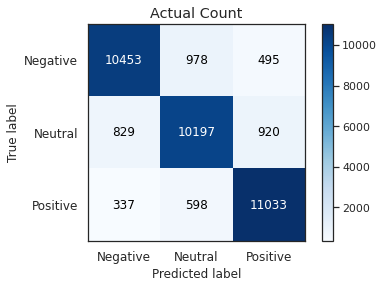

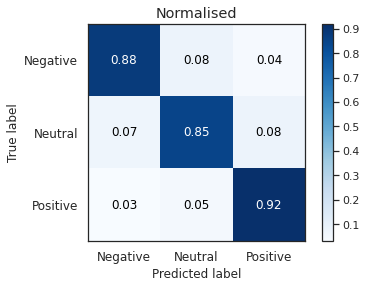


Epoch: 5, Accuracy: 0.88401228, F1: 0.88382847

Epoch: 6/15 Step: 1000... Loss: 0.113596 Val Loss: 0.370270 Accuracy: 0.885575 F1 Score: 0.885331
Epoch: 6/15 Step: 2000... Loss: 0.086902 Val Loss: 0.362962 Accuracy: 0.888951 F1 Score: 0.888702
Completed 2243 steps in epoch 6


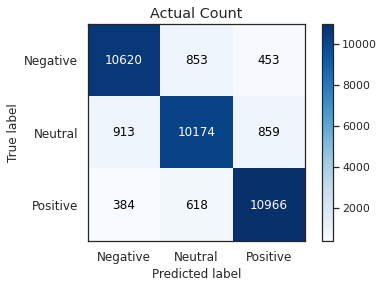

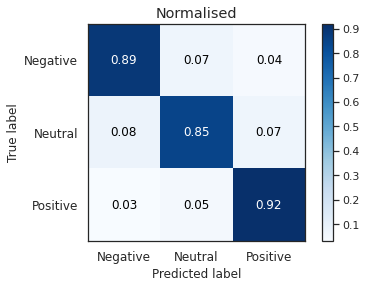


Epoch: 6, Accuracy: 0.88616071, F1: 0.88597380

Epoch: 7/15 Step: 1000... Loss: 0.090846 Val Loss: 0.397287 Accuracy: 0.882785 F1 Score: 0.882266
Epoch: 7/15 Step: 2000... Loss: 0.040960 Val Loss: 0.422475 Accuracy: 0.882310 F1 Score: 0.882206
Completed 2243 steps in epoch 7


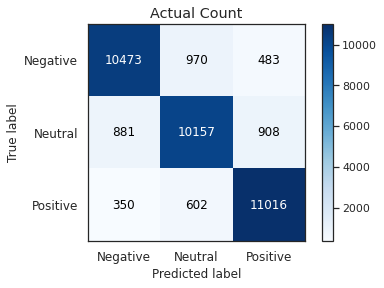

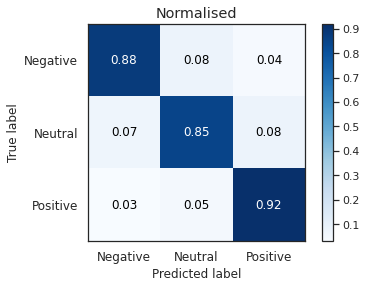


Epoch: 7, Accuracy: 0.88297991, F1: 0.88277613

Epoch: 8/15 Step: 1000... Loss: 0.071446 Val Loss: 0.436842 Accuracy: 0.884431 F1 Score: 0.884105
Epoch: 8/15 Step: 2000... Loss: 0.053741 Val Loss: 0.447473 Accuracy: 0.883036 F1 Score: 0.882727
Completed 2243 steps in epoch 8


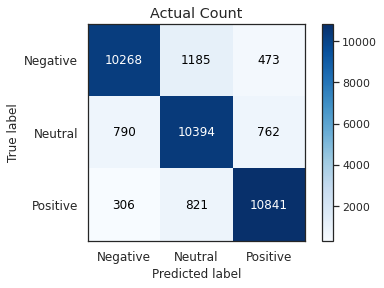

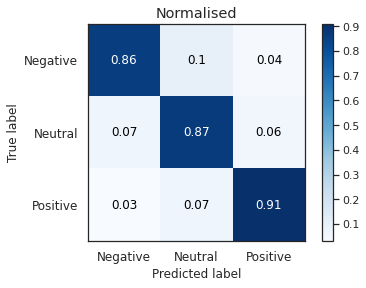


Epoch: 8, Accuracy: 0.87898996, F1: 0.87912405

Epoch: 9/15 Step: 1000... Loss: 0.038568 Val Loss: 0.490616 Accuracy: 0.880525 F1 Score: 0.880436
Epoch: 9/15 Step: 2000... Loss: 0.051369 Val Loss: 0.489855 Accuracy: 0.881780 F1 Score: 0.881685
Completed 2243 steps in epoch 9


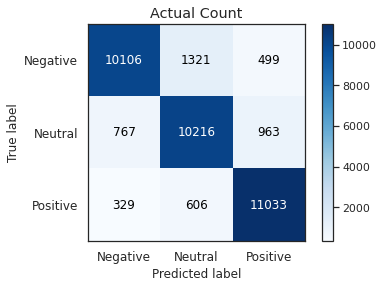

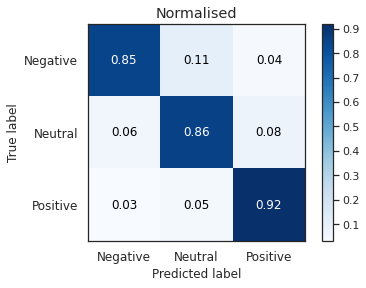


Epoch: 9, Accuracy: 0.87486049, F1: 0.87470744

Completed all epochs
Accuracy: 0.87486049, F1: 0.87470744
########## STARTING FOLD 4 ##########


Epoch: 1/15 Step: 1000... Loss: 0.316863 Val Loss: 0.465115 Accuracy: 0.826618 F1 Score: 0.826699
Epoch: 1/15 Step: 2000... Loss: 0.412721 Val Loss: 0.381170 Accuracy: 0.862221 F1 Score: 0.861845
Completed 2243 steps in epoch 1


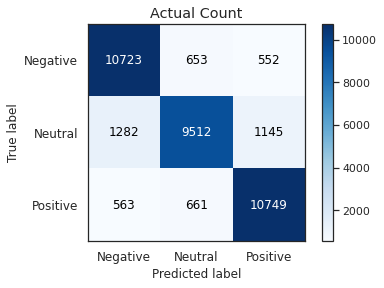

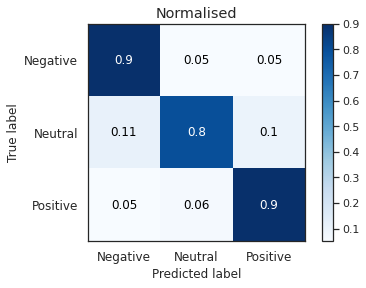


Epoch: 1, Accuracy: 0.86450893, F1: 0.86384623

Epoch: 2/15 Step: 1000... Loss: 0.185421 Val Loss: 0.351393 Accuracy: 0.873298 F1 Score: 0.872891
Epoch: 2/15 Step: 2000... Loss: 0.262202 Val Loss: 0.329851 Accuracy: 0.880162 F1 Score: 0.879798
Completed 2243 steps in epoch 2


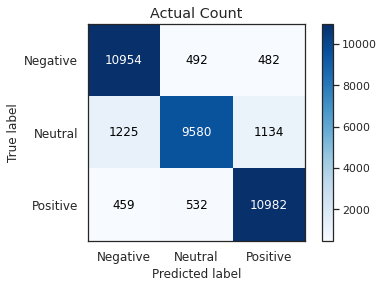

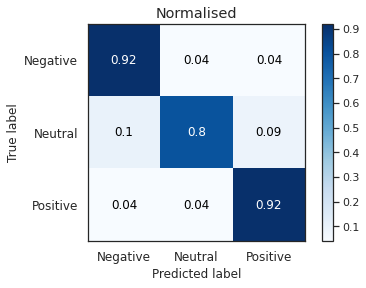


Epoch: 2, Accuracy: 0.87935268, F1: 0.87854408

Epoch: 3/15 Step: 1000... Loss: 0.170196 Val Loss: 0.327115 Accuracy: 0.884040 F1 Score: 0.883678
Epoch: 3/15 Step: 2000... Loss: 0.200303 Val Loss: 0.319849 Accuracy: 0.885379 F1 Score: 0.885126
Completed 2243 steps in epoch 3


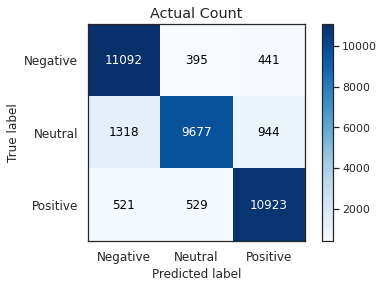

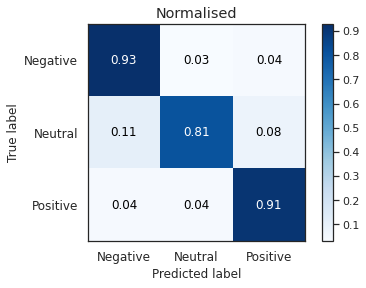


Epoch: 3, Accuracy: 0.88426339, F1: 0.88358674

Epoch: 4/15 Step: 1000... Loss: 0.144772 Val Loss: 0.329055 Accuracy: 0.887974 F1 Score: 0.887649
Epoch: 4/15 Step: 2000... Loss: 0.166868 Val Loss: 0.334975 Accuracy: 0.887165 F1 Score: 0.886995
Completed 2243 steps in epoch 4


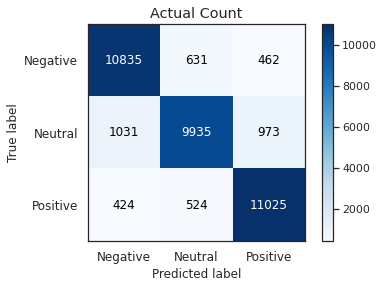

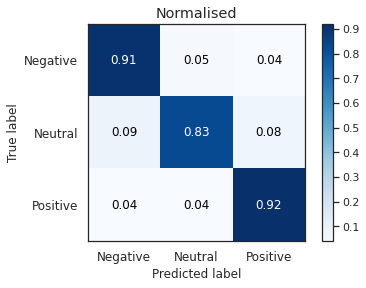


Epoch: 4, Accuracy: 0.88713728, F1: 0.88669404

Epoch: 5/15 Step: 1000... Loss: 0.114364 Val Loss: 0.362359 Accuracy: 0.885575 F1 Score: 0.885396
Epoch: 5/15 Step: 2000... Loss: 0.150633 Val Loss: 0.364942 Accuracy: 0.882533 F1 Score: 0.882039
Completed 2243 steps in epoch 5


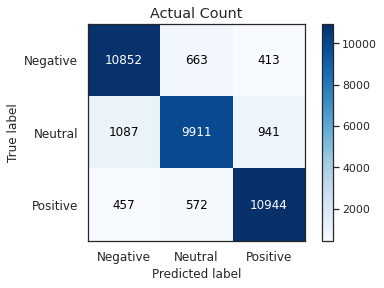

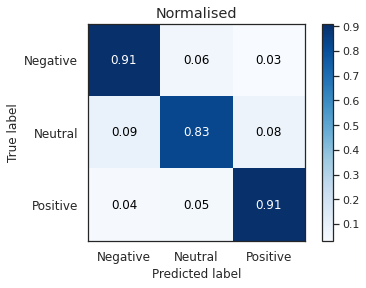


Epoch: 5, Accuracy: 0.88468192, F1: 0.88425241

Epoch: 6/15 Step: 1000... Loss: 0.093478 Val Loss: 0.396476 Accuracy: 0.886663 F1 Score: 0.886484
Epoch: 6/15 Step: 2000... Loss: 0.184120 Val Loss: 0.388025 Accuracy: 0.883956 F1 Score: 0.883779
Completed 2243 steps in epoch 6


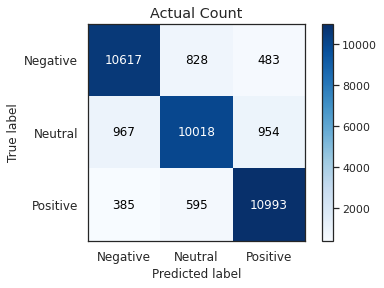

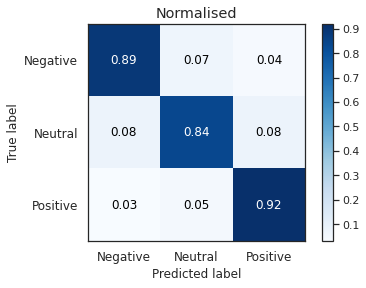


Epoch: 6, Accuracy: 0.88247768, F1: 0.88216333

Epoch: 7/15 Step: 1000... Loss: 0.083304 Val Loss: 0.417089 Accuracy: 0.884598 F1 Score: 0.884376
Epoch: 7/15 Step: 2000... Loss: 0.139718 Val Loss: 0.438433 Accuracy: 0.886551 F1 Score: 0.886382
Completed 2243 steps in epoch 7


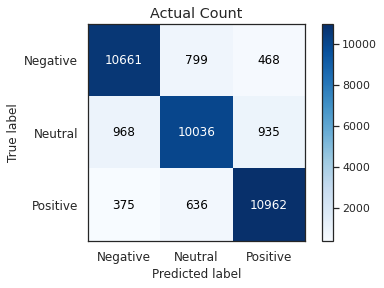

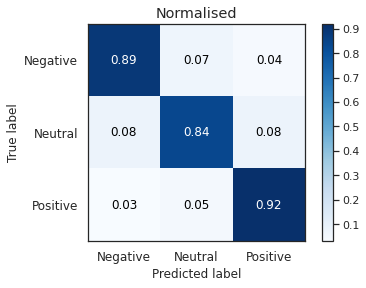


Epoch: 7, Accuracy: 0.88334263, F1: 0.88305530

Epoch: 8/15 Step: 1000... Loss: 0.105022 Val Loss: 0.439350 Accuracy: 0.883956 F1 Score: 0.883639
Epoch: 8/15 Step: 2000... Loss: 0.108868 Val Loss: 0.477799 Accuracy: 0.885910 F1 Score: 0.885680
Completed 2243 steps in epoch 8


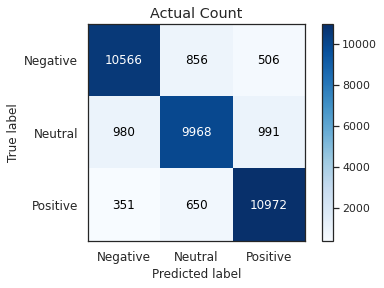

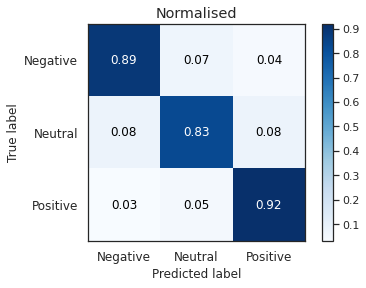


Epoch: 8, Accuracy: 0.87907366, F1: 0.87875303

Epoch: 9/15 Step: 1000... Loss: 0.066689 Val Loss: 0.501118 Accuracy: 0.882506 F1 Score: 0.882157
Epoch: 9/15 Step: 2000... Loss: 0.107733 Val Loss: 0.517218 Accuracy: 0.884654 F1 Score: 0.884564
Completed 2243 steps in epoch 9


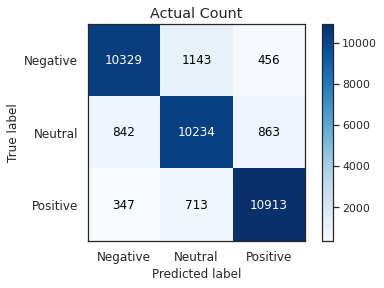

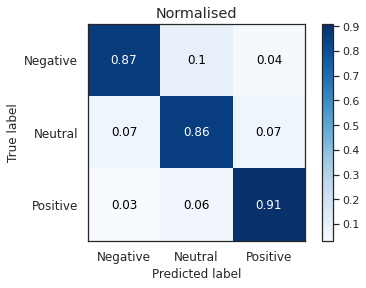


Epoch: 9, Accuracy: 0.87823661, F1: 0.87820235

Completed all epochs
Accuracy: 0.87823661, F1: 0.87820235
########## STARTING FOLD 5 ##########


Epoch: 1/15 Step: 1000... Loss: 0.497115 Val Loss: 0.454137 Accuracy: 0.830971 F1 Score: 0.831022
Epoch: 1/15 Step: 2000... Loss: 0.420802 Val Loss: 0.381527 Accuracy: 0.861468 F1 Score: 0.860794
Completed 2243 steps in epoch 1


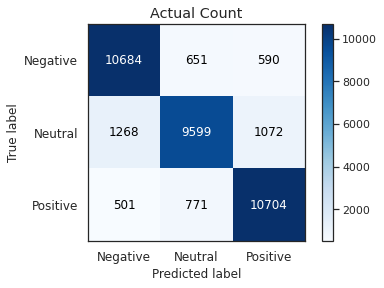

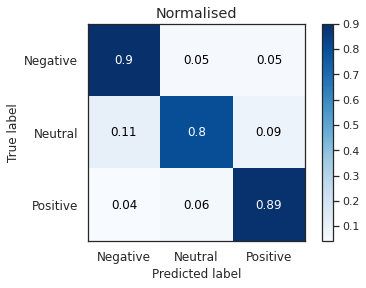


Epoch: 1, Accuracy: 0.86459263, F1: 0.86404848

Epoch: 2/15 Step: 1000... Loss: 0.263255 Val Loss: 0.345916 Accuracy: 0.872573 F1 Score: 0.872005
Epoch: 2/15 Step: 2000... Loss: 0.317409 Val Loss: 0.325499 Accuracy: 0.881836 F1 Score: 0.881280
Completed 2243 steps in epoch 2


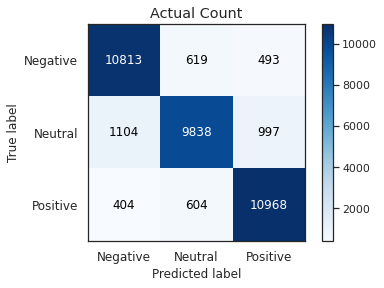

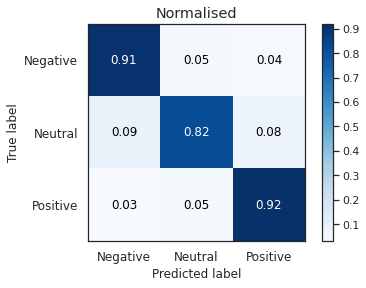


Epoch: 2, Accuracy: 0.88222656, F1: 0.88172820

Epoch: 3/15 Step: 1000... Loss: 0.199191 Val Loss: 0.322351 Accuracy: 0.884766 F1 Score: 0.884318
Epoch: 3/15 Step: 2000... Loss: 0.244867 Val Loss: 0.320127 Accuracy: 0.885993 F1 Score: 0.885485
Completed 2243 steps in epoch 3


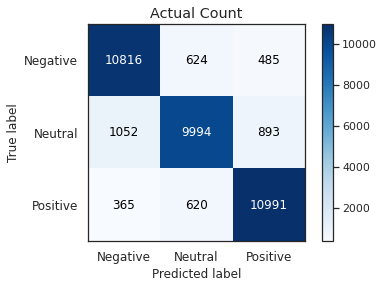

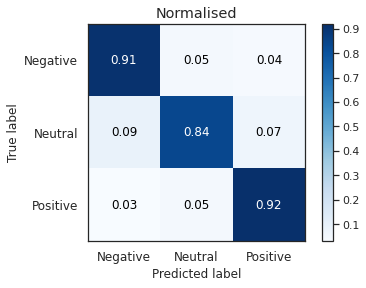


Epoch: 3, Accuracy: 0.88730469, F1: 0.88692734

Epoch: 4/15 Step: 1000... Loss: 0.120276 Val Loss: 0.321839 Accuracy: 0.887891 F1 Score: 0.887518
Epoch: 4/15 Step: 2000... Loss: 0.153335 Val Loss: 0.333638 Accuracy: 0.886775 F1 Score: 0.886361
Completed 2243 steps in epoch 4


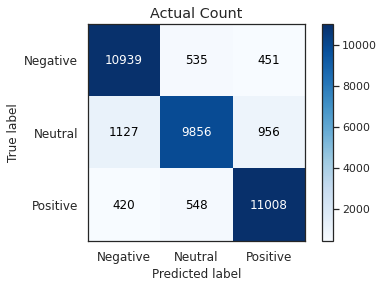

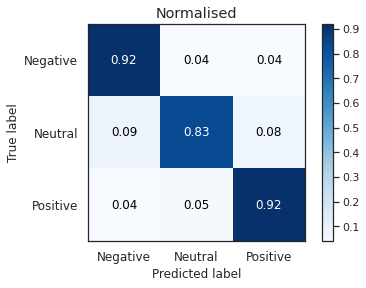


Epoch: 4, Accuracy: 0.88736049, F1: 0.88682570

Epoch: 5/15 Step: 1000... Loss: 0.097893 Val Loss: 0.344305 Accuracy: 0.885742 F1 Score: 0.885391
Epoch: 5/15 Step: 2000... Loss: 0.113830 Val Loss: 0.366572 Accuracy: 0.885156 F1 Score: 0.884772
Completed 2243 steps in epoch 5


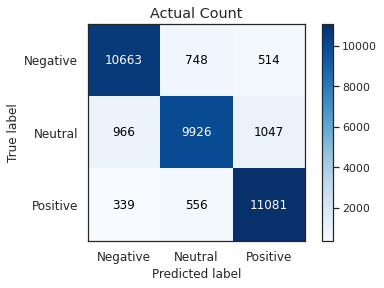

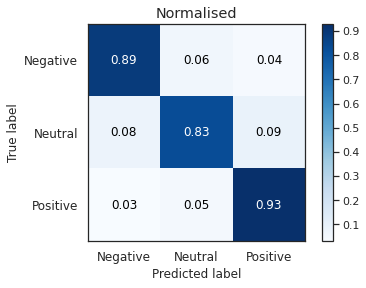


Epoch: 5, Accuracy: 0.88364955, F1: 0.88321095

Epoch: 6/15 Step: 1000... Loss: 0.045608 Val Loss: 0.374993 Accuracy: 0.885798 F1 Score: 0.885377
Epoch: 6/15 Step: 2000... Loss: 0.129186 Val Loss: 0.401499 Accuracy: 0.883733 F1 Score: 0.883470
Completed 2243 steps in epoch 6


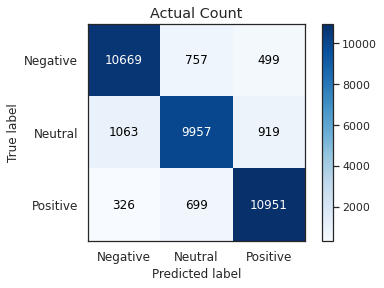

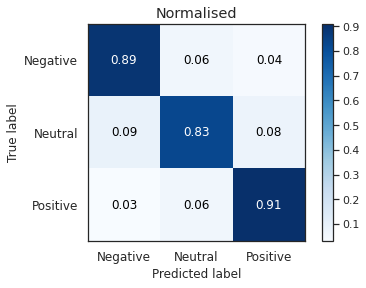


Epoch: 6, Accuracy: 0.88105469, F1: 0.88071311

Epoch: 7/15 Step: 1000... Loss: 0.099483 Val Loss: 0.410882 Accuracy: 0.883622 F1 Score: 0.883298
Epoch: 7/15 Step: 2000... Loss: 0.104930 Val Loss: 0.449585 Accuracy: 0.884905 F1 Score: 0.884715
Completed 2243 steps in epoch 7


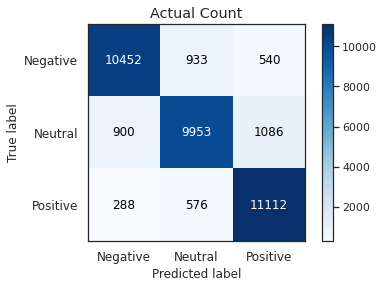

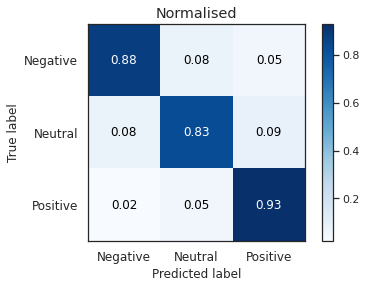


Epoch: 7, Accuracy: 0.87938058, F1: 0.87899103

Epoch: 8/15 Step: 1000... Loss: 0.029898 Val Loss: 0.458841 Accuracy: 0.880357 F1 Score: 0.879891
Epoch: 8/15 Step: 2000... Loss: 0.049037 Val Loss: 0.477470 Accuracy: 0.883008 F1 Score: 0.882788
Completed 2243 steps in epoch 8


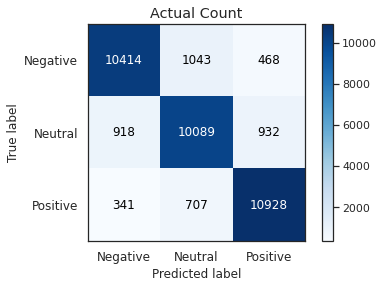

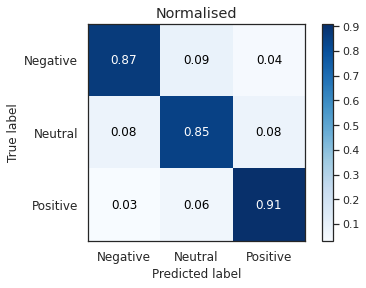


Epoch: 8, Accuracy: 0.87698103, F1: 0.87683085

Completed all epochs
Accuracy: 0.87698103, F1: 0.87683085
#################### FINAL RESULT ####################
Average Accuracy: 0.87823103, Average F1: 0.87803075


In [61]:
# Use SKF for training
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_list = []
f1_list = []
  
for fold, (train_indices, valid_indices) in enumerate(skf.split(y_train, y_train)):
    print("########## STARTING FOLD {} ##########".format(fold+1))
    # Split to train set and validation set
    X_train_fold = np.array(X_train)[train_indices]
    y_train_fold = y_train[train_indices]
    X_valid_fold = np.array(X_train)[valid_indices]
    y_valid_fold = y_train[valid_indices]

    # Set Model
    model = TextClassifier(len(vocab)+1, embed_size, lstm_size, dense_size, 3, lstm_layers, dropout)

    # Train the model for this fold
    acc, f1 = train_lstm_model(model, X_train_fold, y_train_fold, X_valid_fold, y_valid_fold, \
                                epochs, batch_size, learning_rate, sequence_length, \
                                patience, clip, print_every, print_epoch)

    acc_list.append(acc)
    f1_list.append(f1)

print("#################### FINAL RESULT ####################")

avg_acc = np.mean(acc_list)
avg_f1 = np.mean(f1_list)

print("Average Accuracy: %.8f, Average F1: %.8f" % (avg_acc, avg_f1))

# Save the best model
# torch.save(best_lstm_model.state_dict(), output_dir + 'finphrase_lstm_model_f{}_e{}.dict'.format(best_fold, best_epoch))

## Result

Epoch: 1/15 Step: 1000... Loss: 0.578595 Val Loss: 0.507856 Accuracy: 0.798973 F1 Score: 0.798642
Epoch: 1/15 Step: 2000... Loss: 0.390234 Val Loss: 0.402682 Accuracy: 0.850915 F1 Score: 0.850948
Completed 2804 steps in epoch 1


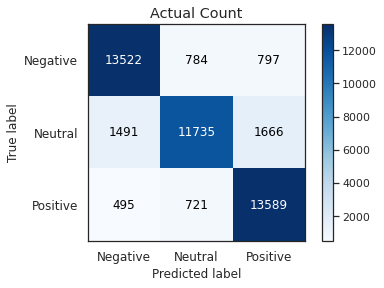

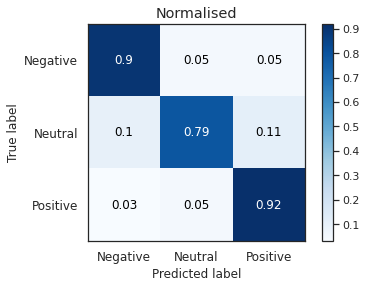


Epoch: 1, Accuracy: 0.86709821, F1: 0.86617570

Epoch: 2/15 Step: 1000... Loss: 0.334957 Val Loss: 0.331890 Accuracy: 0.878170 F1 Score: 0.877678
Epoch: 2/15 Step: 2000... Loss: 0.294654 Val Loss: 0.322543 Accuracy: 0.881719 F1 Score: 0.881168
Completed 2804 steps in epoch 2


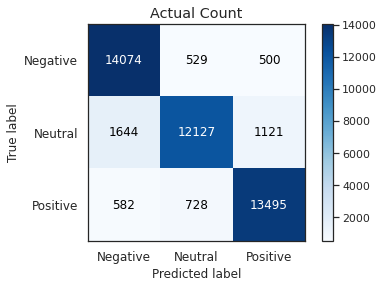

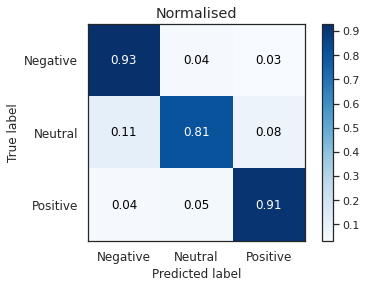


Epoch: 2, Accuracy: 0.88607143, F1: 0.88538292

Epoch: 3/15 Step: 1000... Loss: 0.304381 Val Loss: 0.306097 Accuracy: 0.889509 F1 Score: 0.888824
Epoch: 3/15 Step: 2000... Loss: 0.269681 Val Loss: 0.305620 Accuracy: 0.888259 F1 Score: 0.887709
Completed 2804 steps in epoch 3


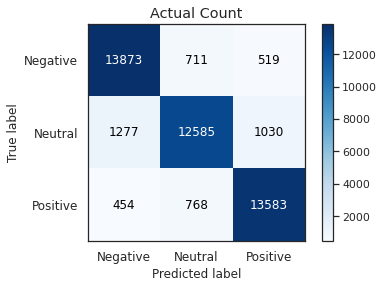

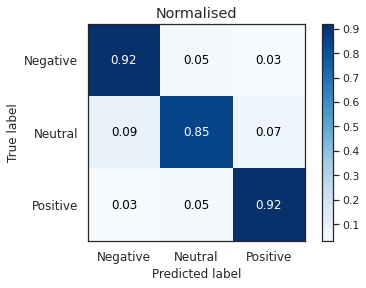


Epoch: 3, Accuracy: 0.89377232, F1: 0.89342044

Epoch: 4/15 Step: 1000... Loss: 0.244117 Val Loss: 0.314017 Accuracy: 0.890670 F1 Score: 0.889921
Epoch: 4/15 Step: 2000... Loss: 0.202282 Val Loss: 0.325875 Accuracy: 0.883460 F1 Score: 0.882790
Completed 2804 steps in epoch 4


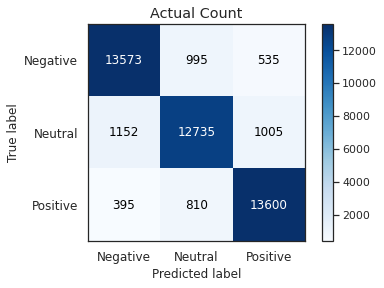

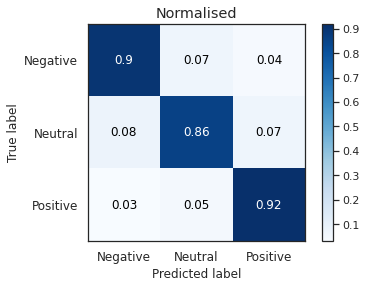


Epoch: 4, Accuracy: 0.89080357, F1: 0.89063556

Epoch: 5/15 Step: 1000... Loss: 0.218796 Val Loss: 0.337914 Accuracy: 0.890089 F1 Score: 0.889537
Epoch: 5/15 Step: 2000... Loss: 0.154428 Val Loss: 0.347814 Accuracy: 0.889040 F1 Score: 0.888654
Completed 2804 steps in epoch 5


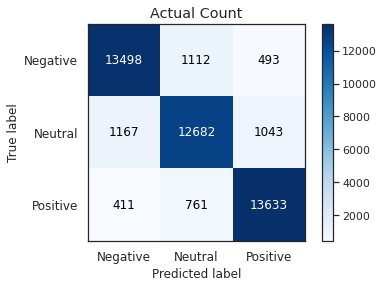

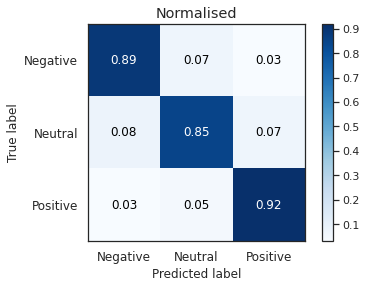


Epoch: 5, Accuracy: 0.88868304, F1: 0.88850948

Epoch: 6/15 Step: 1000... Loss: 0.152060 Val Loss: 0.369871 Accuracy: 0.887143 F1 Score: 0.886761
Epoch: 6/15 Step: 2000... Loss: 0.125665 Val Loss: 0.395909 Accuracy: 0.885513 F1 Score: 0.885522
Completed 2804 steps in epoch 6


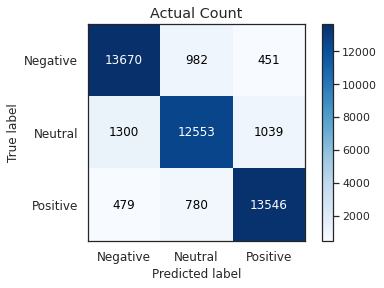

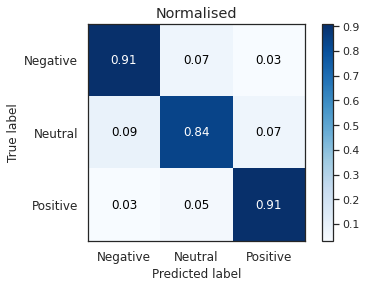


Epoch: 6, Accuracy: 0.88770089, F1: 0.88744488

Epoch: 7/15 Step: 1000... Loss: 0.168428 Val Loss: 0.410720 Accuracy: 0.886875 F1 Score: 0.886462
Epoch: 7/15 Step: 2000... Loss: 0.112214 Val Loss: 0.464103 Accuracy: 0.884844 F1 Score: 0.884691
Completed 2804 steps in epoch 7


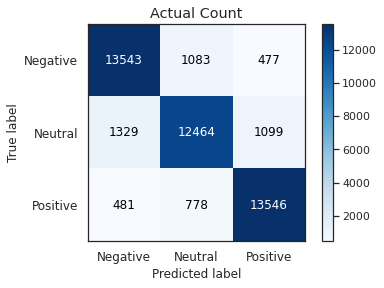

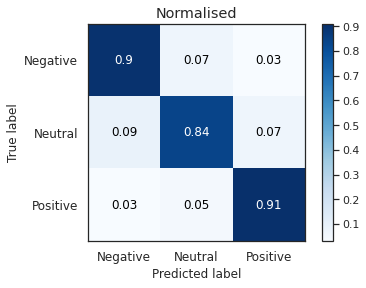


Epoch: 7, Accuracy: 0.88287946, F1: 0.88260665

Epoch: 8/15 Step: 1000... Loss: 0.094989 Val Loss: 0.448690 Accuracy: 0.884978 F1 Score: 0.884796
Epoch: 8/15 Step: 2000... Loss: 0.130586 Val Loss: 0.493374 Accuracy: 0.883594 F1 Score: 0.883826
Completed 2804 steps in epoch 8


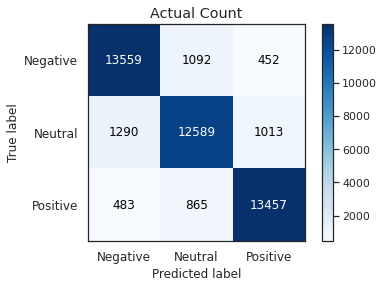

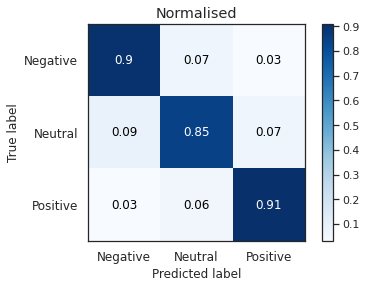


Epoch: 8, Accuracy: 0.88404018, F1: 0.88389165

Completed all epochs
Accuracy: 0.88404018, F1: 0.88389165


In [62]:
# Re-train the model with all Train set and validate on Test set
acc, f1 = train_lstm_model(model, X_train, y_train, X_test, y_test, \
                         epochs, batch_size, learning_rate, sequence_length, \
                         patience, clip, print_every, print_epoch)
        

In [63]:
result_df.loc['C1: LSTM'] = (round(acc,4), round(f1,4))
result_df

Accuracy      F1
A: Lexicon       0.4101  0.3854
B: Tfidf            NaN     NaN
C1: LSTM          0.884  0.8839
C2: LSTM+GloVe      NaN     NaN
D1: BERT            NaN     NaN
D2: ALBERT          NaN     NaN

# C2. Glove Word Embedding + LSTM
Use GloVe word embedding as embedding layer

### Download GloVe files

In [64]:
# Use 6B 300d uncased
glove_file_pickle = 'glove.6B.300d.pickle'
glove_file_zip = 'glove.6B.zip'
glove_file_txt = 'glove.6B.300d.txt'

# # User 42B 300d uncased
# glove_file_pickle = 'glove.42B.300d.pickle'
# glove_file_zip = 'glove.42B.300d.zip'
# glove_file_txt = 'glove.42B.300d.txt'

# Download Glove file if not exist
if not os.path.exists(glove_dir + glove_file_pickle):
    if not os.path.exists(glove_dir):
        os.mkdir(glove_dir)
    if not os.path.exists(glove_dir + glove_file_zip):
        !wget -o $glove_dir$glove_file_zip http://nlp.stanford.edu/data/$glove_file_zip
    # Unzip the downloaded file
    !unzip $glove_dir$glove_file_zip -d $glove_dir
    embedding_dict = {}

    with open(glove_dir + glove_file_txt, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vectors
    f.close()

    pickle.dump(embedding_dict, open(glove_dir + glove_file_pickle, 'wb'))

In [65]:
glove_dict = pickle.load(open(glove_dir + glove_file_pickle, 'rb'))
print("The number of words in the dict: ", len(glove_dict))
print("Embedding for the word 'the':")
glove_dict['the']

The number of words in the dict:  400000
Embedding for the word 'the':


array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [66]:
weight_matrix = np.zeros((len(vocab)+1, 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)

32084 words found out of 45767 words in vocab.
(45768, 300)


### Define Model

In [67]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, dense_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.dense_size = dense_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(dropout)

        if dense_size == 0:
            self.fc = nn.Linear(lstm_size, output_size)
        else:
            self.fc1 = nn.Linear(lstm_size, dense_size)
            self.fc2 = nn.Linear(dense_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        if self.dense_size == 0:
            out = self.fc(lstm_out)
        else:
            dense_out = self.fc1(lstm_out)
            out = self.fc2(dense_out)
        # Softmax
        logps = self.softmax(out)

        return logps, hidden_state

### Configure the model and train!

In [68]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 0, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(45768, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [69]:
# Set Hyperparameters

# for Training
epochs=5
batch_size=64
learning_rate=3e-4
sequence_length=48
dropout=0.1
patience=5
clip=5
print_every=1000
print_epoch=True

# Model parameters
lstm_size=128
dense_size=0
lstm_layers=2

########## STARTING FOLD 1 ##########


Epoch: 1/15 Step: 1000... Loss: 0.546999 Val Loss: 0.560460 Accuracy: 0.776618 F1 Score: 0.776056
Epoch: 1/15 Step: 2000... Loss: 0.398362 Val Loss: 0.462909 Accuracy: 0.823186 F1 Score: 0.823214
Completed 2243 steps in epoch 1


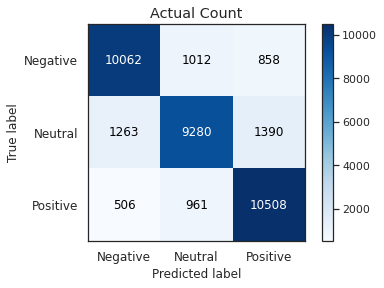

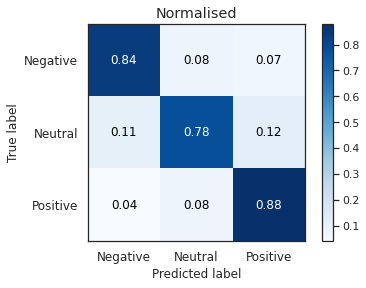


Epoch: 1, Accuracy: 0.83286830, F1: 0.83237650

Epoch: 2/15 Step: 1000... Loss: 0.417955 Val Loss: 0.401569 Accuracy: 0.852204 F1 Score: 0.851684
Epoch: 2/15 Step: 2000... Loss: 0.268841 Val Loss: 0.378195 Accuracy: 0.860631 F1 Score: 0.860041
Completed 2243 steps in epoch 2


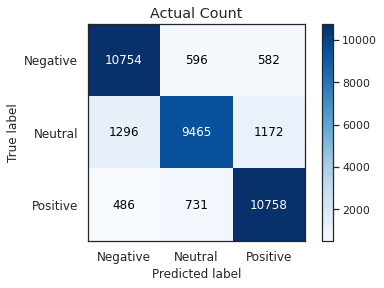

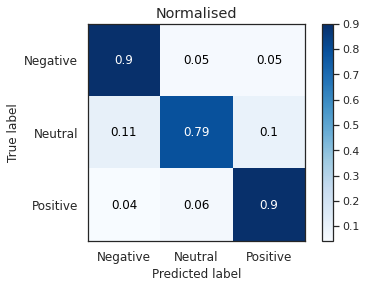


Epoch: 2, Accuracy: 0.86431362, F1: 0.86356643

Epoch: 3/15 Step: 1000... Loss: 0.425063 Val Loss: 0.355733 Accuracy: 0.871819 F1 Score: 0.871179
Epoch: 3/15 Step: 2000... Loss: 0.240902 Val Loss: 0.356888 Accuracy: 0.869699 F1 Score: 0.869147
Completed 2243 steps in epoch 3


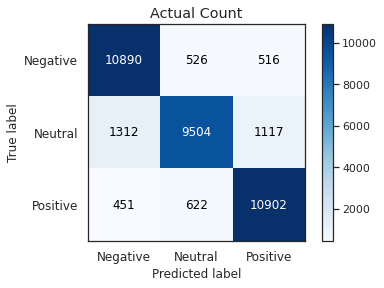

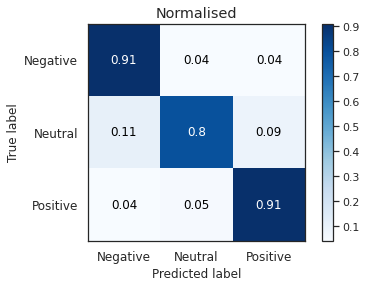


Epoch: 3, Accuracy: 0.87321429, F1: 0.87237422

Epoch: 4/15 Step: 1000... Loss: 0.365440 Val Loss: 0.345888 Accuracy: 0.876814 F1 Score: 0.876384
Epoch: 4/15 Step: 2000... Loss: 0.208575 Val Loss: 0.353059 Accuracy: 0.873214 F1 Score: 0.872923
Completed 2243 steps in epoch 4


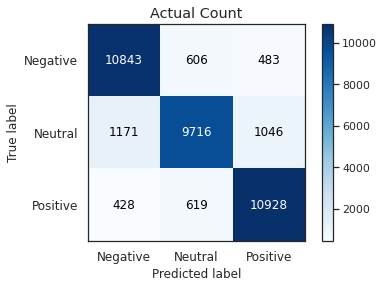

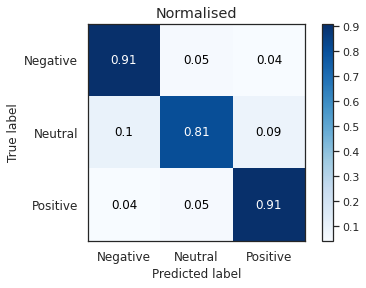


Epoch: 4, Accuracy: 0.87854353, F1: 0.87793551

Epoch: 5/15 Step: 1000... Loss: 0.340282 Val Loss: 0.334242 Accuracy: 0.883371 F1 Score: 0.883046
Epoch: 5/15 Step: 2000... Loss: 0.229675 Val Loss: 0.350229 Accuracy: 0.878850 F1 Score: 0.878590
Completed 2243 steps in epoch 5


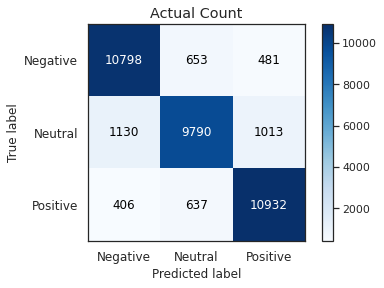

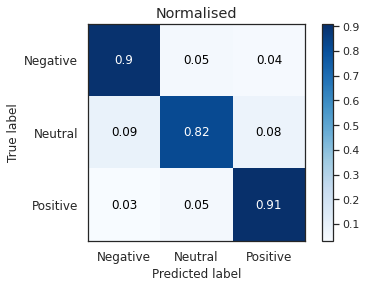


Epoch: 5, Accuracy: 0.87946429, F1: 0.87894060

Epoch: 6/15 Step: 1000... Loss: 0.219618 Val Loss: 0.336772 Accuracy: 0.884124 F1 Score: 0.883740
Epoch: 6/15 Step: 2000... Loss: 0.187357 Val Loss: 0.361701 Accuracy: 0.876339 F1 Score: 0.875980
Completed 2243 steps in epoch 6


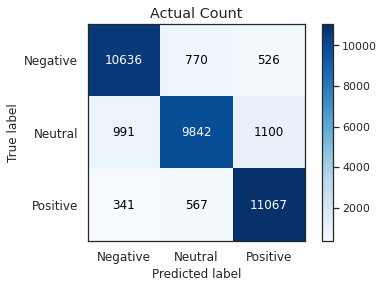

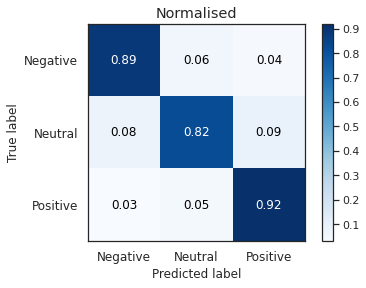


Epoch: 6, Accuracy: 0.88016183, F1: 0.87966548

Epoch: 7/15 Step: 1000... Loss: 0.178319 Val Loss: 0.346621 Accuracy: 0.884235 F1 Score: 0.883907
Epoch: 7/15 Step: 2000... Loss: 0.186599 Val Loss: 0.345050 Accuracy: 0.884208 F1 Score: 0.883857
Completed 2243 steps in epoch 7


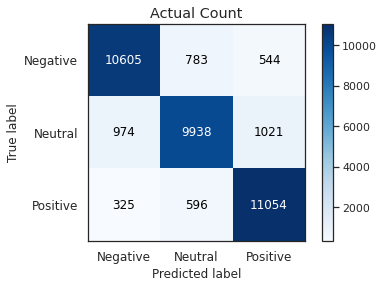

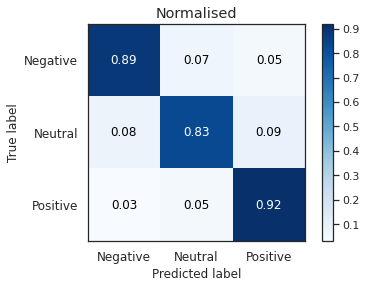


Epoch: 7, Accuracy: 0.88161272, F1: 0.88121022

Epoch: 8/15 Step: 1000... Loss: 0.144018 Val Loss: 0.353348 Accuracy: 0.877902 F1 Score: 0.877081
Epoch: 8/15 Step: 2000... Loss: 0.249303 Val Loss: 0.370247 Accuracy: 0.878962 F1 Score: 0.878566
Completed 2243 steps in epoch 8


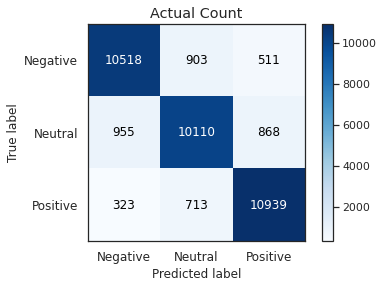

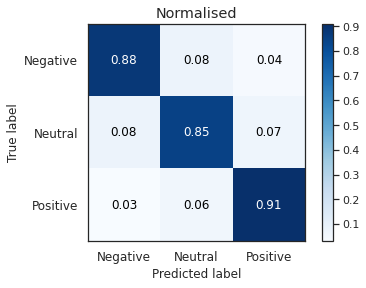


Epoch: 8, Accuracy: 0.88077567, F1: 0.88059308

Epoch: 9/15 Step: 1000... Loss: 0.230037 Val Loss: 0.386987 Accuracy: 0.879297 F1 Score: 0.879124
Epoch: 9/15 Step: 2000... Loss: 0.177192 Val Loss: 0.370349 Accuracy: 0.883175 F1 Score: 0.882964
Completed 2243 steps in epoch 9


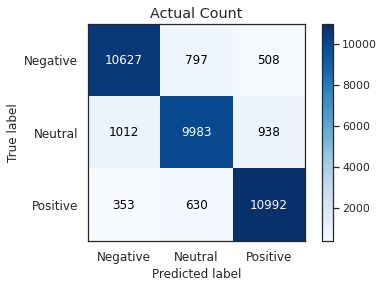

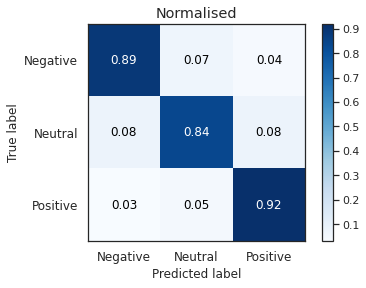


Epoch: 9, Accuracy: 0.88175223, F1: 0.88141059

Epoch: 10/15 Step: 1000... Loss: 0.086823 Val Loss: 0.387692 Accuracy: 0.883426 F1 Score: 0.883107
Epoch: 10/15 Step: 2000... Loss: 0.117492 Val Loss: 0.392668 Accuracy: 0.881138 F1 Score: 0.881011
Completed 2243 steps in epoch 10


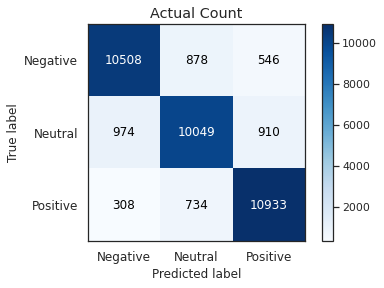

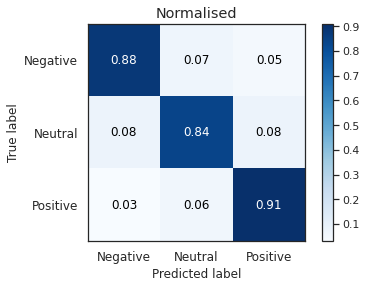


Epoch: 10, Accuracy: 0.87862723, F1: 0.87840903

Epoch: 11/15 Step: 1000... Loss: 0.099669 Val Loss: 0.397637 Accuracy: 0.881278 F1 Score: 0.880751
Epoch: 11/15 Step: 2000... Loss: 0.111919 Val Loss: 0.422686 Accuracy: 0.880915 F1 Score: 0.880971
Completed 2243 steps in epoch 11


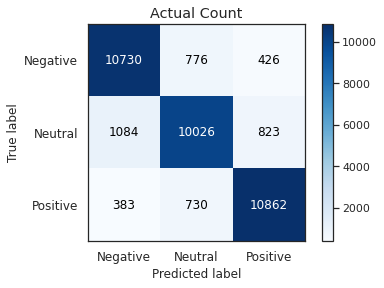

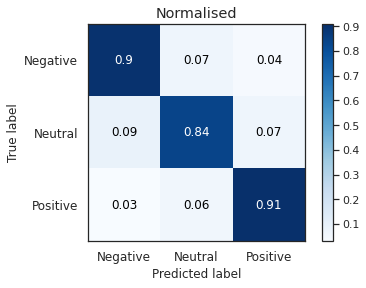


Epoch: 11, Accuracy: 0.88219866, F1: 0.88195676

Epoch: 12/15 Step: 1000... Loss: 0.085677 Val Loss: 0.419231 Accuracy: 0.879381 F1 Score: 0.878720
Epoch: 12/15 Step: 2000... Loss: 0.086574 Val Loss: 0.431935 Accuracy: 0.880720 F1 Score: 0.880364
Completed 2243 steps in epoch 12


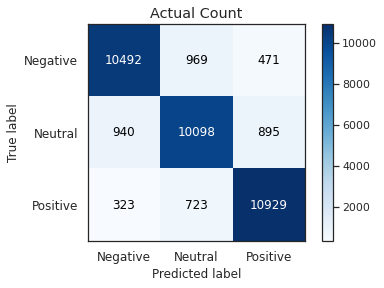

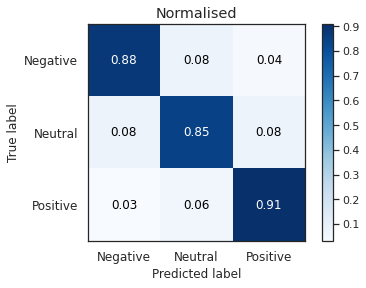


Epoch: 12, Accuracy: 0.87943638, F1: 0.87927685

Epoch: 13/15 Step: 1000... Loss: 0.090433 Val Loss: 0.436346 Accuracy: 0.878041 F1 Score: 0.877640
Epoch: 13/15 Step: 2000... Loss: 0.143072 Val Loss: 0.451761 Accuracy: 0.880050 F1 Score: 0.879896
Completed 2243 steps in epoch 13


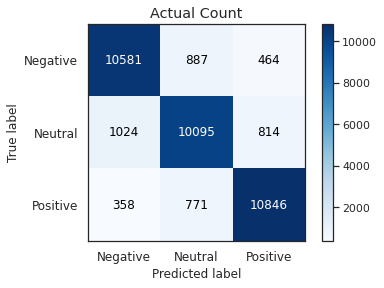

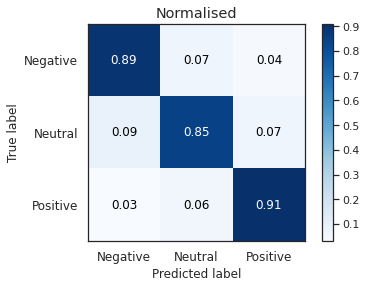


Epoch: 13, Accuracy: 0.87952009, F1: 0.87938240

Epoch: 14/15 Step: 1000... Loss: 0.104064 Val Loss: 0.475452 Accuracy: 0.880106 F1 Score: 0.879826
Epoch: 14/15 Step: 2000... Loss: 0.154962 Val Loss: 0.481464 Accuracy: 0.878460 F1 Score: 0.878390
Completed 2243 steps in epoch 14


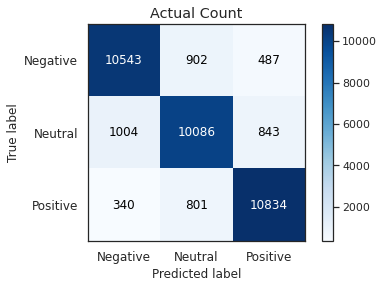

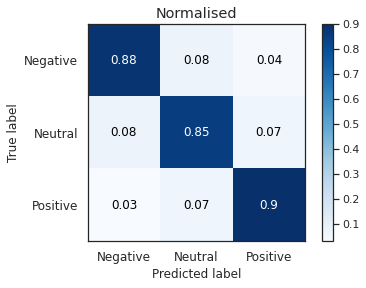


Epoch: 14, Accuracy: 0.87787388, F1: 0.87774803

Epoch: 15/15 Step: 1000... Loss: 0.045893 Val Loss: 0.487860 Accuracy: 0.879046 F1 Score: 0.878790
Epoch: 15/15 Step: 2000... Loss: 0.081585 Val Loss: 0.529619 Accuracy: 0.879576 F1 Score: 0.879662
Completed 2243 steps in epoch 15


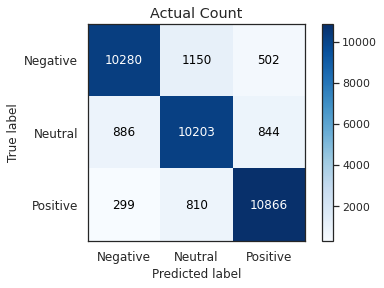

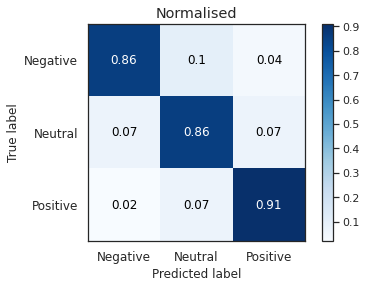


Epoch: 15, Accuracy: 0.87469308, F1: 0.87470229


Completed all epochs
Accuracy: 0.87469308, F1: 0.87470229
########## STARTING FOLD 2 ##########


Epoch: 1/15 Step: 1000... Loss: 0.587723 Val Loss: 0.557084 Accuracy: 0.776395 F1 Score: 0.777222
Epoch: 1/15 Step: 2000... Loss: 0.452559 Val Loss: 0.458120 Accuracy: 0.826814 F1 Score: 0.826430
Completed 2243 steps in epoch 1


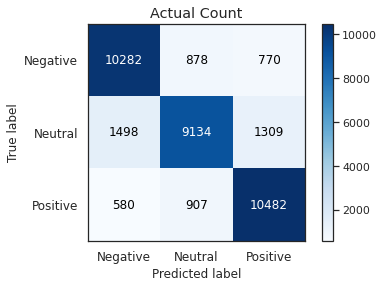

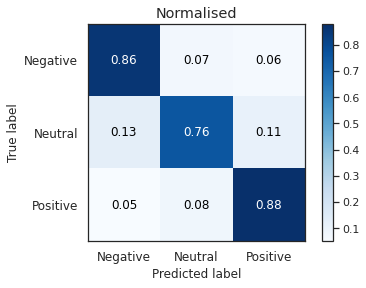


Epoch: 1, Accuracy: 0.83420759, F1: 0.83345188

Epoch: 2/15 Step: 1000... Loss: 0.453189 Val Loss: 0.399819 Accuracy: 0.852985 F1 Score: 0.852221
Epoch: 2/15 Step: 2000... Loss: 0.284179 Val Loss: 0.370593 Accuracy: 0.864258 F1 Score: 0.863741
Completed 2243 steps in epoch 2


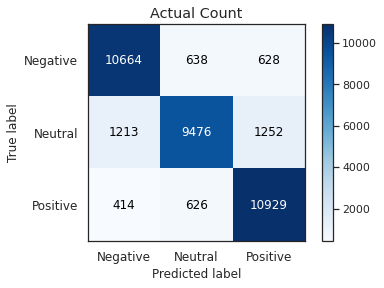

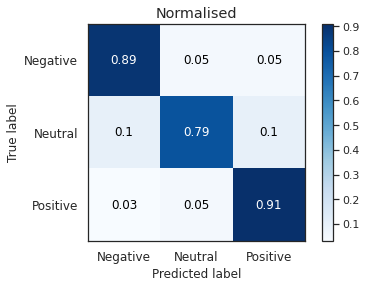


Epoch: 2, Accuracy: 0.86688058, F1: 0.86610033

Epoch: 3/15 Step: 1000... Loss: 0.287363 Val Loss: 0.359568 Accuracy: 0.868890 F1 Score: 0.867993
Epoch: 3/15 Step: 2000... Loss: 0.216024 Val Loss: 0.351017 Accuracy: 0.874721 F1 Score: 0.874419
Completed 2243 steps in epoch 3


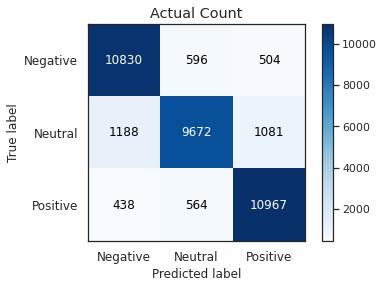

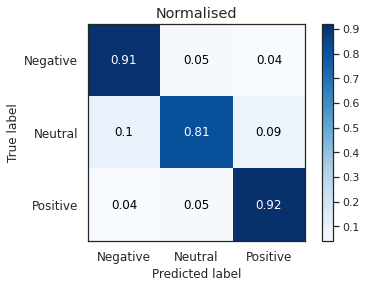


Epoch: 3, Accuracy: 0.87804129, F1: 0.87738003

Epoch: 4/15 Step: 1000... Loss: 0.288322 Val Loss: 0.349064 Accuracy: 0.876814 F1 Score: 0.876362
Epoch: 4/15 Step: 2000... Loss: 0.221490 Val Loss: 0.335995 Accuracy: 0.880329 F1 Score: 0.879787
Completed 2243 steps in epoch 4


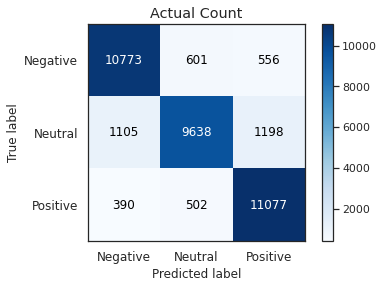

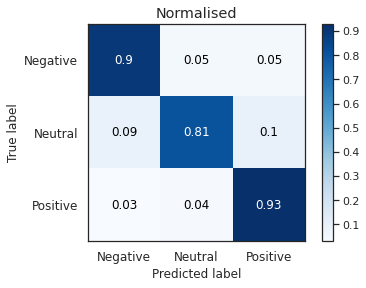


Epoch: 4, Accuracy: 0.87857143, F1: 0.87784916

Epoch: 5/15 Step: 1000... Loss: 0.220629 Val Loss: 0.339354 Accuracy: 0.881975 F1 Score: 0.881510
Epoch: 5/15 Step: 2000... Loss: 0.213157 Val Loss: 0.331424 Accuracy: 0.885519 F1 Score: 0.885107
Completed 2243 steps in epoch 5


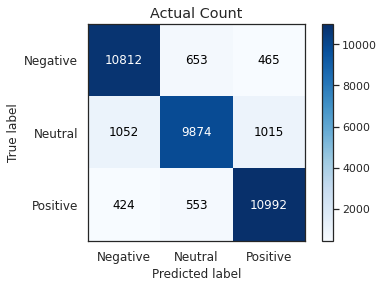

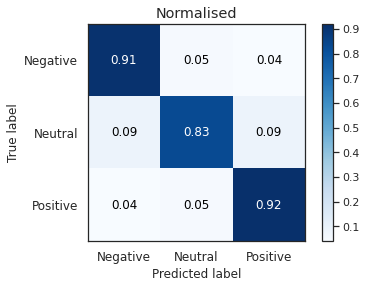


Epoch: 5, Accuracy: 0.88387277, F1: 0.88339575

Epoch: 6/15 Step: 1000... Loss: 0.235223 Val Loss: 0.350548 Accuracy: 0.882533 F1 Score: 0.882149
Epoch: 6/15 Step: 2000... Loss: 0.213807 Val Loss: 0.366323 Accuracy: 0.877762 F1 Score: 0.877339
Completed 2243 steps in epoch 6


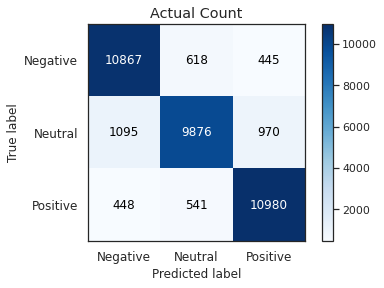

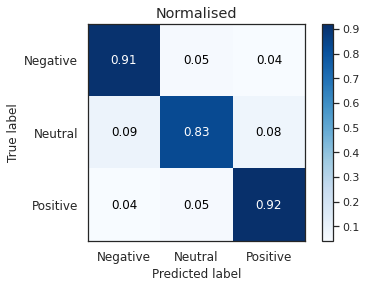


Epoch: 6, Accuracy: 0.88512835, F1: 0.88464765

Epoch: 7/15 Step: 1000... Loss: 0.206596 Val Loss: 0.353878 Accuracy: 0.886189 F1 Score: 0.885878
Epoch: 7/15 Step: 2000... Loss: 0.217310 Val Loss: 0.351541 Accuracy: 0.885575 F1 Score: 0.885220
Completed 2243 steps in epoch 7


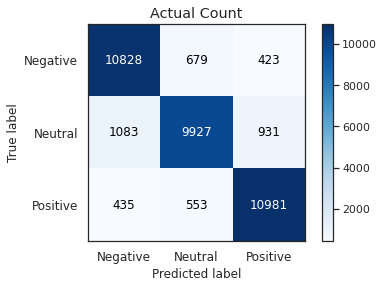

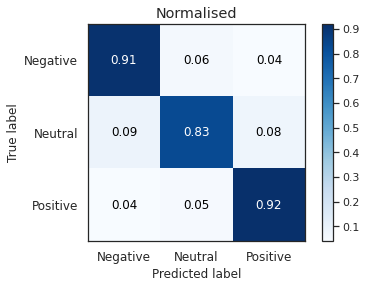


Epoch: 7, Accuracy: 0.88549107, F1: 0.88506409

Epoch: 8/15 Step: 1000... Loss: 0.182824 Val Loss: 0.371124 Accuracy: 0.882952 F1 Score: 0.882577
Epoch: 8/15 Step: 2000... Loss: 0.193850 Val Loss: 0.365631 Accuracy: 0.887193 F1 Score: 0.886999
Completed 2243 steps in epoch 8


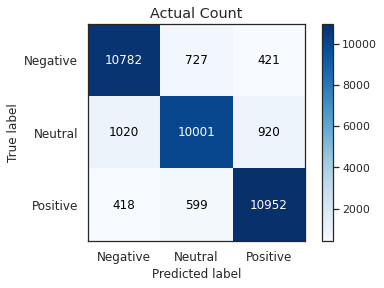

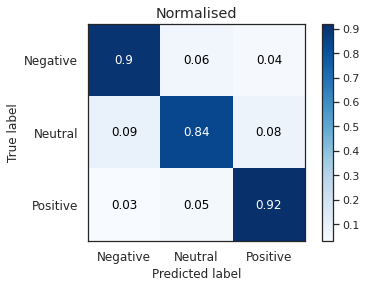


Epoch: 8, Accuracy: 0.88546317, F1: 0.88512193

Epoch: 9/15 Step: 1000... Loss: 0.167450 Val Loss: 0.388201 Accuracy: 0.882143 F1 Score: 0.881921
Epoch: 9/15 Step: 2000... Loss: 0.235799 Val Loss: 0.382241 Accuracy: 0.885631 F1 Score: 0.885295
Completed 2243 steps in epoch 9


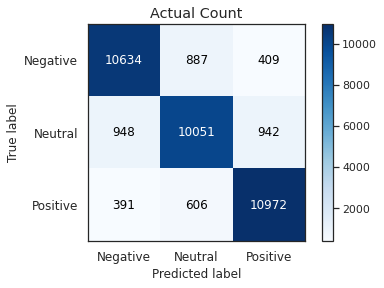

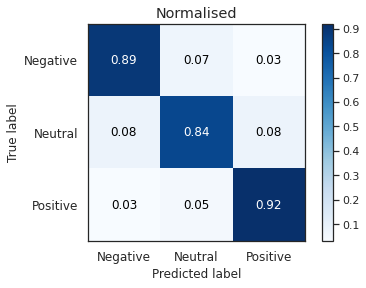


Epoch: 9, Accuracy: 0.88328683, F1: 0.88301869

Epoch: 10/15 Step: 1000... Loss: 0.201547 Val Loss: 0.379882 Accuracy: 0.885631 F1 Score: 0.885197
Epoch: 10/15 Step: 2000... Loss: 0.187515 Val Loss: 0.378458 Accuracy: 0.886635 F1 Score: 0.886281
Completed 2243 steps in epoch 10


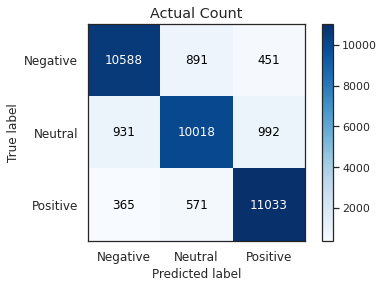

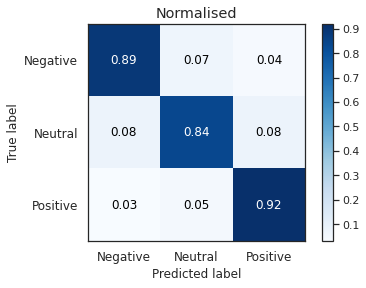


Epoch: 10, Accuracy: 0.88278460, F1: 0.88245863

Epoch: 11/15 Step: 1000... Loss: 0.164091 Val Loss: 0.395602 Accuracy: 0.885798 F1 Score: 0.885530
Epoch: 11/15 Step: 2000... Loss: 0.119422 Val Loss: 0.420145 Accuracy: 0.886272 F1 Score: 0.885972
Completed 2243 steps in epoch 11


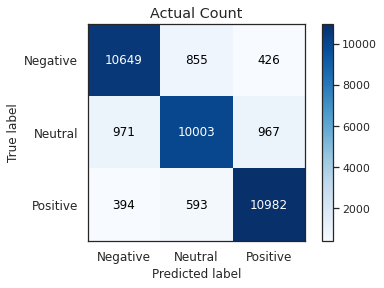

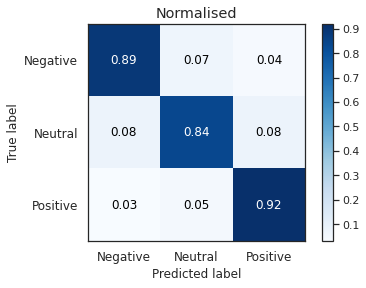


Epoch: 11, Accuracy: 0.88264509, F1: 0.88232548

Epoch: 12/15 Step: 1000... Loss: 0.129320 Val Loss: 0.437137 Accuracy: 0.880776 F1 Score: 0.880542
Epoch: 12/15 Step: 2000... Loss: 0.187126 Val Loss: 0.436477 Accuracy: 0.885547 F1 Score: 0.885301
Completed 2243 steps in epoch 12


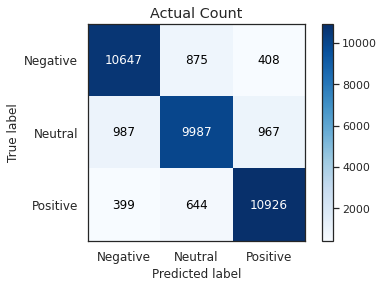

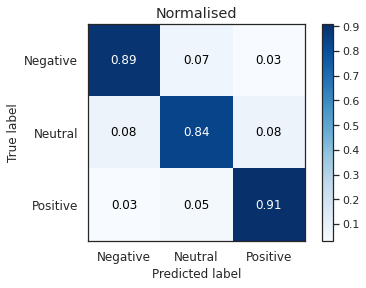


Epoch: 12, Accuracy: 0.88058036, F1: 0.88028983

Epoch: 13/15 Step: 1000... Loss: 0.130394 Val Loss: 0.440915 Accuracy: 0.882366 F1 Score: 0.882137
Epoch: 13/15 Step: 2000... Loss: 0.199548 Val Loss: 0.485302 Accuracy: 0.882338 F1 Score: 0.882272
Completed 2243 steps in epoch 13


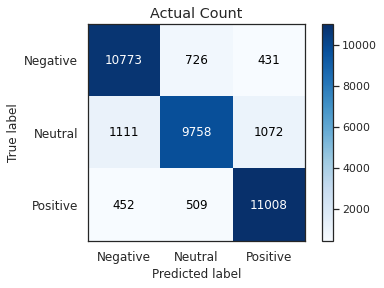

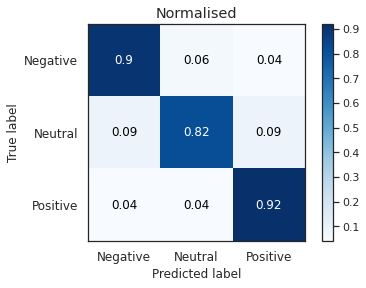


Epoch: 13, Accuracy: 0.87999442, F1: 0.87940635

Completed all epochs
Accuracy: 0.87999442, F1: 0.87940635
########## STARTING FOLD 3 ##########


Epoch: 1/15 Step: 1000... Loss: 0.541970 Val Loss: 0.558255 Accuracy: 0.776814 F1 Score: 0.776752
Epoch: 1/15 Step: 2000... Loss: 0.383484 Val Loss: 0.461896 Accuracy: 0.824275 F1 Score: 0.823876
Completed 2243 steps in epoch 1


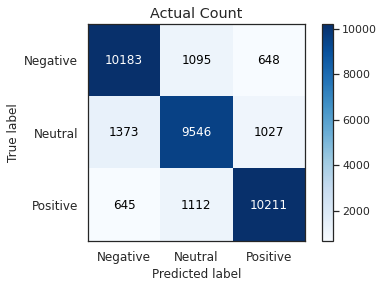

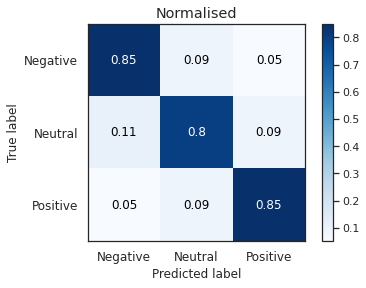


Epoch: 1, Accuracy: 0.83537946, F1: 0.83528164

Epoch: 2/15 Step: 1000... Loss: 0.376427 Val Loss: 0.405148 Accuracy: 0.849526 F1 Score: 0.849162
Epoch: 2/15 Step: 2000... Loss: 0.267052 Val Loss: 0.378946 Accuracy: 0.861663 F1 Score: 0.861118
Completed 2243 steps in epoch 2


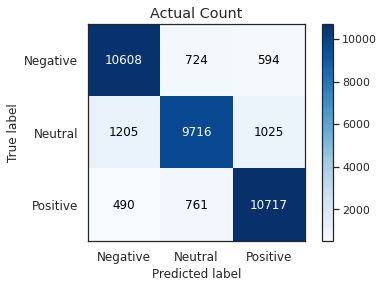

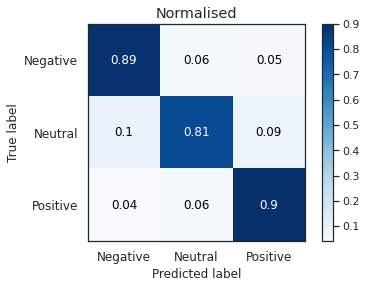


Epoch: 2, Accuracy: 0.86609933, F1: 0.86568712

Epoch: 3/15 Step: 1000... Loss: 0.307446 Val Loss: 0.359420 Accuracy: 0.868108 F1 Score: 0.867631
Epoch: 3/15 Step: 2000... Loss: 0.257025 Val Loss: 0.348165 Accuracy: 0.875446 F1 Score: 0.875046
Completed 2243 steps in epoch 3


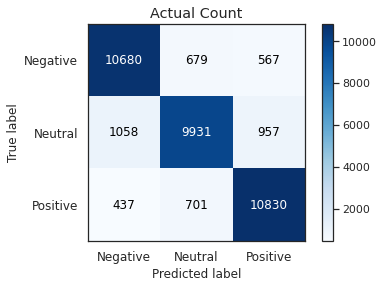

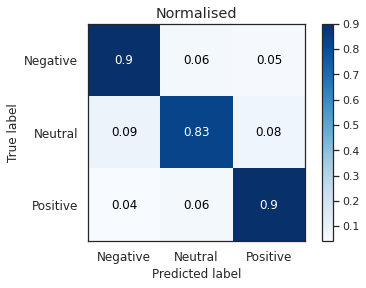


Epoch: 3, Accuracy: 0.87726004, F1: 0.87694816

Epoch: 4/15 Step: 1000... Loss: 0.279813 Val Loss: 0.342061 Accuracy: 0.878655 F1 Score: 0.878427
Epoch: 4/15 Step: 2000... Loss: 0.214267 Val Loss: 0.338990 Accuracy: 0.881557 F1 Score: 0.881194
Completed 2243 steps in epoch 4


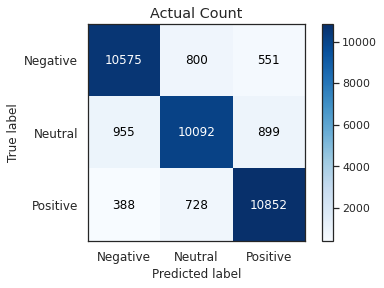

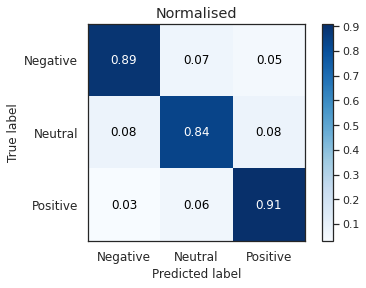


Epoch: 4, Accuracy: 0.87943638, F1: 0.87925884

Epoch: 5/15 Step: 1000... Loss: 0.242697 Val Loss: 0.343260 Accuracy: 0.880999 F1 Score: 0.880854
Epoch: 5/15 Step: 2000... Loss: 0.199498 Val Loss: 0.345818 Accuracy: 0.881975 F1 Score: 0.881571
Completed 2243 steps in epoch 5


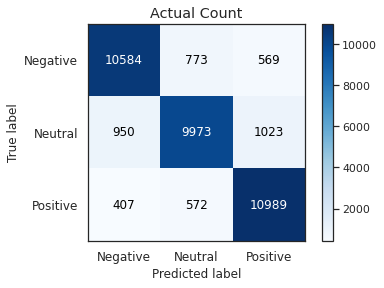

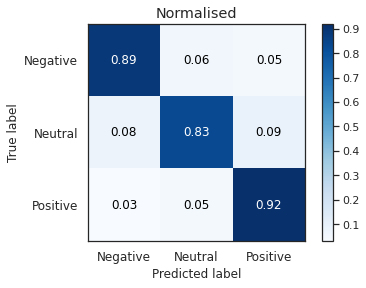


Epoch: 5, Accuracy: 0.88018973, F1: 0.87985396

Epoch: 6/15 Step: 1000... Loss: 0.264836 Val Loss: 0.347958 Accuracy: 0.881975 F1 Score: 0.881839
Epoch: 6/15 Step: 2000... Loss: 0.233880 Val Loss: 0.344508 Accuracy: 0.884375 F1 Score: 0.884029
Completed 2243 steps in epoch 6


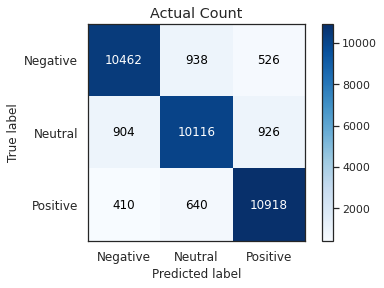

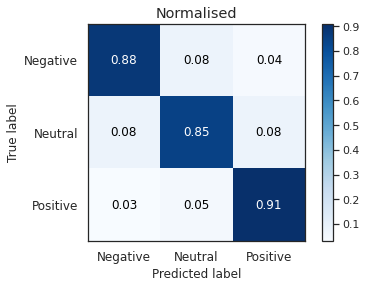


Epoch: 6, Accuracy: 0.87879464, F1: 0.87861002

Epoch: 7/15 Step: 1000... Loss: 0.176528 Val Loss: 0.355567 Accuracy: 0.883705 F1 Score: 0.883486
Epoch: 7/15 Step: 2000... Loss: 0.154727 Val Loss: 0.364698 Accuracy: 0.885435 F1 Score: 0.885259
Completed 2243 steps in epoch 7


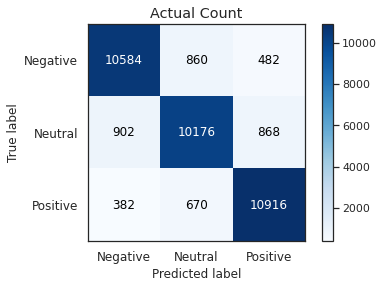

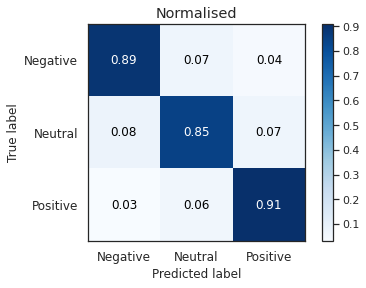


Epoch: 7, Accuracy: 0.88381696, F1: 0.88366534

Epoch: 8/15 Step: 1000... Loss: 0.235161 Val Loss: 0.366238 Accuracy: 0.884347 F1 Score: 0.884220
Epoch: 8/15 Step: 2000... Loss: 0.143825 Val Loss: 0.369630 Accuracy: 0.885910 F1 Score: 0.885779
Completed 2243 steps in epoch 8


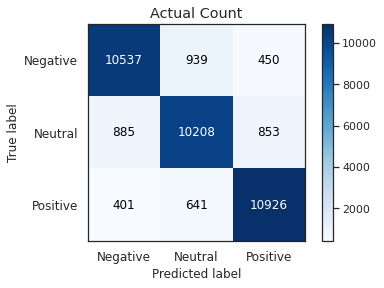

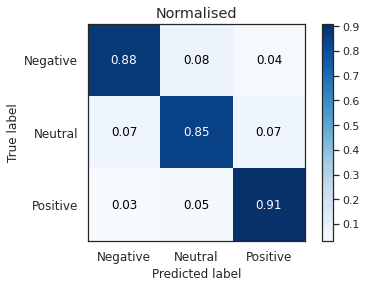


Epoch: 8, Accuracy: 0.88367746, F1: 0.88355046

Epoch: 9/15 Step: 1000... Loss: 0.139778 Val Loss: 0.382516 Accuracy: 0.884766 F1 Score: 0.884701
Epoch: 9/15 Step: 2000... Loss: 0.156733 Val Loss: 0.385579 Accuracy: 0.885938 F1 Score: 0.885635
Completed 2243 steps in epoch 9


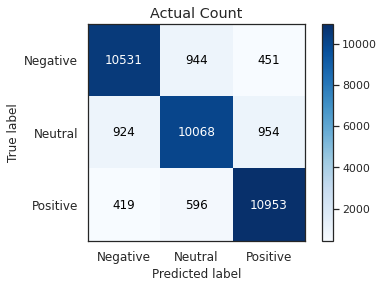

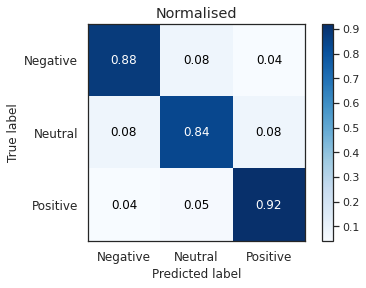


Epoch: 9, Accuracy: 0.88035714, F1: 0.88012086

Epoch: 10/15 Step: 1000... Loss: 0.158102 Val Loss: 0.410092 Accuracy: 0.882645 F1 Score: 0.882569
Epoch: 10/15 Step: 2000... Loss: 0.167538 Val Loss: 0.391607 Accuracy: 0.884431 F1 Score: 0.884263
Completed 2243 steps in epoch 10


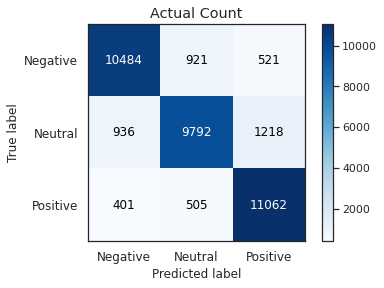

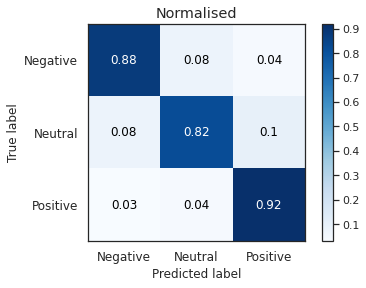


Epoch: 10, Accuracy: 0.87438616, F1: 0.87387927

Epoch: 11/15 Step: 1000... Loss: 0.135391 Val Loss: 0.421641 Accuracy: 0.883064 F1 Score: 0.882986
Epoch: 11/15 Step: 2000... Loss: 0.108424 Val Loss: 0.414708 Accuracy: 0.885575 F1 Score: 0.885537
Completed 2243 steps in epoch 11


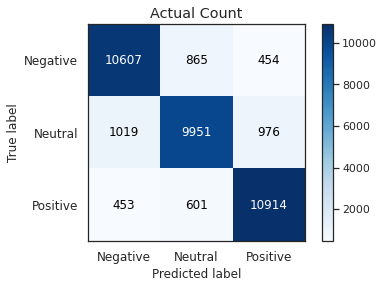

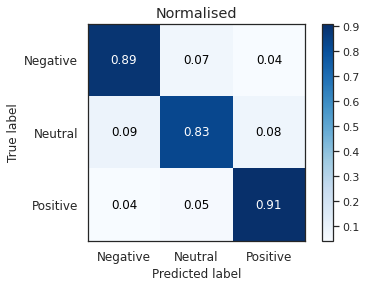


Epoch: 11, Accuracy: 0.87812500, F1: 0.87780686

Epoch: 12/15 Step: 1000... Loss: 0.099042 Val Loss: 0.446430 Accuracy: 0.883064 F1 Score: 0.882972
Epoch: 12/15 Step: 2000... Loss: 0.101245 Val Loss: 0.437973 Accuracy: 0.884375 F1 Score: 0.884307
Completed 2243 steps in epoch 12


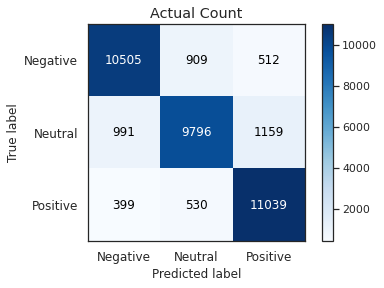

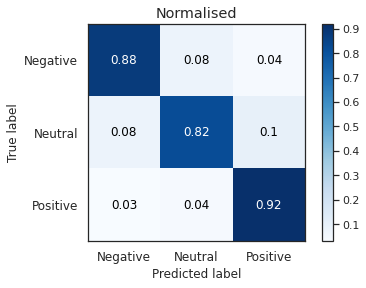


Epoch: 12, Accuracy: 0.87444196, F1: 0.87393760

Completed all epochs
Accuracy: 0.87444196, F1: 0.87393760
########## STARTING FOLD 4 ##########


Epoch: 1/15 Step: 1000... Loss: 0.500694 Val Loss: 0.554809 Accuracy: 0.779408 F1 Score: 0.778680
Epoch: 1/15 Step: 2000... Loss: 0.546156 Val Loss: 0.464654 Accuracy: 0.825670 F1 Score: 0.825599
Completed 2243 steps in epoch 1


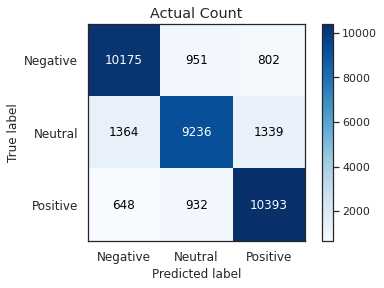

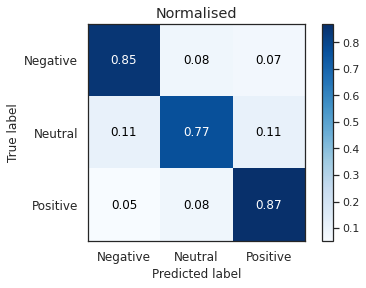


Epoch: 1, Accuracy: 0.83158482, F1: 0.83104973

Epoch: 2/15 Step: 1000... Loss: 0.347469 Val Loss: 0.413701 Accuracy: 0.847991 F1 Score: 0.847582
Epoch: 2/15 Step: 2000... Loss: 0.354409 Val Loss: 0.379993 Accuracy: 0.860603 F1 Score: 0.860186
Completed 2243 steps in epoch 2


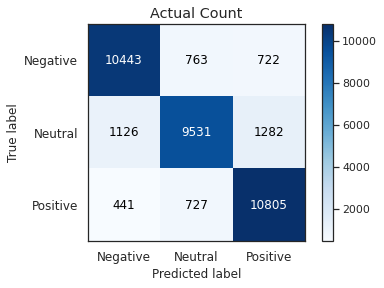

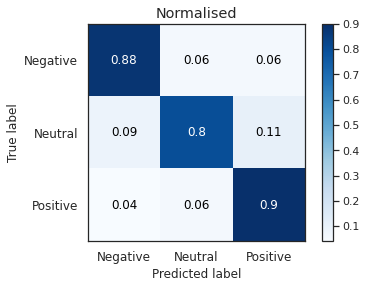


Epoch: 2, Accuracy: 0.85878906, F1: 0.85824477

Epoch: 3/15 Step: 1000... Loss: 0.262186 Val Loss: 0.368439 Accuracy: 0.865430 F1 Score: 0.864711
Epoch: 3/15 Step: 2000... Loss: 0.284985 Val Loss: 0.349836 Accuracy: 0.871429 F1 Score: 0.870873
Completed 2243 steps in epoch 3


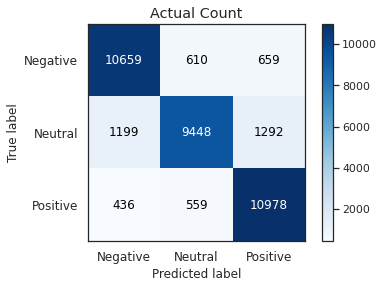

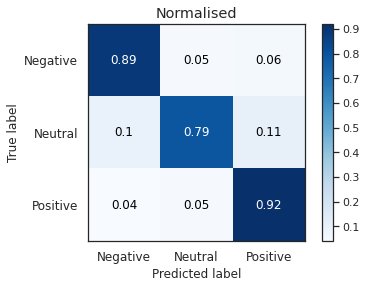


Epoch: 3, Accuracy: 0.86732701, F1: 0.86651414

Epoch: 4/15 Step: 1000... Loss: 0.254540 Val Loss: 0.348448 Accuracy: 0.874163 F1 Score: 0.873638
Epoch: 4/15 Step: 2000... Loss: 0.265751 Val Loss: 0.343085 Accuracy: 0.875195 F1 Score: 0.874861
Completed 2243 steps in epoch 4


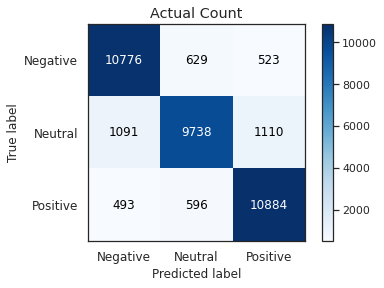

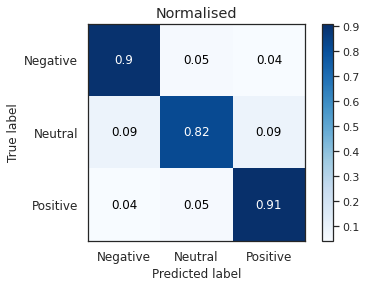


Epoch: 4, Accuracy: 0.87606027, F1: 0.87553682

Epoch: 5/15 Step: 1000... Loss: 0.202009 Val Loss: 0.346333 Accuracy: 0.879213 F1 Score: 0.878855
Epoch: 5/15 Step: 2000... Loss: 0.275333 Val Loss: 0.357835 Accuracy: 0.875921 F1 Score: 0.875725
Completed 2243 steps in epoch 5


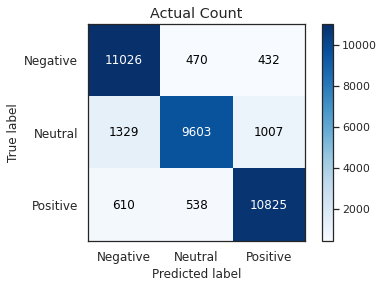

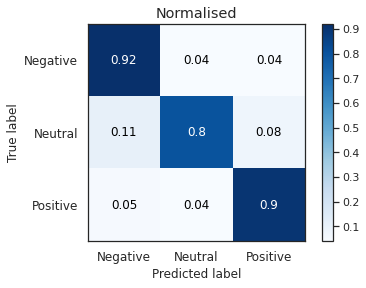


Epoch: 5, Accuracy: 0.87762277, F1: 0.87694707

Epoch: 6/15 Step: 1000... Loss: 0.217153 Val Loss: 0.347822 Accuracy: 0.882478 F1 Score: 0.882226
Epoch: 6/15 Step: 2000... Loss: 0.229264 Val Loss: 0.369161 Accuracy: 0.874302 F1 Score: 0.873840
Completed 2243 steps in epoch 6


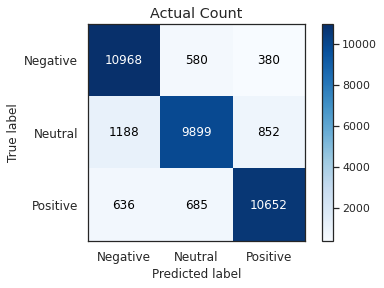

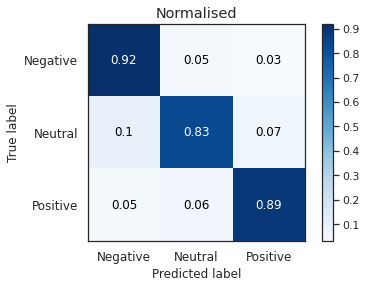


Epoch: 6, Accuracy: 0.87943638, F1: 0.87910367

Epoch: 7/15 Step: 1000... Loss: 0.201561 Val Loss: 0.349150 Accuracy: 0.882366 F1 Score: 0.881971
Epoch: 7/15 Step: 2000... Loss: 0.204876 Val Loss: 0.377417 Accuracy: 0.879464 F1 Score: 0.879182
Completed 2243 steps in epoch 7


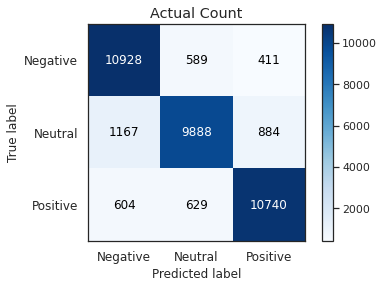

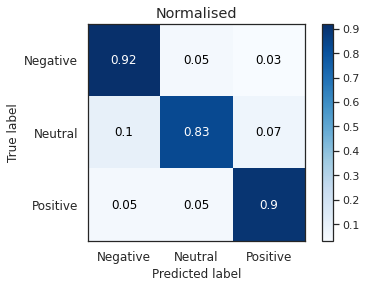


Epoch: 7, Accuracy: 0.88046875, F1: 0.88011003

Epoch: 8/15 Step: 1000... Loss: 0.165980 Val Loss: 0.358475 Accuracy: 0.883343 F1 Score: 0.882900
Epoch: 8/15 Step: 2000... Loss: 0.136268 Val Loss: 0.389359 Accuracy: 0.879102 F1 Score: 0.878719
Completed 2243 steps in epoch 8


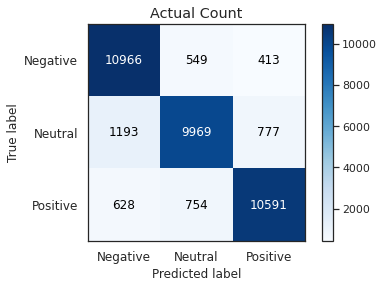

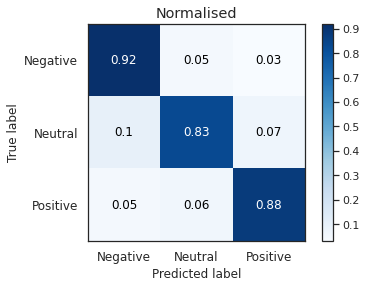


Epoch: 8, Accuracy: 0.87963170, F1: 0.87936970

Epoch: 9/15 Step: 1000... Loss: 0.150493 Val Loss: 0.384271 Accuracy: 0.882701 F1 Score: 0.882425
Epoch: 9/15 Step: 2000... Loss: 0.127887 Val Loss: 0.391768 Accuracy: 0.882533 F1 Score: 0.882163
Completed 2243 steps in epoch 9


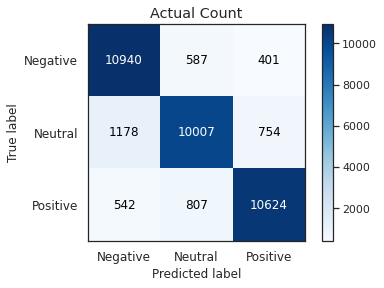

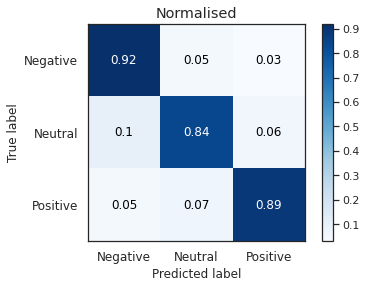


Epoch: 9, Accuracy: 0.88088728, F1: 0.88064671

Epoch: 10/15 Step: 1000... Loss: 0.186090 Val Loss: 0.398293 Accuracy: 0.883092 F1 Score: 0.882719
Epoch: 10/15 Step: 2000... Loss: 0.148771 Val Loss: 0.409726 Accuracy: 0.881780 F1 Score: 0.881590
Completed 2243 steps in epoch 10


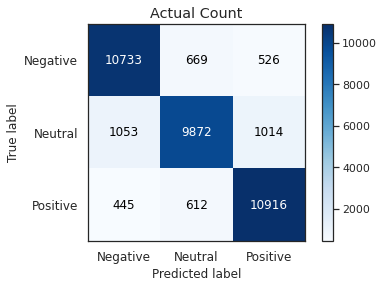

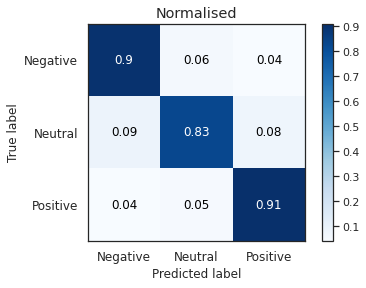


Epoch: 10, Accuracy: 0.87949219, F1: 0.87907893

Epoch: 11/15 Step: 1000... Loss: 0.135259 Val Loss: 0.422545 Accuracy: 0.882394 F1 Score: 0.882206
Epoch: 11/15 Step: 2000... Loss: 0.154444 Val Loss: 0.423580 Accuracy: 0.881166 F1 Score: 0.880874
Completed 2243 steps in epoch 11


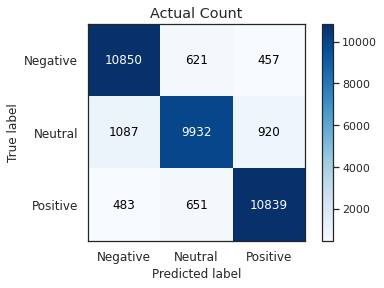

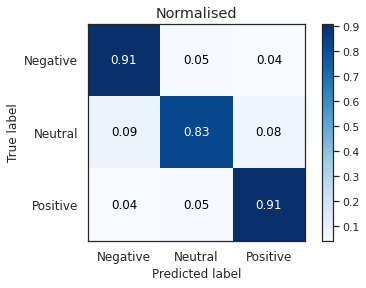


Epoch: 11, Accuracy: 0.88228237, F1: 0.88191727

Epoch: 12/15 Step: 1000... Loss: 0.143937 Val Loss: 0.437970 Accuracy: 0.880357 F1 Score: 0.880037
Epoch: 12/15 Step: 2000... Loss: 0.113734 Val Loss: 0.461172 Accuracy: 0.879660 F1 Score: 0.879590
Completed 2243 steps in epoch 12


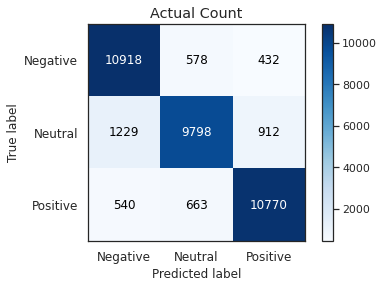

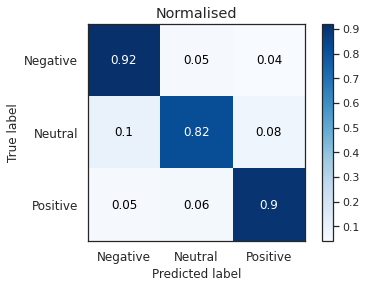


Epoch: 12, Accuracy: 0.87851563, F1: 0.87805847

Epoch: 13/15 Step: 1000... Loss: 0.106577 Val Loss: 0.439538 Accuracy: 0.882254 F1 Score: 0.881972
Epoch: 13/15 Step: 2000... Loss: 0.162736 Val Loss: 0.488567 Accuracy: 0.883036 F1 Score: 0.882975
Completed 2243 steps in epoch 13


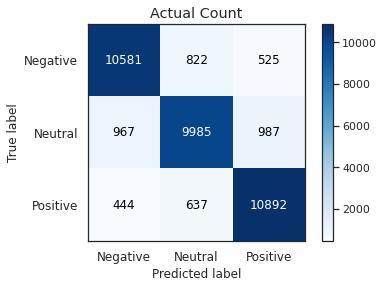

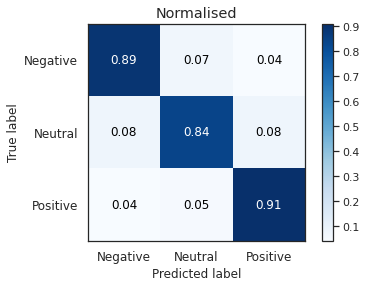


Epoch: 13, Accuracy: 0.87773437, F1: 0.87745583

Epoch: 14/15 Step: 1000... Loss: 0.124358 Val Loss: 0.478796 Accuracy: 0.882254 F1 Score: 0.882169
Epoch: 14/15 Step: 2000... Loss: 0.202282 Val Loss: 0.506698 Accuracy: 0.880608 F1 Score: 0.880409
Completed 2243 steps in epoch 14


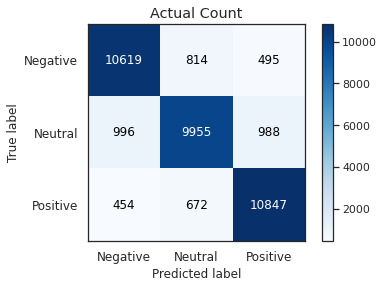

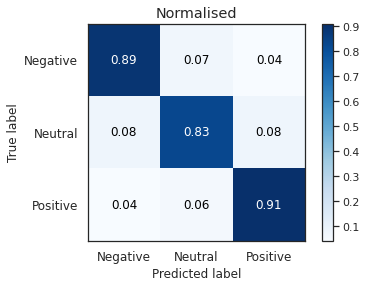


Epoch: 14, Accuracy: 0.87670201, F1: 0.87641895

Epoch: 15/15 Step: 1000... Loss: 0.108925 Val Loss: 0.493324 Accuracy: 0.880413 F1 Score: 0.880238
Epoch: 15/15 Step: 2000... Loss: 0.133455 Val Loss: 0.539624 Accuracy: 0.879297 F1 Score: 0.879222
Completed 2243 steps in epoch 15


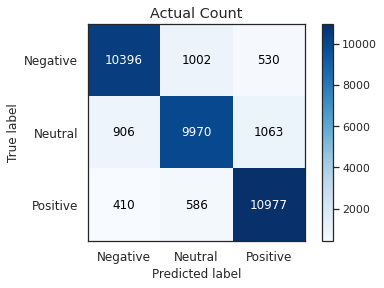

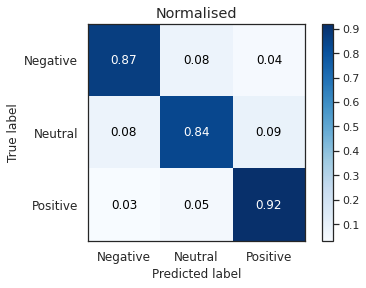


Epoch: 15, Accuracy: 0.87452567, F1: 0.87421896


Completed all epochs
Accuracy: 0.87452567, F1: 0.87421896
########## STARTING FOLD 5 ##########


Epoch: 1/15 Step: 1000... Loss: 0.644145 Val Loss: 0.556945 Accuracy: 0.777037 F1 Score: 0.777072
Epoch: 1/15 Step: 2000... Loss: 0.513681 Val Loss: 0.467316 Accuracy: 0.824498 F1 Score: 0.823489
Completed 2243 steps in epoch 1


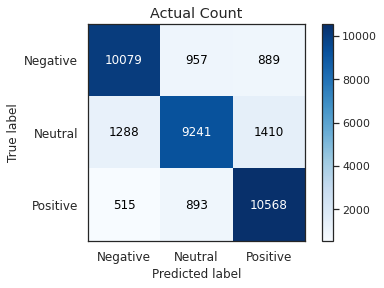

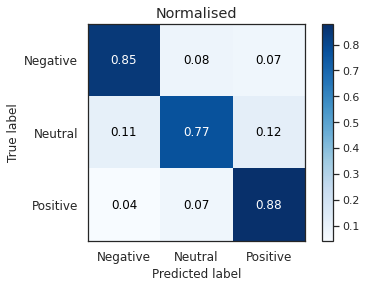


Epoch: 1, Accuracy: 0.83392857, F1: 0.83334237

Epoch: 2/15 Step: 1000... Loss: 0.357776 Val Loss: 0.403548 Accuracy: 0.851060 F1 Score: 0.850600
Epoch: 2/15 Step: 2000... Loss: 0.370965 Val Loss: 0.372883 Accuracy: 0.863588 F1 Score: 0.862972
Completed 2243 steps in epoch 2


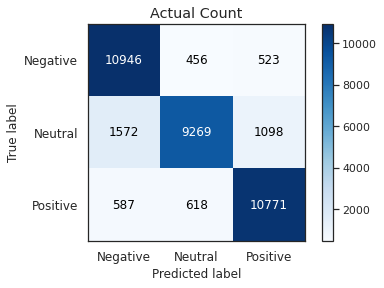

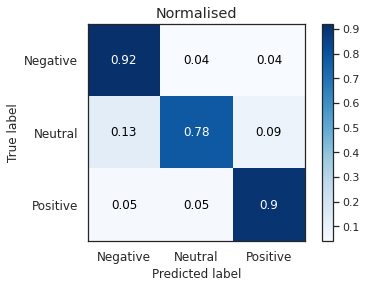


Epoch: 2, Accuracy: 0.86456473, F1: 0.86354356

Epoch: 3/15 Step: 1000... Loss: 0.307033 Val Loss: 0.362935 Accuracy: 0.869922 F1 Score: 0.869411
Epoch: 3/15 Step: 2000... Loss: 0.306012 Val Loss: 0.350331 Accuracy: 0.873103 F1 Score: 0.872533
Completed 2243 steps in epoch 3


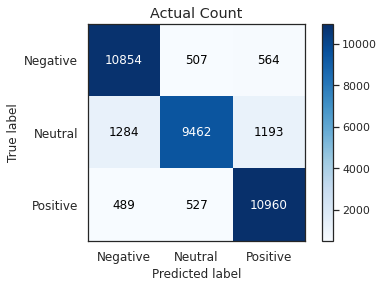

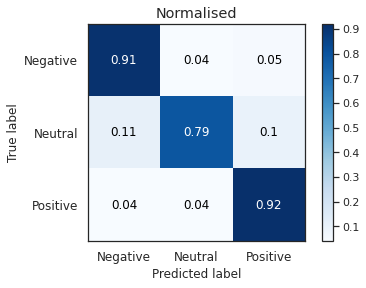


Epoch: 3, Accuracy: 0.87265625, F1: 0.87178955

Epoch: 4/15 Step: 1000... Loss: 0.252005 Val Loss: 0.350216 Accuracy: 0.877400 F1 Score: 0.877102
Epoch: 4/15 Step: 2000... Loss: 0.242040 Val Loss: 0.340649 Accuracy: 0.878265 F1 Score: 0.877750
Completed 2243 steps in epoch 4


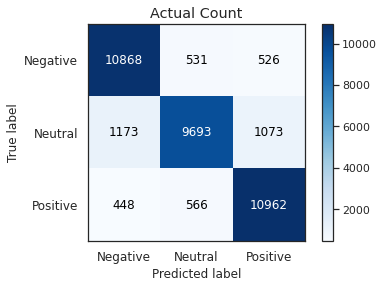

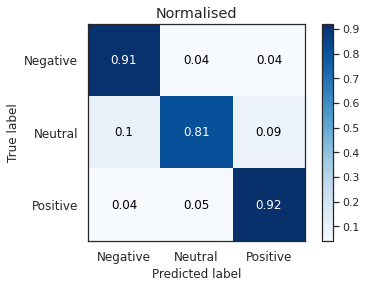


Epoch: 4, Accuracy: 0.87954799, F1: 0.87891193

Epoch: 5/15 Step: 1000... Loss: 0.226502 Val Loss: 0.342532 Accuracy: 0.881808 F1 Score: 0.881469
Epoch: 5/15 Step: 2000... Loss: 0.240376 Val Loss: 0.338112 Accuracy: 0.883287 F1 Score: 0.882847
Completed 2243 steps in epoch 5


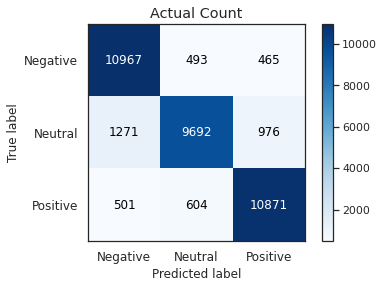

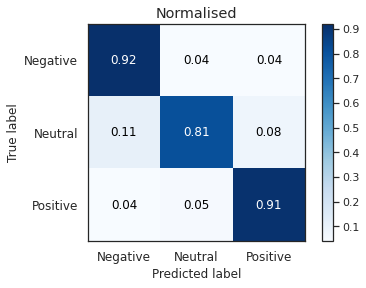


Epoch: 5, Accuracy: 0.87974330, F1: 0.87911855

Epoch: 6/15 Step: 1000... Loss: 0.184285 Val Loss: 0.345350 Accuracy: 0.884180 F1 Score: 0.883915
Epoch: 6/15 Step: 2000... Loss: 0.227041 Val Loss: 0.345991 Accuracy: 0.883845 F1 Score: 0.883397
Completed 2243 steps in epoch 6


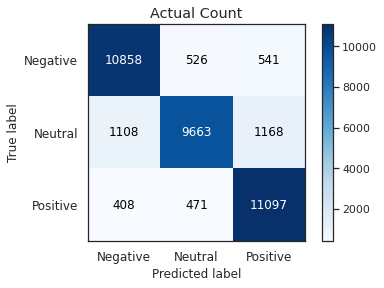

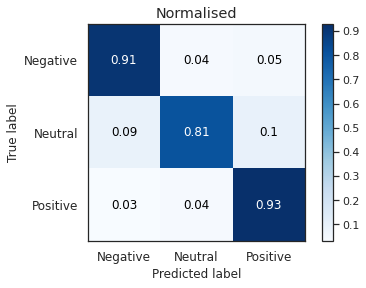


Epoch: 6, Accuracy: 0.88219866, F1: 0.88147976

Epoch: 7/15 Step: 1000... Loss: 0.204478 Val Loss: 0.348958 Accuracy: 0.885658 F1 Score: 0.885321
Epoch: 7/15 Step: 2000... Loss: 0.157756 Val Loss: 0.354120 Accuracy: 0.885352 F1 Score: 0.884909
Completed 2243 steps in epoch 7


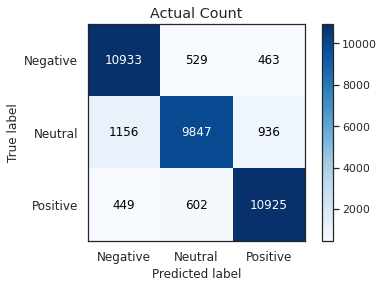

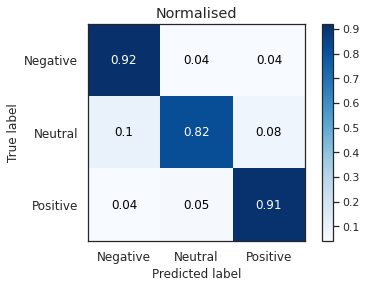


Epoch: 7, Accuracy: 0.88462612, F1: 0.88412623

Epoch: 8/15 Step: 1000... Loss: 0.132697 Val Loss: 0.359341 Accuracy: 0.883398 F1 Score: 0.883096
Epoch: 8/15 Step: 2000... Loss: 0.132786 Val Loss: 0.365606 Accuracy: 0.884515 F1 Score: 0.884034
Completed 2243 steps in epoch 8


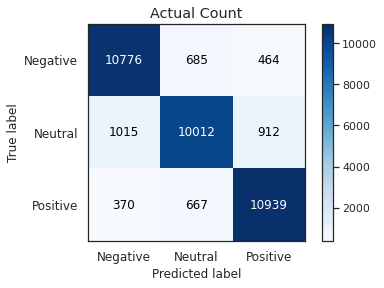

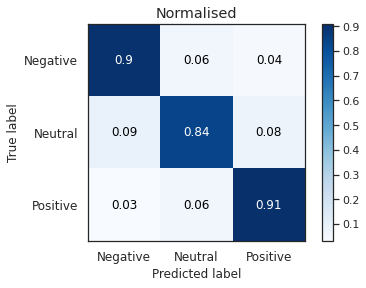


Epoch: 8, Accuracy: 0.88523996, F1: 0.88491499

Epoch: 9/15 Step: 1000... Loss: 0.157759 Val Loss: 0.367446 Accuracy: 0.883650 F1 Score: 0.883277
Epoch: 9/15 Step: 2000... Loss: 0.141157 Val Loss: 0.379954 Accuracy: 0.881334 F1 Score: 0.880855
Completed 2243 steps in epoch 9


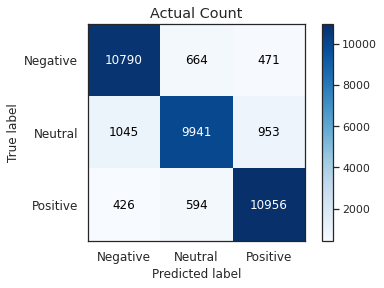

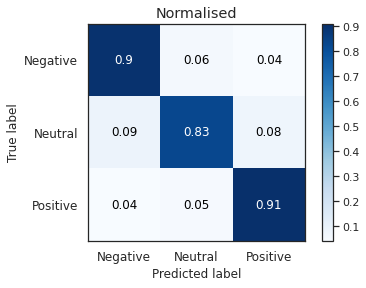


Epoch: 9, Accuracy: 0.88412388, F1: 0.88372865

Epoch: 10/15 Step: 1000... Loss: 0.129044 Val Loss: 0.374757 Accuracy: 0.882589 F1 Score: 0.882096
Epoch: 10/15 Step: 2000... Loss: 0.145853 Val Loss: 0.391346 Accuracy: 0.882450 F1 Score: 0.881913
Completed 2243 steps in epoch 10


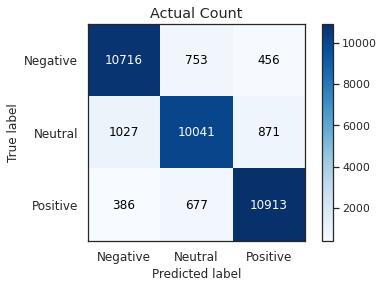

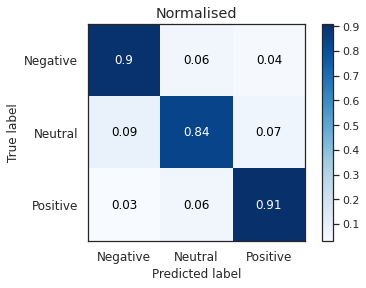


Epoch: 10, Accuracy: 0.88364955, F1: 0.88337957

Epoch: 11/15 Step: 1000... Loss: 0.100318 Val Loss: 0.394536 Accuracy: 0.881696 F1 Score: 0.881213
Epoch: 11/15 Step: 2000... Loss: 0.090695 Val Loss: 0.410931 Accuracy: 0.881808 F1 Score: 0.881378
Completed 2243 steps in epoch 11


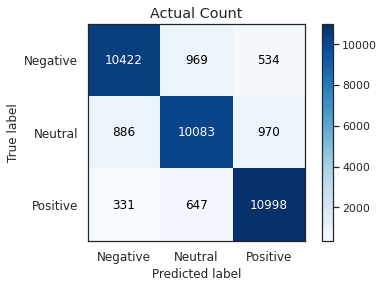

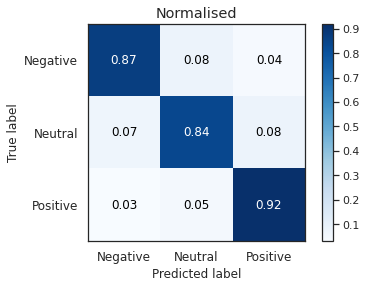


Epoch: 11, Accuracy: 0.87898996, F1: 0.87876346

Epoch: 12/15 Step: 1000... Loss: 0.069784 Val Loss: 0.408285 Accuracy: 0.881306 F1 Score: 0.880729
Epoch: 12/15 Step: 2000... Loss: 0.092682 Val Loss: 0.457407 Accuracy: 0.882254 F1 Score: 0.881945
Completed 2243 steps in epoch 12


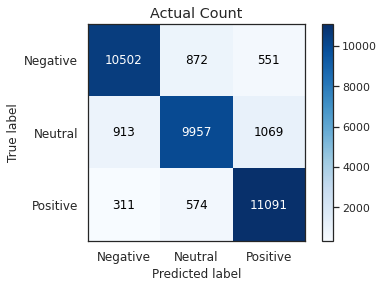

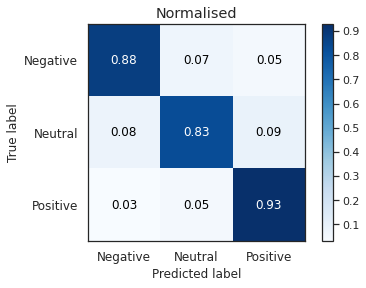


Epoch: 12, Accuracy: 0.88030134, F1: 0.87991690

Epoch: 13/15 Step: 1000... Loss: 0.130362 Val Loss: 0.423684 Accuracy: 0.882171 F1 Score: 0.881770
Epoch: 13/15 Step: 2000... Loss: 0.065025 Val Loss: 0.464307 Accuracy: 0.883231 F1 Score: 0.883040
Completed 2243 steps in epoch 13


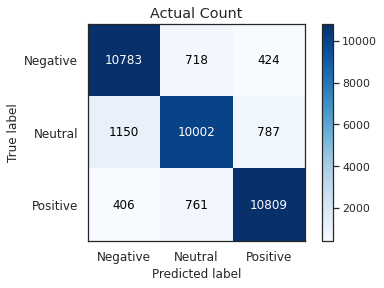

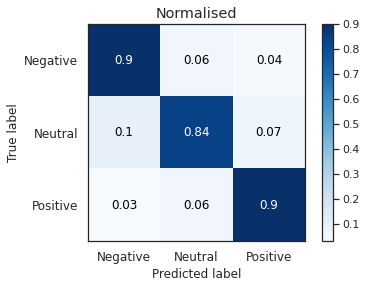


Epoch: 13, Accuracy: 0.88152902, F1: 0.88128279

Completed all epochs
Accuracy: 0.88152902, F1: 0.88128279
#################### FINAL RESULT ####################
Average Accuracy: 0.87703683, Average F1: 0.87670960


In [70]:
# Use SKF for training
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_list = []
f1_list = []
  
for fold, (train_indices, valid_indices) in enumerate(skf.split(y_train, y_train)):
    print("########## STARTING FOLD {} ##########".format(fold+1))
    # Split to train set and validation set
    X_train_fold = np.array(X_train)[train_indices]
    y_train_fold = y_train[train_indices]
    X_valid_fold = np.array(X_train)[valid_indices]
    y_valid_fold = y_train[valid_indices]

    # Set Model
    model = GloveTextClassifier(weight_matrix, lstm_size, dense_size, 3, lstm_layers, dropout)

    # Train the model for this fold
    acc, f1 = train_lstm_model(model, X_train_fold, y_train_fold, X_valid_fold, y_valid_fold, \
                                epochs, batch_size, learning_rate, sequence_length, \
                                patience, clip, print_every, print_epoch)

    acc_list.append(acc)
    f1_list.append(f1)

print("#################### FINAL RESULT ####################")

avg_acc = np.mean(acc_list)
avg_f1 = np.mean(f1_list)

print("Average Accuracy: %.8f, Average F1: %.8f" % (avg_acc, avg_f1))

# Save the best model
# torch.save(best_lstm_model.state_dict(), output_dir + 'finphrase_lstm_model_f{}_e{}.dict'.format(best_fold, best_epoch))

### Result

Epoch: 1/15 Step: 1000... Loss: 0.657262 Val Loss: 0.604592 Accuracy: 0.750246 F1 Score: 0.749622
Epoch: 1/15 Step: 2000... Loss: 0.544930 Val Loss: 0.485391 Accuracy: 0.814375 F1 Score: 0.814133
Completed 2804 steps in epoch 1


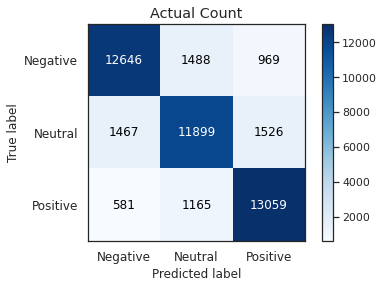

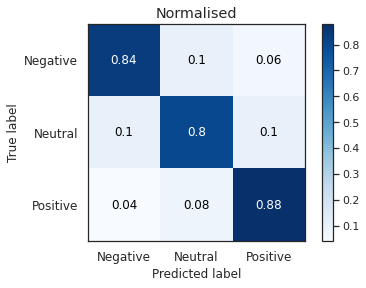


Epoch: 1, Accuracy: 0.83937500, F1: 0.83912049

Epoch: 2/15 Step: 1000... Loss: 0.550228 Val Loss: 0.387799 Accuracy: 0.857076 F1 Score: 0.856496
Epoch: 2/15 Step: 2000... Loss: 0.354614 Val Loss: 0.364919 Accuracy: 0.866362 F1 Score: 0.865610
Completed 2804 steps in epoch 2


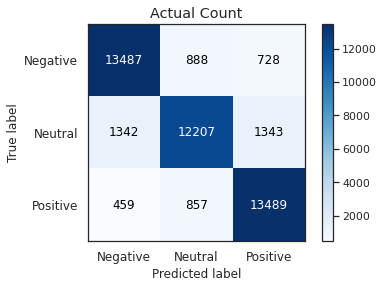

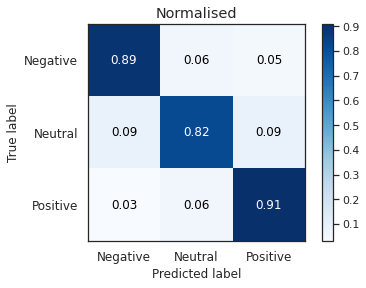


Epoch: 2, Accuracy: 0.87462054, F1: 0.87414590

Epoch: 3/15 Step: 1000... Loss: 0.445352 Val Loss: 0.333523 Accuracy: 0.879821 F1 Score: 0.879413
Epoch: 3/15 Step: 2000... Loss: 0.251068 Val Loss: 0.326674 Accuracy: 0.882143 F1 Score: 0.881642
Completed 2804 steps in epoch 3


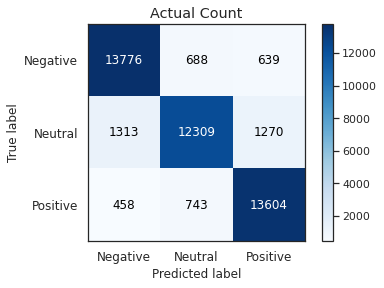

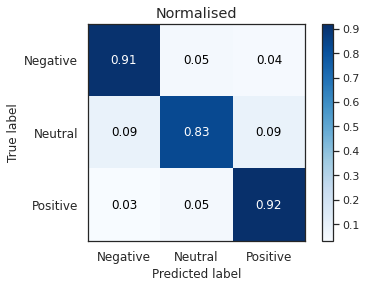


Epoch: 3, Accuracy: 0.88591518, F1: 0.88538374

Epoch: 4/15 Step: 1000... Loss: 0.358223 Val Loss: 0.313392 Accuracy: 0.888237 F1 Score: 0.887739
Epoch: 4/15 Step: 2000... Loss: 0.204360 Val Loss: 0.319649 Accuracy: 0.886473 F1 Score: 0.886148
Completed 2804 steps in epoch 4


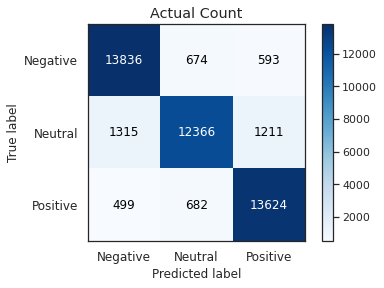

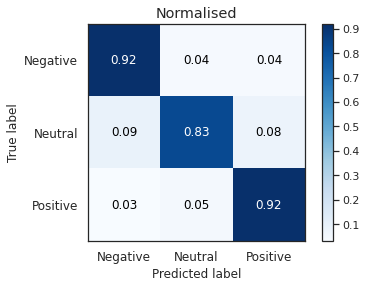


Epoch: 4, Accuracy: 0.88897321, F1: 0.88847121

Epoch: 5/15 Step: 1000... Loss: 0.280705 Val Loss: 0.310548 Accuracy: 0.891763 F1 Score: 0.891409
Epoch: 5/15 Step: 2000... Loss: 0.211106 Val Loss: 0.314252 Accuracy: 0.890134 F1 Score: 0.889722
Completed 2804 steps in epoch 5


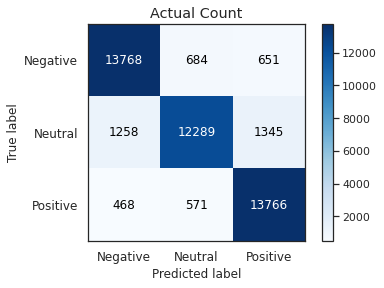

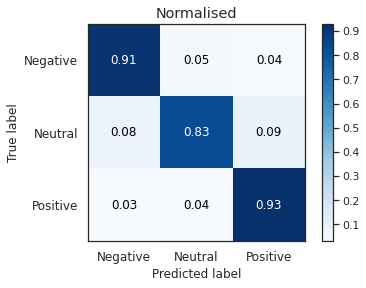


Epoch: 5, Accuracy: 0.88890625, F1: 0.88833145

Epoch: 6/15 Step: 1000... Loss: 0.269010 Val Loss: 0.317774 Accuracy: 0.891607 F1 Score: 0.891247
Epoch: 6/15 Step: 2000... Loss: 0.225026 Val Loss: 0.332282 Accuracy: 0.890826 F1 Score: 0.890696
Completed 2804 steps in epoch 6


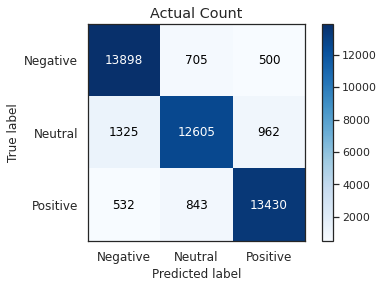

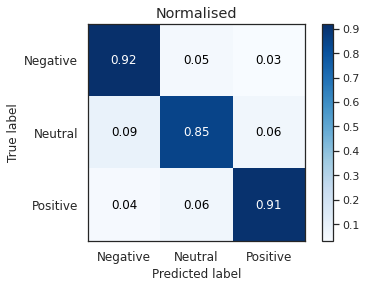


Epoch: 6, Accuracy: 0.89136161, F1: 0.89106775

Epoch: 7/15 Step: 1000... Loss: 0.209893 Val Loss: 0.332770 Accuracy: 0.889821 F1 Score: 0.889394
Epoch: 7/15 Step: 2000... Loss: 0.188017 Val Loss: 0.339656 Accuracy: 0.889911 F1 Score: 0.889644
Completed 2804 steps in epoch 7


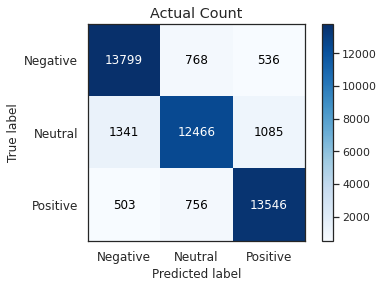

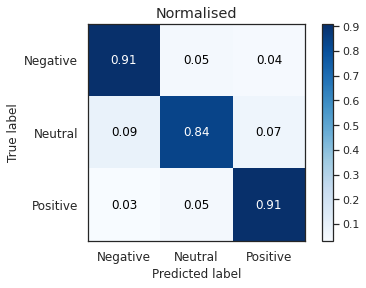


Epoch: 7, Accuracy: 0.88863839, F1: 0.88825321

Epoch: 8/15 Step: 1000... Loss: 0.166853 Val Loss: 0.338480 Accuracy: 0.890603 F1 Score: 0.890092
Epoch: 8/15 Step: 2000... Loss: 0.145279 Val Loss: 0.365520 Accuracy: 0.889509 F1 Score: 0.889192
Completed 2804 steps in epoch 8


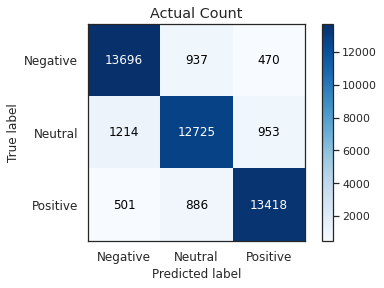

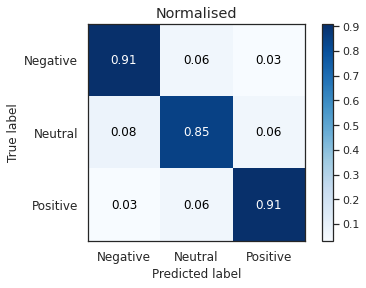


Epoch: 8, Accuracy: 0.88926339, F1: 0.88912376

Epoch: 9/15 Step: 1000... Loss: 0.125440 Val Loss: 0.359149 Accuracy: 0.886964 F1 Score: 0.886496
Epoch: 9/15 Step: 2000... Loss: 0.161174 Val Loss: 0.385833 Accuracy: 0.889621 F1 Score: 0.889301
Completed 2804 steps in epoch 9


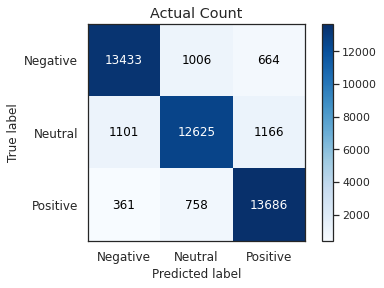

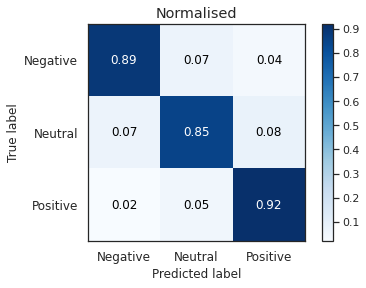


Epoch: 9, Accuracy: 0.88714286, F1: 0.88688922

Epoch: 10/15 Step: 1000... Loss: 0.167224 Val Loss: 0.376863 Accuracy: 0.887478 F1 Score: 0.887035
Epoch: 10/15 Step: 2000... Loss: 0.123947 Val Loss: 0.413133 Accuracy: 0.886629 F1 Score: 0.886466
Completed 2804 steps in epoch 10


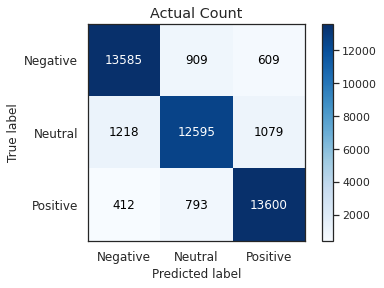

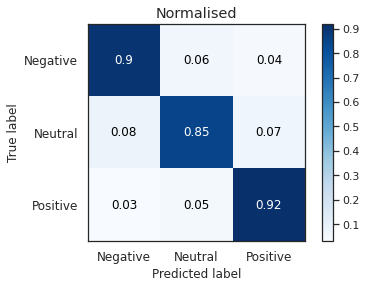


Epoch: 10, Accuracy: 0.88794643, F1: 0.88767610

Epoch: 11/15 Step: 1000... Loss: 0.157946 Val Loss: 0.388045 Accuracy: 0.887121 F1 Score: 0.886790
Epoch: 11/15 Step: 2000... Loss: 0.085188 Val Loss: 0.419305 Accuracy: 0.886920 F1 Score: 0.886799
Completed 2804 steps in epoch 11


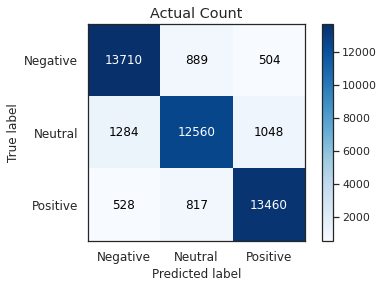

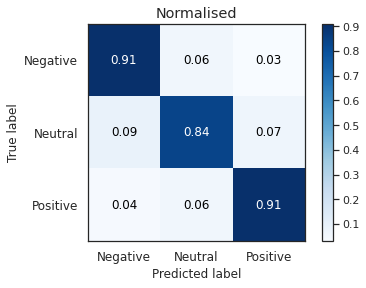


Epoch: 11, Accuracy: 0.88683036, F1: 0.88656691

Completed all epochs
Accuracy: 0.88683036, F1: 0.88656691


In [71]:
# Re-train the model with all Train set and validate on Test set
acc, f1 = train_lstm_model(model, X_train, y_train, X_test, y_test, \
                         epochs, batch_size, learning_rate, sequence_length, \
                         patience, clip, print_every, print_epoch)

In [72]:
result_df.loc['C2: LSTM+GloVe'] = (round(acc,4), round(f1,4))
result_df

Accuracy      F1
A: Lexicon       0.4101  0.3854
B: Tfidf            NaN     NaN
C1: LSTM          0.884  0.8839
C2: LSTM+GloVe   0.8868  0.8866
D1: BERT            NaN     NaN
D2: ALBERT          NaN     NaN

# D1. BERT Model

<table><tr><td><img src="./docs/bert_model.png" width=400></td><td><img src="./docs/transformer.png" width=550></td></tr></table>

![Comparison](./docs/bert-vs-openai-vs-elmo.png)

### BERT Encoding

In [29]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AdamW as AdamW_HF, get_linear_schedule_with_warmup

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


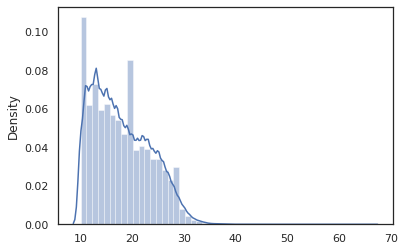

In [30]:
# Check the distribution to decide the maximum length
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
sns.distplot([len(tokenizer.tokenize(text)) for text in train_df['sentence']])

In [31]:
# # Define input class and bert encoder
# # Comment out this as the function is now provided by Huggingface

# class InputFeature(object):
#     """ A single training/test data class """
#     def __init__(self, id, input_ids, masks, segments, label=None):
#         self.id = id
#         self.features = {
#             'input_ids': input_ids,
#             'input_mask': masks,
#             'segment_ids': segments
#         }
#         self.label = label

# def bert_encoder(text, max_len=80):
#     """ Return embedded text vector as a list in max_len with a mask list"""
#     text_token = tokenizer.tokenize(text)
#     text_token = text_token[:max_len-2]
#     text_token = ["[CLS]"] + text_token + ["[SEP]"]
#     text_ids = tokenizer.convert_tokens_to_ids(text_token)
#     text_ids += [0] * (max_len - len(text_token))
#     pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
#     segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
#     return text_ids, pad_masks, segment_ids

In [32]:
# Define a DataSet Class which simply return (x, y) pair instead
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return(self.datalist[idx])

### Define Bert Model

In [33]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, dense_size, output_size, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids):
        """
        Perform a forward pass of the model on nn_input
        """
        
        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])        
        # Dense layer
        dense_out = self.fc1(self.dropout(feature))
        # Concatinate the dense output and meta inputs
        #  concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(dense_out)
        # out = self.fc(self.dropout(feature))

        return out

In [34]:
# Test the model and tokenizer

# Comment out here as not using own implementation
# bert_model = BertTextClassifier(768, 128, 3, dropout=0.1)
# text_ids, pad_masks, segment_ids = bert_encoder("Hello, my dog is cute")
# tokenizer.encode() returns only input_ids, whereas tokenizer() returns dict

#print('text_ids: \n', text_ids)
#print('text_ids (torch.tensor): \n', torch.tensor(text_ids))
#text_ids = torch.tensor(text_ids).unsqueeze(0)
#print('text_ids (unsqueezed): \n', text_ids)
#pad_masks = torch.tensor(pad_masks).unsqueeze(0)
#print('pad_masks: ',pad_masks)
#segment_ids = torch.tensor(segment_ids).unsqueeze(0)
#print('segment_ids: ',segment_ids)

#outputs = bert_model(text_ids)
#outputs = bert_model(text_ids, pad_masks, segment_ids)

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
inputs = tokenizer("Hello, my dog is cute", 
                   return_tensors="pt", 
                   pad_to_max_length=True, 
                   max_length = 64,
                   add_special_tokens=True,
                   padding_side='right')
print('inputs: \n', inputs)
print('\ndecoded: \n',tokenizer.decode(inputs['input_ids'].squeeze(0)))

labels = torch.tensor([1]).unsqueeze(0)
print('\nlabels: ', labels)

outputs = bert_model(**inputs, labels=labels)
print('\noutputs: length=', len(outputs))
print(outputs)

loss = outputs[0]
logits = outputs[1]

print('loss: ', loss.detach())
print('logits: ', logits.detach())

print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs[0].detach())


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

inputs: 
 {'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Input Data

In [35]:
# Split the data
msk = np.random.rand(len(train_df)) < 0.8
train = train_df[msk]
test = train_df[~msk]

In [36]:
# Prepare training data
# Comment out here as not using own implementation

# train_set, test_set = [], []
# max_seq_length = 48

# for index, row in tqdm(train.iterrows(), total=train.shape[0]):
#     input_ids, masks, segments = bert_encoder(row['sentence'], max_seq_length)
#     train_set.append(InputFeature(row.index, input_ids, masks, segments, int(row['label'])))    

# train_labels = train['label'].astype(int).values

# for index, row in tqdm(test.iterrows(), total=test.shape[0]):
#     input_ids, masks, segments = bert_encoder(row['sentence'], max_seq_length)
#     test_set.append(InputFeature(row.index, input_ids, masks, segments, int(row['label'])))    

# test_labels = test['label'].astype(int).values

# # numpy array to split train and valid within Fold later
# train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
# train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
# train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
# train_valid_labels = np.array([data.label for data in train_set])

# oof_train = np.zeros((len(train_df), 3), dtype=np.float32)

# # test data
# test_input_ids = [data.features['input_ids'] for data in test_set]
# test_input_masks = [data.features['input_mask'] for data in test_set]
# test_segment_ids =[data.features['segment_ids'] for data in test_set]
# test_labels = [data.label for data in test_set]


### Train

In [37]:
def train_transformer(model, x_train, y_train, x_valid, y_valid, learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length):
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    # # Train Data in Tensor
    # train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    # train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    # train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    # train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    
    # # Validation Data in Tensor
    # valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    # valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    # valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    # valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)

    # # Load data into TensorDataset
    # train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label)
    # valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_label)
    
    # Load data into SimpleDataset
    train_ds = SimpleDataset(x_train, y_train)
    valid_ds = SimpleDataset(x_valid, y_valid)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    num_total_opt_steps = int(len(train_loader) * num_epochs)
    print('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), num_epochs))
    
    # Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    # To reproduce BertAdam specific behavior set correct_bias=False
    optimizer = AdamW_HF(model.parameters(), lr=learning_rate, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler

    ## Set Loss Function
    ## If we use BertForSequenceClassification, Loss function is already included and no need to define.
    # Loss Function - use Cross Entropy as binary classification
    # loss_fn = torch.nn.CrossEntropyLoss()

    ## Set Optimizer
    ## Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    ## If we use torch.optim.Adam, set with parameter groups like this:
    # param_optimizer = list(model.named_parameters())
    # no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    # optimizer_grouped_parameters = [
    #     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    #     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
    # optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)

    # Set Train Mode
    model.train()
    
    # Tokenizer Parameter
    param_tk = {
        'return_tensors': "pt",
        'padding': 'max_length',
        'max_length': max_seq_length,
        'add_special_tokens': True,
        'truncation': True
    }

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((len(y_valid), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    total_steps = 0
    train_loss_set = []
    
    for epoch in tqdm(range(num_epochs), desc="Epoch"):
        # print('================     epoch {}     ==============='.format(epoch+1))
        train_loss = 0.

        for i, batch in enumerate(train_loader):
            # Input features and labels from batch and move to device
            x_train_bt, y_train_bt = batch
            x_train_bt = tokenizer(x_train_bt, **param_tk).to(device)
            y_train_bt = torch.tensor(y_train_bt, dtype=torch.long).to(device)
            
            # Reset gradient
            optimizer.zero_grad()

            # Feedforward prediction
            # y_pred = bert_model(x_ids, x_mask, x_sids)
            loss, logits = model(**x_train_bt, labels=y_train_bt)

            # Calculate Loss - no longer required.
            # loss = loss_fn(y_pred[0], y_truth)

            # Backward Propagation
            loss.backward()

            # Training Loss
            train_loss += loss.item() / len(train_loader)
            train_loss_set.append(loss.item())

            # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()
            
            logger.debug('train batch: %d, train_loss: %8f' % (i, loss.item() / len(train_loader)))
            total_steps += 1

        train_losses.append(train_loss)

        # Move to Evaluation Mode
        model.eval()
        
        # Initialize for Validation
        val_loss = 0.
        #valid_preds_fold = np.zeros((y_valid.size(0), 3))
        y_valid_pred = np.zeros((len(y_valid), 3))
        
        with torch.no_grad():
            for i, batch in enumerate(valid_loader):
                # Input features and labels from batch and move to device
                x_valid_bt, y_valid_bt = batch
                x_valid_bt = tokenizer(x_valid_bt, **param_tk).to(device)
                y_valid_bt = torch.tensor(y_valid_bt, dtype=torch.long).to(device)
            
                loss, logits = model(**x_valid_bt, labels=y_valid_bt)
                val_loss += loss.item() / len(valid_loader)
                y_valid_pred[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()
                logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))
        valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(y_valid, np.argmax(y_valid_pred, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = y_valid_pred
            #torch.save(model.state_dict(), output_dir + out_model_name)
        else:
            early_stop += 1
            
        print('epoch: %d, train loss: %.4f, valid loss: %.4f, acc: %.4f, f1: %.4f, best_f1: %.4f, last lr: %.6f' %
              (epoch+1, train_loss, val_loss, acc, f1, best_f1, scheduler.get_last_lr()[0]))
        
        logger.debug('valid_best: {}'.format(np.argmax(valid_best, axis=1)))

        if device == 'cuda:0':
            torch.cuda.empty_cache()

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Back to Train Mode
        model.train()

    # Once all epochs are done, output summaries
    print('================ Training Completed: Starting Post Process ===============')
    
    # Draw training/validation losses
    plt.figure(figsize=(15,6))
    plt.plot(train_losses, 'b-o', label='Training Loss')
    plt.plot(valid_losses, 'r-o', label='Validation Loss')
    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    ## Load the best model
    #model.load_state_dict(torch.load(output_dir + out_model_name))
    ## Set the model to Evaluation Mode
    #model.eval()
    
    # Check the metrics for the validation set
    acc, f1 = metric(y_valid, np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    # Convert to class names from 0, 1, 2
    class_names = ['Negative', 'Neutral', 'Positive']
    y_valid_class = [class_names[int(idx)] for idx in y_valid]
    pred_valid_class = [class_names[int(idx)] for idx in np.argmax(valid_best, axis=1)]

    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, pred_valid_class, normalize=normalize, title=title)
    plt.show()

    # plot training performance
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(train_loss_set)
    plt.show()
    
    return acc, f1, valid_best

In [38]:
# Hyperparameters
learning_rate = 2e-5
num_epochs = 3
batch_size = 32
patience = 2
warm_up_proportion = 0.1
max_grad_norm = 1.0
max_seq_length = 48

# bert_hidden_size = 768
# bert_dense_size = 128

================     fold 1    ===============


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Total Training Steps: 22430 (4486 batches x 5 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 1, train loss: 0.4329, valid loss: 0.2690, acc: 0.9005, f1: 0.8998, best_f1: 0.8998, last lr: 0.000018
epoch: 2, train loss: 0.2313, valid loss: 0.2526, acc: 0.9119, f1: 0.9113, best_f1: 0.9113, last lr: 0.000013
epoch: 3, train loss: 0.1760, valid loss: 0.2725, acc: 0.9136, f1: 0.9133, best_f1: 0.9133, last lr: 0.000009
epoch: 4, train loss: 0.1301, valid loss: 0.3241, acc: 0.9103, f1: 0.9101, best_f1: 0.9133, last lr: 0.000004
epoch: 5, train loss: 0.0974, valid loss: 0.3657, acc: 0.9114, f1: 0.9112, best_f1: 0.9133, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


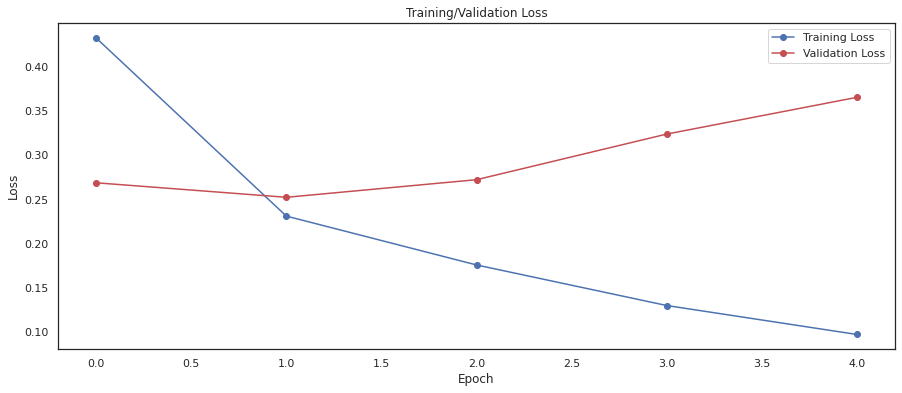

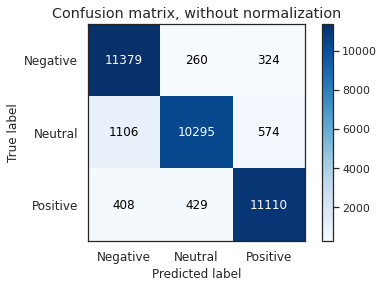

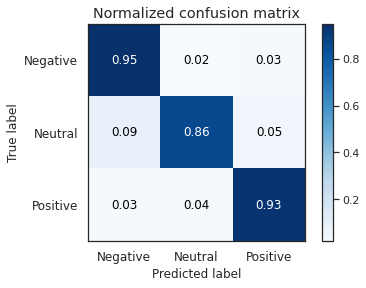

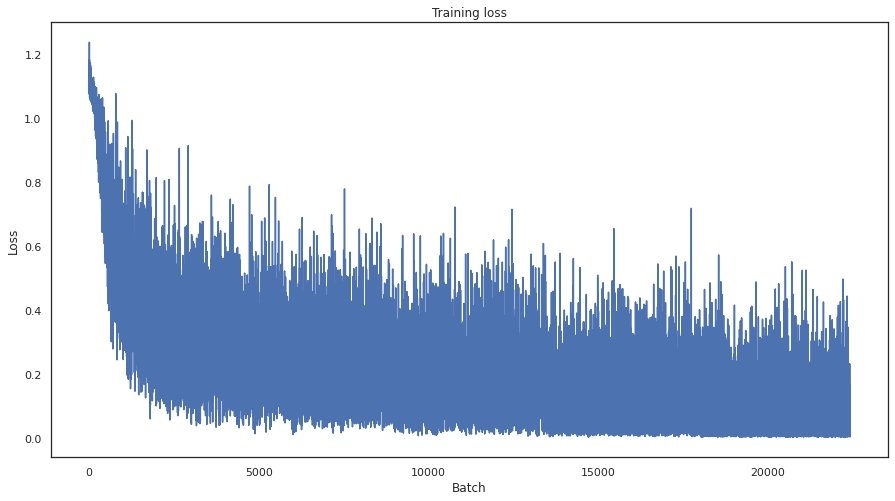

================     fold 2    ===============


KeyboardInterrupt: ignored

In [83]:
# Run the training with Stratified KFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_seed)

# Input Data
x_train = np.array(train['sentence'])
y_train = np.array(train['label'].astype(int).values)
oof_train = np.zeros((len(train), 3), dtype=np.float32)

# Set Log Level
logger = set_logger(logging.INFO)

acc_list, f1_list = [], []

for n_fold, (train_indices, valid_indices) in enumerate(skf.split(y_train, y_train)):
    #logger.info('================     fold {}    ==============='.format(n_fold+1))
    print('================     fold {}    ==============='.format(n_fold+1))
    # Input train data for this fold
    x_train_fold = x_train[train_indices]
    y_train_fold = y_train[train_indices]
    # Input validation data for this fold
    x_valid_fold = x_train[valid_indices]
    y_valid_fold = y_train[valid_indices]

    # Make sure to load the pre-trained model every time
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    
    acc, f1, valid_best = \
        train_transformer(bert_model, x_train_fold, y_train_fold, x_valid_fold, y_valid_fold, \
                          learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    oof_train[valid_indices] = valid_best

    acc_list.append(acc)
    f1_list.append(f1)
    
    
    # Number of folds to iterrate
    if n_fold == 10:
        break


print("#################### FINAL RESULT ####################")

avg_acc = np.mean(acc_list)
avg_f1 = np.mean(f1_list)

print("Average Accuracy: %.8f, Average F1: %.8f" % (avg_acc, avg_f1))


## Test and Result
Make sure you do not run the test until the model is fixed by cross validation.

In [ ]:
# Re-train the model with all Train set and validate on Test set

# Input Data
x_train = np.array(train['sentence'])
y_train = np.array(train['label'].astype(int).values)
x_test = np.array(test['sentence'])
y_test = np.array(test['label'].astype(int).values)

# Make sure to load the pre-trained model every time
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

acc, f1, valid_best = \
        train_transformer(bert_model, x_train, y_train, x_test, y_test, \
                          learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    
print(('Accuracy: %.8f, f1: %.8f\n' % (acc, f1)))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Total Training Steps: 16812 (5604 batches x 3 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 1, train loss: 0.3858, valid loss: 0.2515, acc: 0.9110, f1: 0.9107, best_f1: 0.9107, last lr: 0.000015
epoch: 2, train loss: 0.2170, valid loss: 0.2315, acc: 0.9197, f1: 0.9196, best_f1: 0.9196, last lr: 0.000007


In [ ]:
result_df.loc['D1: BERT'] = (round(acc,4), round(f1,4))
result_df

# D2: ALBERT

### Model and Train

In [ ]:
# Set Tokenizer and Model
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AlbertModel
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

In [ ]:
# Hyperparameters
learning_rate = 1e-5
num_epochs = 3
batch_size = 32
patience = 2
warm_up_proportion = 0.1
max_grad_norm = 1.0
max_seq_length = 48

# bert_hidden_size = 768
# bert_dense_size = 128

In [ ]:
# Run the training with Stratified KFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_seed)

# Input Data
x_train = np.array(train['sentence'])
y_train = np.array(train['label'].astype(int).values)
oof_train = np.zeros((len(train), 3), dtype=np.float32)

# Set Log Level
logger = set_logger(logging.INFO)

acc_list, f1_list = [], []

for n_fold, (train_indices, valid_indices) in enumerate(skf.split(y_train, y_train)):
    #logger.info('================     fold {}    ==============='.format(n_fold+1))
    print('================     fold {}    ==============='.format(n_fold+1))
    # Input train data for this fold
    x_train_fold = x_train[train_indices]
    y_train_fold = y_train[train_indices]
    # Input validation data for this fold
    x_valid_fold = x_train[valid_indices]
    y_valid_fold = y_train[valid_indices]

    # Make sure to load the pre-trained model every time
    albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)
    
    acc, f1, valid_best = \
        train_transformer(albert_model, x_train_fold, y_train_fold, x_valid_fold, y_valid_fold, \
                          learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    oof_train[valid_indices] = valid_best

    acc_list.append(acc)
    f1_list.append(f1)
    
    
    # Number of folds to iterrate
    if n_fold == 10:
        break


print("#################### FINAL RESULT ####################")

avg_acc = np.mean(acc_list)
avg_f1 = np.mean(f1_list)

print("Average Accuracy: %.8f, Average F1: %.8f" % (avg_acc, avg_f1))


### Test and Result
Make sure you do not run the test until the model is fixed by cross validation.

In [ ]:
# Re-train the model with all Train set and validate on Test set

# Input Data
x_train = np.array(train['sentence'])
y_train = np.array(train['label'].astype(int).values)
x_test = np.array(test['sentence'])
y_test = np.array(test['label'].astype(int).values)

# Make sure to load the pre-trained model every time
albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

acc, f1, y_test_pred = \
        train_transformer(albert_model, x_train, y_train, x_test, y_test, \
                          learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    
print(('Accuracy: %.8f, f1: %.8f\n' % (acc, f1)))

In [ ]:
result_df.loc['D2: ALBERT'] = (round(acc,4), round(f1,4))
result_df

# Final Result

In [ ]:
# If disconnected after the training complete, just recreate the result_df rather than running the training again...
disconnected = False
if disconnected:
    result_df = pd.DataFrame(columns=['Accuracy', 'F1'], index=['A: Lexicon', 'B: Tfidf', 'C: LSTM', 'D: LSTM+GloVe', 'E: BERT', 'F: ALBERT'])
    result_df.loc['A: Lexicon'] = (0.6522,0.4506)
    result_df.loc['B: Tfidf'] = (0.8145,0.7195)
    result_df.loc['C1: LSTM'] = (0.8185,0.7657)
    result_df.loc['C2: LSTM+GloVe'] = (0.8051,0.7415)
    result_df.loc['D1: BERT'] = (0.9493,0.9267)
    result_df.loc['D2: ALBERT'] = (0.9067,0.8849)


In [ ]:
ax = result_df.plot.bar(rot=0, figsize=(10,5))

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

# Save Data

In [ ]:
def save_data(df, file_name, dir_name=output_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [ ]:
# Save text data
save_data(train_df, 'tweet_result_df')

# Extra - tweet stream

In [ ]:
with open(tweet_dir + 'test_twits.json', 'r') as f:
    test_data = json.load(f)

def twit_stream():
    for twit in test_data['data']:
        yield twit

next(twit_stream())

In [ ]:
def predict(text, model, vocab):
    """ 
    Make a prediction on a single sentence.

    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
        vocab : Dictionary for word to word ids. The key is the word and the value is the word id.

    Returns
    -------
        pred : Prediction vector
    """    
    
    text = preprocess(text)
    text_ids, pad_masks, segment_ids = bert_encoder(text)
    
    text_ids = torch.tensor(text_ids).unsqueeze(0)
    pad_masks = torch.tensor(pad_masks).unsqueeze(0)
    segment_ids = torch.tensor(segment_ids).unsqueeze(0)

    outputs = model(text_ids, pad_masks, segment_ids)[0].detach()    
    pred = F.softmax(outputs, dim=1)
    
    return pred

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(torch.load(output_dir + 'model_fold_0.dict'))
model.eval()
model.to("cpu")

In [ ]:
# Check
text = "Google is working on self driving cars, I'm bullish on $goog"
predict(text, model, vocab)

In [ ]:
def score_twits(stream, model, vocab, universe):
    """ 
    Given a stream of twits and a universe of tickers, return sentiment scores for tickers in the universe.
    """
    for twit in stream:

        # Get the message text
        text = twit['message_body']
        if len(tokenizer.tokenize(preprocess(text))) < 10:
            continue
        symbols = re.findall('\$[A-Z]{2,4}', text)
        score = predict(text, model, vocab)

        for symbol in symbols:
            if symbol in universe:
                yield {'symbol': symbol, 'score': score, 'text': text, 'timestamp': twit['timestamp']}

In [ ]:
# Select Universe
universe = {'$BBRY', '$AAPL', '$AMZN', '$BABA', '$YHOO', '$LQMT', '$FB', '$GOOG', '$BBBY', '$JNUG', '$SBUX', '$MU'}
score_stream = score_twits(twit_stream(), model, vocab, universe)

In [ ]:
# Process
for i in range(10):
    print(next(score_stream))
    i+=1